In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

# plt.style.use('seaborn-pastel')
# plt.style.use('dark_background')
plt.rcParams.update({'font.size': 23})
plt.rcParams['lines.linewidth'] = 3.5

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


In [ ]:
# @markdown SEIQR class (stoch2 ripped up)
class SEIQR():

  def __init__(self, **kwargs):
    keys=kwargs.keys()
    self.kwargs = kwargs

    assert 'sigma' in keys
    self.sigma=kwargs['sigma']
    assert 'tau' in keys
    self.tau=kwargs['tau']
    assert 'kappa' in keys
    self.kappa=kwargs['kappa']
    assert 'epsilon' in keys
    self.epsilon=kwargs['epsilon']
    
    
    assert 't_start' in keys
    assert 'dt' in keys
    self.t_start=kwargs['t_start']
    if 't_end' in keys:
      self.t_end=kwargs['t_end']
    elif 't_mult' in keys:
      self.t_end=kwargs['t_mult']*self.max_delay
    else:
      self.t_end=80
    self.dt=kwargs['dt']
    self.t_vector = np.arange(self.t_start, self.t_end, self.dt)
    self.t0=int((self.sigma+self.tau+self.kappa)/self.dt)-1
    self.size=self.t_vector.shape[0]


    self.lockdown_time = None
    if 'steer_value' in keys:
      self.steer_value=kwargs['steer_value']
    if 'delta_o' in keys:
      self.delta_o=kwargs['delta_o']
    if 'qpo' in keys:
      self.qpo=kwargs['qpo']
    if 'qpld' in keys:
      self.qpld=kwargs['qpld']
    if 'dld' in keys:
      self.dld=kwargs['dld']
      
    if 'r1' in keys:
      self.r1 = r1
    if 'beta' in keys:
      self.beta=np.zeros(self.size) + kwargs['beta']
    assert 'm' in keys
    self.m=kwargs['m']
    if 'alpha' in keys:
      self.alpha=kwargs['alpha']
    else:
      self.alpha=0
    self.stop_spikes=False

    
    



    """Initial Conditions"""
    assert 'init' in keys
    self.X0=kwargs['init']
    
    self.S=np.zeros(self.size)
    
    self.E=np.zeros(self.size)
    
    self.I=np.zeros(self.size)
    
    self.Q=np.zeros(self.size)
    self.Qp=np.zeros(self.size)
    self.Qpb=np.zeros(self.size)
    self.Ep=np.zeros(self.size)

    self.R=np.zeros(self.size)
    self.rset = False


    if self.t0>0:
      # self.I[int(self.sigma/self.dt)] +
      I0=self.X0[2]
      self.I[:self.t0+1]=[I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      # self.E[:self.t0+1]=[(np.exp(self.sigma) - 1)*I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      # estart = [10e-5*np.exp(x.t_vector[i] - x.t_vector[x.t0] + x.sigma) - 10e-5*np.exp(x.t_vector[i] - x.t_vector[x.t0]) for i in range(x.t0)]
      # plt.plot(estart)
      # wawa=[0 for i in range(x.t0)]
      # estart.extend([estart[0]+estart[-1]-(np.exp(x.sigma) - 1)*10e-5*np.exp(x.t_vector[i] - x.t_vector[x.t0]) for i in range(x.t0)])
            
      
      # self.E[self.t0+1:2*self.t0+1] = [self.E[0]+self.E[self.t0]-(np.exp(self.sigma) - 1)*10e-5*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0)]
      # self.E[self.t0+1:2*self.t0+1]=-self.I[:self.t0+1]
      # self.E[int(self.sigma/self.dt):self.t0+1]-=self.E[:self.t0+1-int(self.sigma/self.dt)]
      # self.R[:self.t0+1]=[self.X0[3]+(1-self.epsilon)*(1/self.epsilon)*I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      # self.Q[int((self.sigma+self.tau)/self.dt):self.t0+1]=[self.p*np.exp(-self.tau)*self.I[i - int(self.tau/self.dt)] for i in range(int((self.sigma+self.tau)/self.dt), self.t0+1)]
      self.S[:self.t0+1]=1-self.I[:self.t0+1]-self.E[:self.t0+1]-self.Q[:self.t0+1]-self.R[:self.t0+1]
      # self.Ep[1:self.t0+1]=self.E[1:self.t0+1]-self.E[:self.t0]#/self.dt#self.m*np.multiply(self.beta[:self.t0+1] , np.multiply(self.S[:self.t0+1], self.I[:self.t0+1]))
      # self.Ep[0]=self.E[0]

    elif self.t0==0:
      self.S[0]=self.X0[0]
      self.E[0]=self.X0[1]
      self.I[0]=self.X0[2]
      self.Q[0]=0
      self.Qp[0]=0
      self.R[0]=self.X0[3]
    

    if 'd_func' in keys:
      self.delta=np.ones(self.size)
      self.d_func=kwargs['d_func']
      self.has_d_func=True
      if 'd_param' in keys:
        self.d_param=kwargs['d_param']
      else:
        self.d_param=None
    elif 'delta' in keys:
      self.delta=np.zeros(self.size) + kwargs['delta']
      self.has_d_func=False
    self.epsilon_history = np.ones(self.size)
    self.n_history = np.zeros(self.size)
    self.n_historyb = np.zeros(self.size)
    # if kwargs['rand']=='manual':
    #   self.n_history[int(24/self.dt)] = 1000/10e6
    self.ct_history = np.zeros(self.size)

    if 'p_func' in keys:
      self.p=np.zeros(self.size)
      self.p_func=kwargs['p_func']
      self.has_p_func=True
      if 'p_param' in keys:
        self.p_param=kwargs['p_param']
      else:
        self.p_param=None
    elif 'p' in keys:
      self.p=np.zeros(self.size) + kwargs['p']
      self.has_p_func=False


  def plot(self):
    plt.figure()
    plt.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$")
    plt.plot(self.t_vector, self.S, label="S")
    plt.plot(self.t_vector, self.E, label="E")
    plt.plot(self.t_vector, self.I, label="I")
    plt.plot(self.t_vector, self.Q, label="Q", c='k')
    plt.plot(self.t_vector, self.R, label="R")
    title='SEIR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}'.format(self.sigma)
    plt.xlabel('$\\gamma \\cdot$ time')
    plt.ylabel('population')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

  def full_plot(self, end_title='', **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='orange')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='k')
    ax1.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')

    r1 = self.m*self.beta
    r2 = np.multiply(r1, (1 - self.p*np.exp(-self.tau)))
    r3 = np.multiply(r2, (1 - self.R - self.Q))
    r4 = np.multiply(r3, self.epsilon_history)
    r5 = np.multiply(self.delta, r4)
    ax3.plot(self.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='r')
    ax3.step(self.t_vector[:-1], self.delta[:-1], label="$\\delta$", c='mediumspringgreen')
    ax3.legend()


    title='SEIQR: '+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\tau$={}, '.format(self.tau) + '$\\kappa$={}, '.format(self.kappa)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')

    ax2.plot(self.t_vector, self.I, label="I", c='coral')
    ax2.plot(self.t_vector, self.E, label="E", c='orange')
    ax2.plot(self.t_vector, self.Q, label="Q", c='k')
    ax2.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax2.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax2.set_xlabel('$\\gamma \\cdot$ time')
    if 'short' in kwargs.keys():
        if 't_max' in kwargs.keys():
          ax2.set_xlim(0, kwargs['t_max'])
        else:
          ax2.set_xlim(0, 40)
    ax2.legend(loc='upper right')
    fig.suptitle(title+end_title)
    fig.patch.set_alpha(0.7)
    fig.show()


  def run(self):
    first = False
    last = False
    mid = False
    done= False
    for i, t in enumerate(self.t_vector[:-1]):
      if i>=self.t0:
        if self.has_d_func:
          if self.d_param=='Q+':
            self.delta[i]=self.d_func(i, self.R, self.Qp, self.Q)
          elif self.d_param=='straight':
            self.delta[i]=SEIQR.straight(self, i)

          elif self.d_param=='new_model3BIG':
            delayed_idx = int(i-0.5/self.dt)
            r_eff = self.beta[i]*self.m*(1-self.p[i]*np.exp(-self.tau))
            d=self.d_func/(r_eff*(1-self.R[delayed_idx]-self.Q[delayed_idx]))
            if (self.Qp[i]>0.003 or done) and mid and last:
              self.delta[i]=np.min([d,1])#np.min([1/SEIQR.delta_open(self, i, True), 1])
              done=True
            elif first and ((self.Qp[i]<0.001 and t>14) or mid):
              if not mid:
                self.delta[i:int(i+7.5/self.dt)]= np.min([d,1])#np.min([1/SEIQR.delta_open(self, i, True), 1])
                self.delta[int(i+7.5/self.dt):]=0
              elif mid:
                if self.delta[i]==0:
                  self.delta[i] = np.min([1.25*d,1]) #np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
              mid = True
              last = False if self.Qp[i]<0.003 else True
              # first = True if self.Qp[i]<0.003 else False
            elif self.Qp[i]>0.002 and not first:
              self.delta[i:]=self.dld
              first = True
            elif not first and not last: 
              self.delta[i] = 1
          
          elif self.d_param=='delta_open':
            if first and self.Qp[i]<self.qpo and not last:
              self.delta[i:]= self.delta_o
              last = True
            elif self.Qp[i]>0.002 and not first:
              self.delta[i:]=self.dld
              first = True
            elif not first and not last: 
              self.delta[i] = 1

          elif self.d_param=='periodic':
            if last and x.Qp[i]>x.qpld and self.delta[i]!=0:
              self.delta[i:i+400]=self.dld
              self.delta[i+400:]=0
              last = False
            elif first and (last or self.Qp[i]<self.qpo or self.delta[i]==0):
              delayed_idx = int(i-0.5/self.dt)
              r_eff = x.beta[delayed_idx]*x.m*(1-x.p[delayed_idx]*np.exp(-x.tau))
              d=x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx]))
              self.delta[i]= np.min([d, 1])
              self.delta[i+1:]= 1
              last = True
            # elif last and x.Qp[int(i-0.5/x.dt)]>10*x.qpo:
            # elif last and 10e6*np.sum(x.Qp[int(i-0.5/x.dt):i])*self.dt>150:
            # elif last and 10e6*x.dt*np.sum(x.Qp[i-100:i])>700:
            #   self.delta[i:]=self.dld
            #   last = False
            elif self.Qp[i]>0.002 and not first:
              self.delta[i:]=self.dld
              first = True
            elif not first and not last: 
              self.delta[i] = 1

          elif self.d_param=='new_periodic':
            delayed_idx = int(i-0.5/self.dt)
            r_eff = self.beta[delayed_idx]*self.m*(1-self.p[delayed_idx]*np.exp(-self.tau))
            d=self.d_func/(r_eff*(1-self.R[delayed_idx]-self.Q[delayed_idx]))
            d1=1/(r_eff*(1-self.R[delayed_idx]-self.Q[delayed_idx]))
            d2=1.09/(r_eff*(1-self.R[delayed_idx]-self.Q[delayed_idx]))
            if last and x.Qp[i]>x.qpld:
              self.delta[i:i+400]=self.dld
              self.delta[i+400:]=1
              last = False
            elif first and (last or self.Qp[i]<self.qpo or self.delta[i]==1):
              if not mid:
                self.delta[i:int(i+7.5/self.dt)]= np.min([d1,1])#np.min([1/SEIQR.delta_open(self, i, True), 1])
                self.delta[int(i+7.5/self.dt):]=0
              # delayed_idx = i
              elif mid:
                if self.delta[i]==0:
                  self.delta[i]= np.min([d, 1])
                elif self.delta[i]==1:
                  self.delta[i]= np.min([d2, 1])
              mid=True
              last = True
            # elif last and x.Qp[int(i-0.5/x.dt)]>10*x.qpo:
            # elif last and 10e6*np.sum(x.Qp[int(i-0.5/x.dt):i])*self.dt>150:
            # elif last and 10e6*x.dt*np.sum(x.Qp[i-100:i])>700:
            #   self.delta[i:]=self.dld
            #   last = False
            elif self.Qp[i]>0.002 and not first:
              self.delta[i:]=self.dld
              first = True
            elif not first and not last:
              self.delta[i] = 1
            
          
              
        self.set_nhistory(i, t)
        self.step(i, t)



  def step(self, i, t):
    d=int(i-self.sigma/self.dt)
    ta=int(i-(self.sigma+self.tau)/self.dt)
    tt = int(i-self.tau/self.dt)

    ta2=int(i-(self.sigma+2*self.tau)/self.dt)
    tt2 = int(i-2*self.tau/self.dt)
    ta3=int(i-(self.sigma+3*self.tau)/self.dt)
    tt3 = int(i-3*self.tau/self.dt)

    tk = int(i-(self.tau+self.kappa)/self.dt)
    tka=int(i-(self.sigma+self.tau + self.kappa)/self.dt)
    tka2=int(i-(self.sigma+2*self.tau+self.kappa)/self.dt)
    tk2 = int(i-(2*self.tau+self.kappa)/self.dt)
    tka3=int(i-(self.sigma+3*self.tau+self.kappa)/self.dt)
    tk3 = int(i-(3*self.tau+self.kappa)/self.dt)


    self.epsilon_history[i] = self.epsilon(t, self.Qpb[int(i - self.tau/self.dt)])
    self.S[i+1]=self.S[i] + self.sdot(i, t)*self.dt #- self.n_history[i]
    self.E[i+1]=self.E[i] + self.edot(i, t)*self.dt #+ self.n_history[i] - self.n_history[d]
    self.I[i+1]=self.I[i] + self.idot(i, t)*self.dt #+ self.n_history[d] #-self.n_history[ta]#- self.p[tt]*self.n_history[ta] - 0.5*self.p[tt2]*self.n_history[ta2] - 0.5*self.p[tt3]*self.n_history[ta3]
    self.Q[i+1]=self.Q[i] + self.qdot(i, t)*self.dt# + self.n_history[ta]# - self.n_history[tka]#+ self.p[tt]*self.n_history[ta] + 0.5*self.p[tt2]*self.n_history[ta2] + 0.5*self.p[tt3]*self.n_history[ta3] - self.p[tk]*self.n_history[tka] - 0.5*self.p[tk2]*self.n_history[tka2] - 0.5*self.p[tk3]*self.n_history[tka3] 
    self.Qp[i+1]+=self.qplus(i, t) #+ self.n_history[ta]/self.dt#+ self.p[tt]*self.n_history[ta] + 0.5*self.p[tt2]*self.n_history[ta2] + 0.5*self.p[tt3]*self.n_history[ta3]
    self.Qpb[i+1]+=self.qplus_base(i, t)
    self.Ep[i+1] = self.delta[i]*self.beta[i]*self.m*self.S[i]*self.I[i] + self.n_history[i]/self.dt
    self.R[i+1]=self.R[i] + self.rdot(i, t)*self.dt# + self.n_history[tka]#+ self.p[tk]*self.n_history[tka] + 0.5*self.p[tk2]*self.n_history[tka2] + 0.5*self.p[tk3]*self.n_history[tka3]
    


  def sdot(self, i, t):
    return -self.Ep[i] + self.alpha*self.R[i]

  def edot(self, i, t):
    d=int(i-self.sigma/self.dt)
    return self.Ep[i] - self.Ep[d]

  def idot(self, i, t):
    d=int(i-self.sigma/self.dt)
    t=int(i-(self.sigma+self.tau)/self.dt)
    pt=int(i-(self.tau)/self.dt)
    # return self.epsilon_history[d]*self.Ep[d] - self.I[i] - self.Qp[t]
    return self.epsilon_history[d]*(self.Ep[d] - self.n_history[d-1]/self.dt) - self.I[i] - self.Qp[i] + self.n_history[d-1]/self.dt
 
  def qdot(self, i, t):
    d=int(i-self.sigma/self.dt)
    t=int(i- (self.sigma+self.tau)/self.dt)
    pt = int(i- self.tau/self.dt)
    ptk = int(i- (self.tau+self.kappa)/self.dt)
    k=int(i - (self.sigma+self.tau+self.kappa)/self.dt)
    k_prime=int(i - (self.sigma+self.kappa)/self.dt)
    ct = (1-self.epsilon_history[d])*(self.Ep[d] - self.n_history[d-1]/self.dt) - (1-self.epsilon_history[k_prime])*(self.Ep[k_prime] - self.n_history[k_prime-1]/self.dt)
    self.ct_history[i] = (1-self.epsilon_history[d])*(self.Ep[d] - self.n_history[d-1]/self.dt)
    return self.Qp[i] - self.Qp[int(i-self.kappa/self.dt)] + ct
  
  def qplus(self, i, t):
    t=int(i-(self.sigma+self.tau)/self.dt)
    t2=int(i-(self.sigma+2*self.tau)/self.dt)
    t3=int(i-(self.sigma+3*self.tau)/self.dt)
    pt = int(i-self.tau/self.dt)
    pt2=int(i-(2*self.tau)/self.dt)
    pt3=int(i-(3*self.tau)/self.dt)
    k=int(i-(self.sigma+self.tau+self.kappa)/self.dt)
    # return self.epsilon_history[t]*self.p[pt]*np.exp(-self.tau)*self.Ep[t]
    # return self.epsilon_history[t]*self.p[pt]*np.exp(-self.tau)*(self.Ep[t]- self.n_history[t-1]/self.dt) + self.p[pt]*np.exp(-self.tau)*self.n_history[t-1]/self.dt + (1/2)*(1 - self.p[pt2]*np.exp(-self.tau))*self.n_history[t2-1]/self.dt + + (1/4)*(1 - self.p[pt3]*np.exp(-self.tau))*self.n_history[t3-1]/self.dt
    return self.epsilon_history[t]*self.p[pt]*np.exp(-self.tau)*(self.Ep[t]- self.n_history[t-1]/self.dt) + self.p[pt]*np.exp(-self.tau)*self.n_history[t-1]/self.dt + (1/2)*(1 - self.p[pt2])*np.exp(-2*self.tau)*self.n_history[t2-1]/self.dt # + (1/4)*(1 - self.p[pt3])*np.exp(-3*self.tau)*self.n_history[t3-1]/self.dt

  def qplus_base(self, i, t):   
    t=int(i-(self.sigma+self.tau)/self.dt)
    t2=int(i-(self.sigma+2*self.tau)/self.dt)
    t3=int(i-(self.sigma+3*self.tau)/self.dt)
    pt = int(i-self.tau/self.dt)
    pt2=int(i-(2*self.tau)/self.dt)
    pt3=int(i-(3*self.tau)/self.dt)
    k=int(i-(self.sigma+self.tau+self.kappa)/self.dt)
    # return self.epsilon_history[t]*self.p[pt]*np.exp(-self.tau)*self.Ep[t]
    return self.epsilon_history[t]*self.p[pt]*np.exp(-self.tau)*(self.Ep[t]- self.n_history[t-1]/self.dt)



  def rdot(self, i, t):
    d=int(i-self.sigma/self.dt)
    t=int(i-(self.sigma+self.tau)/self.dt)
    k=int(i-(self.sigma+self.tau+self.kappa)/self.dt)
    k_prime=int(i - (self.sigma+self.kappa)/self.dt)
    ptk = int(i- (self.tau+self.kappa)/self.dt)
    ct = (1-self.epsilon_history[k_prime])*(self.Ep[k_prime] - self.n_history[k_prime-1]/self.dt)
    return -self.alpha*self.R[i] + self.I[i] + self.Qp[k] + ct


  def tld(self, t=-1):
    try:
      w=np.where(self.delta[:t+1] < 1)[0][0]
    except IndexError:
      return None
    return self.t_vector[w], w

  def set_nhistory(self, i, t):
    if t%2==0 and not self.stop_spikes:
      s = self.kwargs['rand']
      r =  np.random.uniform()
      if s =='b':
        if r<= 0.1:
          n = 20
          self.n_history[i] += n/10e6
      elif s =='c':
        if r<= 0.1:
          n = np.random.randint(30, 50)
          self.n_history[i] += n/10e6
      elif s =='d':
        if r<= 0.1:
          n = np.random.randint(1, 100)
          self.n_history[i] += n/10e6
      elif s =='e':
        if r<= 0.1:
          n = np.random.randint(1, 280)
          self.n_history[i] += n/10e6
      else:
        pass

  @staticmethod
  def transition(start_val, end_val, start_time, end_time, t_vec):
    out=np.zeros(t_vec.shape[0]) + end_val
    t0=np.where(t_vec>start_time)[0][0]
    t1=np.where(t_vec>end_time)[0][0]
    out[:t0]=start_val
    rng=t1-t0
    out[t0:t1]=[start_val + (end_val-start_val)*i**2/rng**2 for i in range(rng)]
    return out

  @staticmethod
  def straight(x, i, delay=1/2, dld=0.3, qpld=0.002):
    ld = False if not i > 1 else np.max(x.Qp[:i]) > qpld
    ld_end = False
    if ld and not x.kwargs['sett']:
      x.lockdown_time = i
      print('set')
      x.kwargs['sett'] = True


    if ld and i - x.lockdown_time > 1:
      try:
        x.max_Q
      except:
        x.max_Q=np.argmax(x.Q)
        
      if i-x.max_Q>1:
        ld_end = np.min(x.Qp[x.max_Q:i])<x.steer_value
      else:
        ld_end = False

    
    if ld_end and ld:
      if x.Qp[i]>=x.steer_value and i*x.dt<30:
        return x.delta[i-1]

      delayed_idx = int(i-0.5/x.dt)
      r_eff = x.beta[delayed_idx]*x.m*(1-x.p[delayed_idx]*np.exp(-x.tau))
      d=x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx]))
      return np.min([d, 1])
    if ld:
      return dld
    else:
      return 1


  @staticmethod
  def contact_curve(n):
    daily = n*10000000/10
    return 1/(1+np.exp((daily-100)/20))

  @staticmethod
  def delta_open(x, i, r_eff=False):
    # iopen = np.where(x.delta[1:]>x.delta[:-1])[0][0]
    delay = int(i - x.tau/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.epsilon(x.t_vector[delay], x.Qp[delay])
    if r_eff:
      return r4
    return 1/r4

  @staticmethod
  def test(x, i):
    delay = i#int(i - x.tau/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay] - x.Q[delay])
    r4 = r3*x.delta_o
    return (1/r4)

     


In [ ]:
# @markdown SEIQR class (stoch2)
class SEIQR():

  def __init__(self, **kwargs):
    keys=kwargs.keys()
    self.kwargs = kwargs

    assert 'sigma' in keys
    self.sigma=kwargs['sigma']
    assert 'tau' in keys
    self.tau=kwargs['tau']
    assert 'kappa' in keys
    self.kappa=kwargs['kappa']
    assert 'epsilon' in keys
    self.epsilon=kwargs['epsilon']
    
    
    assert 't_start' in keys
    assert 'dt' in keys
    self.t_start=kwargs['t_start']
    if 't_end' in keys:
      self.t_end=kwargs['t_end']
    elif 't_mult' in keys:
      self.t_end=kwargs['t_mult']*self.max_delay
    else:
      self.t_end=80
    self.dt=kwargs['dt']
    self.t_vector = np.arange(self.t_start, self.t_end, self.dt)
    self.t0=int((self.sigma+self.tau+self.kappa)/self.dt)-1
    self.size=self.t_vector.shape[0]


    self.lockdown_time = None
    if 'steer_value' in keys:
      self.steer_value=kwargs['steer_value']
    if 'contact_perc' in keys:
      self.contact_perc=kwargs['contact_perc']
    if 'delta_o' in keys:
      self.delta_o=kwargs['delta_o']
    if 'qpo' in keys:
      self.qpo=kwargs['qpo']
    if 'dld' in keys:
      self.dld=kwargs['dld']
      
    if 'r1' in keys:
      self.r1 = r1
    if 'beta' in keys:
      self.beta=np.zeros(self.size) + kwargs['beta']
    assert 'm' in keys
    self.m=kwargs['m']
    if 'alpha' in keys:
      self.alpha=kwargs['alpha']
    else:
      self.alpha=0
    self.stop_spikes=False

    
    



    """Initial Conditions"""
    assert 'init' in keys
    self.X0=kwargs['init']
    
    self.S=np.zeros(self.size)
    
    self.E=np.zeros(self.size)
    
    self.I=np.zeros(self.size)
    
    self.Q=np.zeros(self.size)
    self.Qp=np.zeros(self.size)
    self.Ep=np.zeros(self.size)

    self.R=np.zeros(self.size)
    self.rset = False


    if self.t0>0:
      I0=self.X0[2]
      self.I[:self.t0+1]=[I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      self.E[:self.t0+1]=[0.0001+ I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]+self.sigma) for i in range(self.t0+1)]
      # self.R[:self.t0+1]=[self.X0[3]+(1-self.epsilon)*(1/self.epsilon)*I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      # self.Q[int((self.sigma+self.tau)/self.dt):self.t0+1]=[self.p*np.exp(-self.tau)*self.I[i - int(self.tau/self.dt)] for i in range(int((self.sigma+self.tau)/self.dt), self.t0+1)]
      self.S[:self.t0+1]=1-self.I[:self.t0+1]-self.E[:self.t0+1]-self.Q[:self.t0+1]-self.R[:self.t0+1]
      self.Ep[:self.t0+1]=self.m*np.multiply(self.beta[:self.t0+1] , np.multiply(self.S[:self.t0+1], self.I[:self.t0+1]))
      
    elif self.t0==0:
      self.S[0]=self.X0[0]
      self.E[0]=self.X0[1]
      self.I[0]=self.X0[2]
      self.Q[0]=0
      self.Qp[0]=0
      self.R[0]=self.X0[3]
    

    if 'd_func' in keys:
      self.delta=np.zeros(self.size)
      self.d_func=kwargs['d_func']
      self.has_d_func=True
      if 'd_param' in keys:
        self.d_param=kwargs['d_param']
      else:
        self.d_param=None
    elif 'delta' in keys:
      self.delta=np.zeros(self.size) + kwargs['delta']
      self.has_d_func=False
    self.epsilon_history = np.ones(self.size)
    self.n_history = np.zeros(self.size)
    self.ct_history = np.zeros(self.size)

    if 'p_func' in keys:
      self.p=np.zeros(self.size)
      self.p_func=kwargs['p_func']
      self.has_p_func=True
      if 'p_param' in keys:
        self.p_param=kwargs['p_param']
      else:
        self.p_param=None
    elif 'p' in keys:
      self.p=np.zeros(self.size) + kwargs['p']
      self.has_p_func=False


  def plot(self):
    plt.figure()
    plt.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$")
    plt.plot(self.t_vector, self.S, label="S")
    plt.plot(self.t_vector, self.E, label="E")
    plt.plot(self.t_vector, self.I, label="I")
    plt.plot(self.t_vector, self.Q, label="Q", c='k')
    plt.plot(self.t_vector, self.R, label="R")
    title='SEIR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}'.format(self.sigma)
    plt.xlabel('$\\gamma \\cdot$ time')
    plt.ylabel('population')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

  def full_plot(self, end_title='', **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='orange')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='k')
    ax1.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')

    r1 = self.m*self.beta
    r2 = np.multiply(r1, (1 - self.p*np.exp(-self.tau)))
    r3 = np.multiply(r2, (1 - self.R - self.Q))
    r4 = np.multiply(r3, self.epsilon_history)
    r5 = np.multiply(self.delta, r4)
    ax3.plot(self.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='r')
    ax3.step(self.t_vector[:-1], self.delta[:-1], label="$\\delta$", c='mediumspringgreen')
    ax3.legend()


    title='SEIQR: '+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\tau$={}, '.format(self.tau) + '$\\kappa$={}, '.format(self.kappa)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')

    ax2.plot(self.t_vector, self.I, label="I", c='coral')
    ax2.plot(self.t_vector, self.E, label="E", c='orange')
    ax2.plot(self.t_vector, self.Q, label="Q", c='k')
    ax2.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax2.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax2.set_xlabel('$\\gamma \\cdot$ time')
    if 'short' in kwargs.keys():
        if 't_max' in kwargs.keys():
          ax2.set_xlim(0, kwargs['t_max'])
        else:
          ax2.set_xlim(0, 40)
    ax2.legend(loc='upper right')
    fig.suptitle(title+end_title)
    fig.patch.set_alpha(0.7)
    fig.show()

  def full_plot2(self):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14,7))
    ax1[0].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[0].plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1[0].plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1[0].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[0].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[0].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[0].plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1[0].set_xlabel('$\\gamma \\cdot$ time')
    ax1[0].set_ylabel('population')
    ax1[0].legend(loc='upper right')

    ax1[1].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[1].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[1].plot(self.t_vector, self.Qp, label="$Q+$", c='r')
    ax1[1].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[1].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax1[1].legend(loc='upper right')

    ax2[0].plot(self.t_vector, self.dt*np.cumsum(self.I), label="$\int I dt$", c='red')
    ax2[1].plot(self.t_vector, self.dt*np.cumsum(self.delta), label="$\int \delta dt$", c='green')
    ax2[1].plot([0, self.t_end], [0, self.t_end], 'w--', alpha=0.6)
    # ax2.axvline(self.sigma,c='w', alpha=0.2)
    ax2[0].set_xlabel('$\\gamma \\cdot$ time')
    ax2[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax2[0].legend(loc='upper left')
    ax2[1].legend(loc='upper left')



    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()

  def zoom_plot(self):
    fig, ax1 = plt.subplots(1, 1, figsize=(14,7))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='khaki')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='w')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')
    ax1.set_xlim(0, 28)
    ax1.set_ylim(-0.001, 0.12)

    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()





  def run(self):
    first = False
    last = False
    mid = False
    done= False
    for i, t in enumerate(self.t_vector[:-1]):
      if self.has_d_func:
        if self.d_param=='Q+':
          self.delta[i]=self.d_func(i, self.R, self.Qp, self.Q)
        
        elif self.d_param=='steer':
          self.delta[i]=SEIQR.steer(self, i)
        elif self.d_param=='straight':
          self.delta[i]=SEIQR.straight(self, i)
        elif self.d_param=='model2':
          try:
            self.delta[i]=SEIQR.model2(self, i, qpo=self.qpo)
          except AttributeError:
            self.delta[i]=SEIQR.model2(self, i)
        elif self.d_param=='model3':
          if first and self.Qp[i]<self.qpo: #and not last
            self.delta[i:]=np.min([self.d_func*SEIQR.model3_x(self, i), 1])
            last = True
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3':
          if done:
            pass
          elif self.Qp[i]>0.0025 and mid and last:
            self.delta[i:]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            done=True
            print('done', t)
          elif first and ((self.Qp[int(i - 5/self.dt)]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.0025 else True
            first = True if self.Qp[i]<0.0025 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3BIG':
          if (self.Qp[i]>0.003 or done) and mid and last:
            self.delta[i]=np.min([1/SEIQR.delta_open(self, i, True), 1])
            done=True
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):
            if not mid:
              self.delta[i:int(i+7.5/self.dt)]=np.min([1/SEIQR.delta_open(self, i, True), 1])
              self.delta[int(i+7.5/self.dt):]=0
            elif mid:
              if self.delta[i]==0:
                self.delta[i] = np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.003 else True
            first = True if self.Qp[i]<0.003 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='miami':
          if done:
            pass
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([1.1/SEIQR.delta_open(self, i, True), 1])
            mid = True

          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='delta_open':
          if first and self.Qp[i]<self.qpo and not last:
            self.delta[i:]= x.delta_o
            last = True
          elif last and np.sum(x.Qp[int(i-0.5/x.dt):i])*x.dt*10000000>150:#self.Qp[i]>0.00005:#10*self.qpo:
            self.delta[i:]=self.dld
            last = False
          elif self.Qp[i]>0.002 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
              
      self.set_nhistory(i, t)


      if i>=self.t0:
        self.step(i, t)



  def step(self, i, t):
    d=int(i-self.sigma/self.dt)
    ta=int(i-self.sigma-self.tau/self.dt)
    ta2=int(i-self.sigma-2*self.tau/self.dt)
    tt = int(i-self.tau/self.dt)
    ta3=int(i-self.sigma-3*self.tau/self.dt)
    tt2 = int(i-2*self.tau/self.dt)
    tt3 = int(i-3*self.tau/self.dt)
    self.epsilon_history[i] = self.epsilon(t, self.Qp[i-49])
    self.S[i+1]=self.S[i] + self.sdot(i, t)*self.dt - self.n_history[i]
    # self.n_history[i+1]=self.n_history[i] - self.n_history[d]*self.dt
    self.E[i+1]=self.E[i] + self.edot(i, t)*self.dt + self.n_history[i] - self.n_history[d]
    self.I[i+1]=self.I[i] + self.idot(i, t)*self.dt + self.n_history[d] - self.p[tt]*self.n_history[ta] - 0.5*self.p[tt2]*self.n_history[ta2] - 0.5*self.p[tt3]*self.n_history[ta3]
    self.Q[i+1]=self.Q[i] + self.qdot(i, t)*self.dt + self.p[tt]*self.n_history[ta] + 0.5*self.p[tt2]*self.n_history[ta2] + 0.5*self.p[tt3]*self.n_history[ta3]
    self.Qp[i+1]=self.qplus(i, t) + self.p[tt]*self.n_history[ta] + 0.5*self.p[tt2]*self.n_history[ta2] + 0.5*self.p[tt3]*self.n_history[ta3]
    self.R[i+1]=self.R[i] + self.rdot(i, t)*self.dt
    


  def sdot(self, i, t):
    self.Ep[i] = self.delta[i]*self.beta[i]*self.m*self.S[i]*self.I[i] 
    return -self.Ep[i] + self.alpha*self.R[i]

  def edot(self, i, t):
    delay=self.sigma/self.dt 
    d=int(i-delay)
    return self.Ep[i] - self.Ep[d]

  def ndot(self, i, t):
    delay=self.sigma/self.dt 
    d=int(i-delay)
    return 

  def idot(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    return self.epsilon_history[d]*self.Ep[d] - self.I[i] - self.epsilon_history[t]*self.p[t]*np.exp(-self.tau)*self.Ep[t] 
 
  def qdot(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    ptk = int(i-self.tau/self.dt-self.kappa/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    ct = (1-self.epsilon_history[d])*(self.Ep[d]) - (1-self.epsilon_history[k])*(self.Ep[k]) 
    self.ct_history[i] = (1-self.epsilon_history[d])*(self.Ep[d] - self.n_history[d])
    return self.epsilon_history[t]*self.p[pt]*np.exp(-self.tau)*self.Ep[t] - self.epsilon_history[k]*self.p[ptk]*np.exp(-self.tau)*self.Ep[k] + ct
  
  def qplus(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    return self.epsilon_history[t]*self.p[pt]*self.Ep[t]


  def rdot(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    ct = (1-self.epsilon_history[k])*(self.Ep[k]) 
    return -self.alpha*self.R[i] + self.I[i]  + self.epsilon_history[k]*self.p[k]*np.exp(-self.tau)*self.Ep[k] + ct


  def tld(self, t=-1):
    try:
      w=np.where(self.delta[:t] < 1)[0][0]
    except IndexError:
      return None
    return self.t_vector[w], w

  def set_nhistory(self, i, t):
    if t%2==0 and not self.stop_spikes:
      s = self.kwargs['rand']
      r =  np.random.uniform()
      if s =='b':
        if r<= 0.1:
          n = 20
          self.n_history[i] += n/10e6
      elif s =='c':
        if r<= 0.1:
          n = np.random.randint(30, 50)
          self.n_history[i] += n/10e6
      elif s =='d':
        if r<= 0.2:
          n = np.random.randint(0, 20)
          self.n_history[i] += n/10e6
      elif s =='e':
        if r<= 0.2:
          n = np.random.randint(20, 200)
          self.n_history[i] += n/10e6
      else:
        pass

  @staticmethod
  def transition(start_val, end_val, start_time, end_time, t_vec):
    out=np.zeros(t_vec.shape[0]) + end_val
    t0=np.where(t_vec>start_time)[0][0]
    t1=np.where(t_vec>end_time)[0][0]
    out[:t0]=start_val
    rng=t1-t0
    out[t0:t1]=[start_val + (end_val-start_val)*i**2/rng**2 for i in range(rng)]
    return out

  @staticmethod
  def steer(x, i, delay=1/2, dld=0.3, qpld=0.002, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      # if x.Qp[i]>=x.steer_value:
      #   return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1

  @staticmethod
  def straight(x, i, delay=1/2, dld=0.3, qpld=0.0025, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      if x.Qp[i]>=x.steer_value and i*x.dt<30:
        return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1


  @staticmethod
  def model2(x, i, delay=1/2, qpo=0.00001, dld=0.3, qpld=0.002, r_eff=2.49, delta_o=1):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<qpo
      else:
        ld_end = False
    else:
      ld_end = False

    if ld and not ld_end:
      return dld
    elif ld and ld_end:
      if np.sum(x.Qp[int(i-0.5/x.dt):i])*x.dt*10000000>150:#np.max(x.Qp[i-200:i])>10*qpo:
        x.stop_spikes=True
        return dld
      x.stop_spikes=False
      return delta_o
    else:
      return 1

  @staticmethod
  def contact_curve(n):
    daily = n*10000000/10
    return 1/(1+np.exp((daily-100)/20))
    # return 0

  @staticmethod
  def delta_open(x, i, r_eff=False):
    # iopen = np.where(x.delta[1:]>x.delta[:-1])[0][0]
    delay = int(i - 0.5/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.epsilon(x.t_vector[delay], x.Qp[delay])
    if r_eff:
      return r4
    return 1/r4

  @staticmethod
  def model3_x(x, i):
    v = 2.5 * (1-x.p[i]*np.exp(-x.tau)) *(1 - x.R[i])
    return np.min([1/v, 1])

  @staticmethod
  def test(x, i):
    delay = int(i - x.sigma/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.delta_o
    return (1/r4)

     


In [ ]:
# @markdown SEIQR class (stoch)
class SEIQR():

  def __init__(self, **kwargs):
    keys=kwargs.keys()
    self.kwargs = kwargs

    assert 'sigma' in keys
    self.sigma=kwargs['sigma']
    assert 'tau' in keys
    self.tau=kwargs['tau']
    assert 'kappa' in keys
    self.kappa=kwargs['kappa']
    assert 'epsilon' in keys
    self.epsilon=kwargs['epsilon']
    
    
    assert 't_start' in keys
    assert 'dt' in keys
    self.t_start=kwargs['t_start']
    if 't_end' in keys:
      self.t_end=kwargs['t_end']
    elif 't_mult' in keys:
      self.t_end=kwargs['t_mult']*self.max_delay
    else:
      self.t_end=80
    self.dt=kwargs['dt']
    self.t_vector = np.arange(self.t_start, self.t_end, self.dt)
    self.t0=int((self.sigma+self.tau+self.kappa)/self.dt)-1
    self.size=self.t_vector.shape[0]


    self.lockdown_time = None
    if 'steer_value' in keys:
      self.steer_value=kwargs['steer_value']
    if 'contact_perc' in keys:
      self.contact_perc=kwargs['contact_perc']
    if 'delta_o' in keys:
      self.delta_o=kwargs['delta_o']
    if 'qpo' in keys:
      self.qpo=kwargs['qpo']
    if 'dld' in keys:
      self.dld=kwargs['dld']
      
    if 'r1' in keys:
      self.r1 = r1
    if 'beta' in keys:
      self.beta=np.zeros(self.size) + kwargs['beta']
    assert 'm' in keys
    self.m=kwargs['m']
    if 'alpha' in keys:
      self.alpha=kwargs['alpha']
    else:
      self.alpha=0


    
    



    """Initial Conditions"""
    assert 'init' in keys
    self.X0=kwargs['init']
    
    self.S=np.zeros(self.size)
    
    self.E=np.zeros(self.size)
    
    self.I=np.zeros(self.size)
    
    self.Q=np.zeros(self.size)
    self.Qp=np.zeros(self.size)
    self.Ep=np.zeros(self.size)

    self.R=np.zeros(self.size)
    self.rset = False


    if self.t0>0:
      I0=self.X0[2]
      self.I[:self.t0+1]=[I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      self.E[:self.t0+1]=[0.0001+ I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]+self.sigma) for i in range(self.t0+1)]
      # self.R[:self.t0+1]=[self.X0[3]+(1-self.epsilon)*(1/self.epsilon)*I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      # self.Q[int((self.sigma+self.tau)/self.dt):self.t0+1]=[self.p*np.exp(-self.tau)*self.I[i - int(self.tau/self.dt)] for i in range(int((self.sigma+self.tau)/self.dt), self.t0+1)]
      self.S[:self.t0+1]=1-self.I[:self.t0+1]-self.E[:self.t0+1]-self.Q[:self.t0+1]-self.R[:self.t0+1]
      self.Ep[:self.t0+1]=self.m*np.multiply(self.beta[:self.t0+1] , np.multiply(self.S[:self.t0+1], self.I[:self.t0+1]))
      
    elif self.t0==0:
      self.S[0]=self.X0[0]
      self.E[0]=self.X0[1]
      self.I[0]=self.X0[2]
      self.Q[0]=0
      self.Qp[0]=0
      self.R[0]=self.X0[3]
    

    if 'd_func' in keys:
      self.delta=np.zeros(self.size)
      self.d_func=kwargs['d_func']
      self.has_d_func=True
      if 'd_param' in keys:
        self.d_param=kwargs['d_param']
      else:
        self.d_param=None
    elif 'delta' in keys:
      self.delta=np.zeros(self.size) + kwargs['delta']
      self.has_d_func=False
    self.epsilon_history = np.ones(self.size)
    self.n_history = np.zeros(self.size)
    self.ct_history = np.zeros(self.size)

    if 'p_func' in keys:
      self.p=np.zeros(self.size)
      self.p_func=kwargs['p_func']
      self.has_p_func=True
      if 'p_param' in keys:
        self.p_param=kwargs['p_param']
      else:
        self.p_param=None
    elif 'p' in keys:
      self.p=np.zeros(self.size) + kwargs['p']
      self.has_p_func=False


  def plot(self):
    plt.figure()
    plt.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$")
    plt.plot(self.t_vector, self.S, label="S")
    plt.plot(self.t_vector, self.E, label="E")
    plt.plot(self.t_vector, self.I, label="I")
    plt.plot(self.t_vector, self.Q, label="Q", c='k')
    plt.plot(self.t_vector, self.R, label="R")
    title='SEIR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}'.format(self.sigma)
    plt.xlabel('$\\gamma \\cdot$ time')
    plt.ylabel('population')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

  def full_plot(self, end_title='', **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='orange')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='k')
    ax1.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')

    r1 = self.m*self.beta
    r2 = np.multiply(r1, (1 - self.p*np.exp(-self.tau)))
    r3 = np.multiply(r2, (1 - self.R - self.Q))
    r4 = np.multiply(r3, self.epsilon_history)
    r5 = np.multiply(self.delta, r4)
    ax3.plot(self.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='r')
    ax3.step(self.t_vector[:-1], self.delta[:-1], label="$\\delta$", c='mediumspringgreen')
    ax3.legend()


    title='SEIQR: '+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\tau$={}, '.format(self.tau) + '$\\kappa$={}, '.format(self.kappa)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')

    ax2.plot(self.t_vector, self.I, label="I", c='coral')
    ax2.plot(self.t_vector, self.E, label="E", c='orange')
    ax2.plot(self.t_vector, self.Q, label="Q", c='k')
    ax2.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax2.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax2.set_xlabel('$\\gamma \\cdot$ time')
    if 'short' in kwargs.keys():
        if 't_max' in kwargs.keys():
          ax2.set_xlim(0, kwargs['t_max'])
        else:
          ax2.set_xlim(0, 40)
    ax2.legend(loc='upper right')
    fig.suptitle(title+end_title)
    fig.patch.set_alpha(0.7)
    fig.show()

  def full_plot2(self):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14,7))
    ax1[0].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[0].plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1[0].plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1[0].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[0].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[0].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[0].plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1[0].set_xlabel('$\\gamma \\cdot$ time')
    ax1[0].set_ylabel('population')
    ax1[0].legend(loc='upper right')

    ax1[1].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[1].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[1].plot(self.t_vector, self.Qp, label="$Q+$", c='r')
    ax1[1].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[1].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax1[1].legend(loc='upper right')

    ax2[0].plot(self.t_vector, self.dt*np.cumsum(self.I), label="$\int I dt$", c='red')
    ax2[1].plot(self.t_vector, self.dt*np.cumsum(self.delta), label="$\int \delta dt$", c='green')
    ax2[1].plot([0, self.t_end], [0, self.t_end], 'w--', alpha=0.6)
    # ax2.axvline(self.sigma,c='w', alpha=0.2)
    ax2[0].set_xlabel('$\\gamma \\cdot$ time')
    ax2[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax2[0].legend(loc='upper left')
    ax2[1].legend(loc='upper left')



    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()

  def zoom_plot(self):
    fig, ax1 = plt.subplots(1, 1, figsize=(14,7))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='khaki')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='w')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')
    ax1.set_xlim(0, 28)
    ax1.set_ylim(-0.001, 0.12)

    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()





  def run(self):
    first = False
    last = False
    mid = False
    done= False
    for i, t in enumerate(self.t_vector[:-1]):
      if self.has_d_func:
        if self.d_param=='Q+':
          self.delta[i]=self.d_func(i, self.R, self.Qp, self.Q)
        
        elif self.d_param=='steer':
          self.delta[i]=SEIQR.steer(self, i)
        elif self.d_param=='straight':
          self.delta[i]=SEIQR.straight(self, i)
        elif self.d_param=='model2':
          try:
            self.delta[i]=SEIQR.model2(self, i, qpo=self.qpo)
          except AttributeError:
            self.delta[i]=SEIQR.model2(self, i)
        elif self.d_param=='model3':
          if first and self.Qp[i]<self.qpo: #and not last
            self.delta[i:]=np.min([self.d_func*SEIQR.model3_x(self, i), 1])
            last = True
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3':
          if done:
            pass
          elif self.Qp[i]>0.0025 and mid and last:
            self.delta[i:]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            done=True
            print('done', t)
          elif first and ((self.Qp[int(i - 5/self.dt)]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.0025 else True
            first = True if self.Qp[i]<0.0025 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3BIG':
          if (self.Qp[i]>0.003 or done) and mid and last:
            self.delta[i]=np.min([1/SEIQR.delta_open(self, i, True), 1])
            done=True
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):
            if not mid:
              self.delta[i:int(i+7.5/self.dt)]=np.min([1/SEIQR.delta_open(self, i, True), 1])
              self.delta[int(i+7.5/self.dt):]=0
            elif mid:
              if self.delta[i]==0:
                self.delta[i] = np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.003 else True
            first = True if self.Qp[i]<0.003 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='miami':
          if done:
            pass
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([1.1/SEIQR.delta_open(self, i, True), 1])
            mid = True

          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='delta_open':
          if first and self.Qp[i]<self.qpo and not last:
            self.delta[i:]= x.delta_o
            last = True
          elif last and self.Qp[i]>0.00005:#10*self.qpo:
            self.delta[i:]=self.dld
            last = False
          elif self.Qp[i]>0.002 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
              
      self.set_nhistory(i, t)


      if i>=self.t0:
        self.step(i, t)



  def step(self, i, t):
    d=int(i-self.sigma/self.dt)
    self.epsilon_history[i] = self.epsilon(t, self.Qp[i-49])
    self.S[i+1]=self.S[i] + self.sdot(i, t)*self.dt - self.n_history[i]
    # self.n_history[i+1]=self.n_history[i] - self.n_history[d]*self.dt
    self.E[i+1]=self.E[i] + self.edot(i, t)*self.dt + self.n_history[i] - self.n_history[d]
    self.I[i+1]=self.I[i] + self.idot(i, t)*self.dt + self.n_history[d]
    self.Q[i+1]=self.Q[i] + self.qdot(i, t)*self.dt
    self.Qp[i+1]=self.qplus(i, t)
    self.R[i+1]=self.R[i] + self.rdot(i, t)*self.dt
    


  def sdot(self, i, t):
    self.Ep[i] = self.delta[i]*self.beta[i]*self.m*self.S[i]*self.I[i] #self.n_history[i] + 
    return -self.Ep[i] + self.alpha*self.R[i]

  def edot(self, i, t):
    delay=self.sigma/self.dt 
    d=int(i-delay)
    return self.Ep[i] - self.Ep[d]

  def ndot(self, i, t):
    delay=self.sigma/self.dt 
    d=int(i-delay)
    return 

  def idot(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    return self.epsilon_history[d]*self.Ep[d] - self.I[i] - self.epsilon_history[t]*self.p[t]*np.exp(-self.tau)*self.Ep[t] + self.n_history[d] 
 
  def qdot(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    ptk = int(i-self.tau/self.dt-self.kappa/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    ct = (1-self.epsilon_history[d])*(self.Ep[d]) - (1-self.epsilon_history[k])*(self.Ep[k]) # - self.n_history[d]  - self.n_history[k]
    self.ct_history[i] = (1-self.epsilon_history[d])*(self.Ep[d] - self.n_history[d])
    return self.epsilon_history[t]*self.p[pt]*np.exp(-self.tau)*self.Ep[t] - self.epsilon_history[k]*self.p[ptk]*np.exp(-self.tau)*self.Ep[k] + ct
  
  def qplus(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    return self.epsilon_history[t]*self.p[pt]*self.Ep[t]


  def rdot(self, i, t):
    delay=self.sigma/self.dt
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    ct = (1-self.epsilon_history[k])*(self.Ep[k]) # - self.n_history[k]
    return -self.alpha*self.R[i] + self.I[i]  + self.epsilon_history[k]*self.p[k]*np.exp(-self.tau)*self.Ep[k] + ct


  def tld(self, t=-1):
    try:
      w=np.where(self.delta[:t] < 1)[0][0]
    except IndexError:
      return None
    return self.t_vector[w], w

  def set_nhistory(self, i, t):
    if t%2==0:
      s = self.kwargs['rand']
      r =  np.random.uniform()
      if s =='b':
        if r<= 0.1:
          n = 20
          self.n_history[i] += n/10e6
      elif s =='c':
        if r<= 0.1:
          n = np.random.randint(30, 50)
          self.n_history[i] += n/10e6
      elif s =='d':
        if r<= 0.2:
          n = np.random.randint(0, 20)
          self.n_history[i] += n/10e6
      elif s =='e':
        if r<= 0.2:
          n = np.random.randint(40, 80)
          self.n_history[i] += n/10e6
      else:
        pass

  @staticmethod
  def transition(start_val, end_val, start_time, end_time, t_vec):
    out=np.zeros(t_vec.shape[0]) + end_val
    t0=np.where(t_vec>start_time)[0][0]
    t1=np.where(t_vec>end_time)[0][0]
    out[:t0]=start_val
    rng=t1-t0
    out[t0:t1]=[start_val + (end_val-start_val)*i**2/rng**2 for i in range(rng)]
    return out

  @staticmethod
  def steer(x, i, delay=1/2, dld=0.3, qpld=0.002, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      # if x.Qp[i]>=x.steer_value:
      #   return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1

  @staticmethod
  def straight(x, i, delay=1/2, dld=0.3, qpld=0.0025, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      if x.Qp[i]>=x.steer_value and i*x.dt<30:
        return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1


  @staticmethod
  def model2(x, i, delay=1/2, qpo=0.00001, dld=0.3, qpld=0.002, r_eff=2.49, delta_o=1):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<qpo
      else:
        ld_end = False
    else:
      ld_end = False

    if ld and not ld_end:
      return dld
    elif ld and ld_end:
      if np.max(x.Qp[i-200:i])>10*qpo:
        return dld
      return delta_o
    else:
      return 1

  @staticmethod
  def contact_curve(n):
    daily = n*10000000/10
    return 1/(1+np.exp((daily-100)/20))
    # return 0

  @staticmethod
  def delta_open(x, i, r_eff=False):
    # iopen = np.where(x.delta[1:]>x.delta[:-1])[0][0]
    delay = int(i - 0.5/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.epsilon(x.t_vector[delay], x.Qp[delay])
    if r_eff:
      return r4
    return 1/r4

  @staticmethod
  def model3_x(x, i):
    v = 2.5 * (1-x.p[i]*np.exp(-x.tau)) *(1 - x.R[i])
    return np.min([1/v, 1])

  @staticmethod
  def test(x, i):
    delay = int(i - x.sigma/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.delta_o
    return (1/r4)

     


In [ ]:
# @markdown SEIQR class
class SEIQR():

  def __init__(self, **kwargs):
    keys=kwargs.keys()

    assert 'sigma' in keys
    self.sigma=kwargs['sigma']
    assert 'tau' in keys
    self.tau=kwargs['tau']
    assert 'kappa' in keys
    self.kappa=kwargs['kappa']
    assert 'epsilon' in keys
    self.epsilon=kwargs['epsilon']
    # assert 'p' in keys
    # self.p=kwargs['p']


    self.lockdown_time = None
    if 'steer_value' in keys:
      self.steer_value=kwargs['steer_value']
    if 'contact_perc' in keys:
      self.contact_perc=kwargs['contact_perc']
    if 'delta_o' in keys:
      self.delta_o=kwargs['delta_o']
    if 'qpo' in keys:
      self.qpo=kwargs['qpo']
    if 'dld' in keys:
      self.dld=kwargs['dld']
      
    if 'r1' in keys:
      self.r1 = r1
    # assert 'beta' in keys
    # self.beta=kwargs['beta']
    assert 'm' in keys
    self.m=kwargs['m']
    if 'alpha' in keys:
      self.alpha=kwargs['alpha']
    else:
      self.alpha=0


    assert 't_start' in keys
    assert 'dt' in keys
    self.t_start=kwargs['t_start']
    if 't_end' in keys:
      self.t_end=kwargs['t_end']
    elif 't_mult' in keys:
      self.t_end=kwargs['t_mult']*self.max_delay
    else:
      self.t_end=50*self.sigma
    self.dt=kwargs['dt']
    self.t_vector = np.arange(self.t_start, self.t_end, self.dt)
    self.t0=int((self.sigma+self.tau+self.kappa)/self.dt)-1
    self.size=self.t_vector.shape[0]
    self.contact_time=np.zeros(self.size)



    """Initial Conditions"""
    assert 'init' in keys
    self.X0=kwargs['init']
    
    self.S=np.zeros(self.size)
    
    self.E=np.zeros(self.size)
    
    self.I=np.zeros(self.size)
    
    self.Q=np.zeros(self.size)
    self.Qp=np.zeros(self.size)

    self.R=np.zeros(self.size)
    self.rset = False


    if self.t0>0:
      I0=self.X0[2]
      self.I[:self.t0+1]=[I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      self.E[:self.t0+1]=[0.0001+ I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]+self.sigma) for i in range(self.t0+1)]
      # self.R[:self.t0+1]=[self.X0[3]+(1-self.epsilon)*(1/self.epsilon)*I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      # self.Q[int((self.sigma+self.tau)/self.dt):self.t0+1]=[self.p*np.exp(-self.tau)*self.I[i - int(self.tau/self.dt)] for i in range(int((self.sigma+self.tau)/self.dt), self.t0+1)]
      self.S[:self.t0+1]=1-self.I[:self.t0+1]-self.E[:self.t0+1]-self.Q[:self.t0+1]-self.R[:self.t0+1]
      
    elif self.t0==0:
      self.S[0]=self.X0[0]
      self.E[0]=self.X0[1]
      self.I[0]=self.X0[2]
      self.Q[0]=0
      self.Qp[0]=0
      self.R[0]=self.X0[3]
    

    if 'd_func' in keys:
      self.delta=np.zeros(self.size)
      self.d_func=kwargs['d_func']
      self.has_d_func=True
      if 'd_param' in keys:
        self.d_param=kwargs['d_param']
      else:
        self.d_param=None
    elif 'delta' in keys:
      self.delta=np.zeros(self.size) + kwargs['delta']
      self.has_d_func=False
    self.epsilon_history = np.ones(self.size)

    if 'p_func' in keys:
      self.p=np.zeros(self.size)
      self.p_func=kwargs['p_func']
      self.has_p_func=True
      if 'p_param' in keys:
        self.p_param=kwargs['p_param']
      else:
        self.p_param=None
    elif 'p' in keys:
      self.p=np.zeros(self.size) + kwargs['p']
      self.has_p_func=False
    if 'beta' in keys:
      self.beta=np.zeros(self.size) + kwargs['beta']
      # self.has_p_func=False

  def plot(self):
    plt.figure()
    plt.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$")
    plt.plot(self.t_vector, self.S, label="S")
    plt.plot(self.t_vector, self.E, label="E")
    plt.plot(self.t_vector, self.I, label="I")
    plt.plot(self.t_vector, self.Q, label="Q", c='k')
    plt.plot(self.t_vector, self.R, label="R")
    title='SEIR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}'.format(self.sigma)
    plt.xlabel('$\\gamma \\cdot$ time')
    plt.ylabel('population')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

  def full_plot(self, end_title='', **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='orange')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='k')
    ax1.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')

    # ax3.plot(self.t_vector, self.p, label="p", c='magenta')
    r1 = self.m*self.beta
    r2 = np.multiply(r1, (1 - self.p*np.exp(-self.tau)))
    r3 = np.multiply(r2, (1 - self.R - self.Q))
    r4 = np.multiply(r3, self.epsilon_history)
    r5 = np.multiply(self.delta, r4)
    # ax3.plot(self.t_vector, self.m*self.beta*(1-self.p*np.exp(-self.tau)), label="r_eff", c='r')
    # ax3.plot(self.t_vector, r1, label="$r_1$", c='r')
    # ax3.plot(self.t_vector, r2, label="$r_2$", c='r', alpha = 0.8)
    # ax3.plot(self.t_vector, r3, label="$r_3$", c='r', alpha = 0.6)
    ax3.plot(self.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='r')
    # ax3.plot(self.t_vector, r5, label="$r_5$", c='indianred')
    # ax3.step(self.t_vector, 1/r4, '--', label="$\\delta_{open}$", c='mediumspringgreen', alpha=0.7)
    ax3.step(self.t_vector[:-1], self.delta[:-1], label="$\\delta$", c='mediumspringgreen')
    # ax3.step(self.t_vector, 1 - self.epsilon_history, c='blue', label='$\\epsilon$')
    ax3.legend()


    title='SEIQR: '+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\tau$={}, '.format(self.tau) + '$\\kappa$={}, '.format(self.kappa)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')

    ax2.plot(self.t_vector, self.I, label="I", c='coral')
    ax2.plot(self.t_vector, self.E, label="E", c='orange')
    ax2.plot(self.t_vector, self.Q, label="Q", c='k')
    ax2.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax2.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax2.set_xlabel('$\\gamma \\cdot$ time')
    if 'short' in kwargs.keys():
        if 't_max' in kwargs.keys():
          ax2.set_xlim(0, kwargs['t_max'])
        else:
          ax2.set_xlim(0, 40)
    # ax2.ylabel('population')
    # ax2.title(title)
    ax2.legend(loc='upper right')
    fig.suptitle(title+end_title)
    # fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()

  def full_plot2(self):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14,7))
    ax1[0].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[0].plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1[0].plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1[0].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[0].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[0].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[0].plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1[0].set_xlabel('$\\gamma \\cdot$ time')
    ax1[0].set_ylabel('population')
    ax1[0].legend(loc='upper right')

    ax1[1].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[1].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[1].plot(self.t_vector, self.Qp, label="$Q+$", c='r')
    ax1[1].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[1].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax1[1].legend(loc='upper right')

    ax2[0].plot(self.t_vector, self.dt*np.cumsum(self.I), label="$\int I dt$", c='red')
    ax2[1].plot(self.t_vector, self.dt*np.cumsum(self.delta), label="$\int \delta dt$", c='green')
    ax2[1].plot([0, self.t_end], [0, self.t_end], 'w--', alpha=0.6)
    # ax2.axvline(self.sigma,c='w', alpha=0.2)
    ax2[0].set_xlabel('$\\gamma \\cdot$ time')
    ax2[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax2[0].legend(loc='upper left')
    ax2[1].legend(loc='upper left')



    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()

  def zoom_plot(self):
    fig, ax1 = plt.subplots(1, 1, figsize=(14,7))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='khaki')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='w')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')
    ax1.set_xlim(0, 28)
    ax1.set_ylim(-0.001, 0.12)

    # ax2.plot(self.t_vector, self.I, label="I", c='coral')
    # ax2.plot(self.t_vector, self.E, label="E", c='khaki')
    # ax2.set_xlabel('$\\gamma \\cdot$ time')
    # # ax2.ylabel('population')
    # # ax2.title(title)
    # ax2.legend(loc='upper right')
    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()





  def run(self):
    first = False
    last = False
    mid = False
    done= False
    for i, t in enumerate(self.t_vector[:-1]):
      if self.has_d_func:
        if self.d_param=='Q+':
          self.delta[i]=self.d_func(i, self.R, self.Qp, self.Q)
        
        elif self.d_param=='steer':
          self.delta[i]=SEIQR.steer(self, i)
        elif self.d_param=='straight':
          self.delta[i]=SEIQR.straight(self, i)
        elif self.d_param=='model2':
          try:
            self.delta[i]=SEIQR.model2(self, i, qpo=self.qpo)
          except AttributeError:
            self.delta[i]=SEIQR.model2(self, i)
        elif self.d_param=='model3':
          if first and self.Qp[i]<self.qpo: #and not last
            self.delta[i:]=np.min([self.d_func*SEIQR.model3_x(self, i), 1])
            last = True
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3':
          if done:
            pass
          elif self.Qp[i]>0.0025 and mid and last:
            self.delta[i:]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            done=True
            print('done', t)
          elif first and ((self.Qp[int(i - 5/self.dt)]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.0025 else True
            first = True if self.Qp[i]<0.0025 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3BIG':
          # if done:
          #   pass
          if (self.Qp[i]>0.003 or done) and mid and last:
            self.delta[i]=np.min([1.02/SEIQR.delta_open(self, i, True), 1])
            done=True
            print('done', t)
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):
            if not mid:
              self.delta[i:int(i+7.5/self.dt)]=np.min([1/SEIQR.delta_open(self, i, True), 1])
              self.delta[int(i+7.5/self.dt):]=0
            elif mid:
              if self.delta[i]==0:
                self.delta[i] = np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.003 else True
            first = True if self.Qp[i]<0.003 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='miami':
          if done:
            pass
          # elif self.Qp[i]>0.0025 and mid and last:
          #   self.delta[i:]=np.min([1.1/SEIQR.delta_open(self, i, True), 1])
          #   done=True
          #   print('done', t)
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([1.1/SEIQR.delta_open(self, i, True), 1])
            mid = True
            # last = False if self.Qp[i]<0.0025 else True
            # first = True if self.Qp[i]<0.0025 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='delta_open':
          if first and self.Qp[i]<self.qpo and not last:
            self.delta[i:]= x.delta_o#self.d_func*SEIQR.delta_open(self, i)
            last = True
            # first = False
          elif last and self.Qp[i]>5*self.qpo:
            self.delta[i:]=self.dld
            last = False
          elif self.Qp[i]>0.002 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
              


      if i>=self.t0:
        self.step(i, t)


  def step(self, i, t):
    self.epsilon_history[i] = self.epsilon(t, self.Qp[i-49])
    self.S[i+1]=self.S[i] + self.sdot(i, t)*self.dt
    self.E[i+1]=self.E[i] + self.edot(i, t)*self.dt
    self.I[i+1]=self.I[i] + self.idot(i, t)*self.dt - self.contact_time[int(i-self.sigma/self.dt)]
    self.Q[i+1]=self.Q[i] + self.qdot(i, t)*self.dt
    self.Qp[i+1]=self.qplus(i, t)
    self.R[i+1]=self.R[i] + self.rdot(i, t)*self.dt
    
    # # if True: #self.Qp[i] < 0.00001:
    #   # ten_days_of_cases = self.m*self.beta[i]*self.delta[i]*self.S[i]*self.I[i]
    # contacts_traced = self.dt*np.min([SEIQR.contact_curve(ten_days_of_cases)*ten_days_of_cases, self.E[i+1]])
    # self.E[i+1] -= contacts_traced
    # self.Q[i+1] += contacts_traced
    # self.contact_time[i] = contacts_traced


  def sdot(self, i, t):
    return -self.delta[i]*self.beta[i]*self.m*self.S[i]*self.I[i] + self.alpha*self.R[i]

  def edot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    return self.m*(self.beta[i]*self.delta[i]*self.S[i]*self.I[i] - self.beta[d]*self.delta[d]*self.S[d]*self.I[d])

  def idot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    return self.epsilon_history[d]*self.delta[d]*self.beta[d]*self.m*self.S[d]*self.I[d] - self.I[i] - self.epsilon_history[t]*self.p[t]*self.delta[t]*self.beta[t]*self.m*np.exp(-self.tau)*self.S[t]*self.I[t]
 
  def qdot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    ptk = int(i-self.tau/self.dt-self.kappa/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    ct = (1-self.epsilon_history[d])*self.delta[d]*self.beta[d]*self.m*self.S[d]*self.I[d] - (1-self.epsilon_history[k])*self.delta[k]*self.beta[k]*self.m*self.S[k]*self.I[k]
    return self.epsilon_history[t]*self.p[pt]*self.delta[t]*self.beta[t]*self.m*np.exp(-self.tau)*self.S[t]*self.I[t] - self.epsilon_history[k]*self.p[ptk]*self.delta[k]*self.beta[k]*self.m*np.exp(-self.tau)*self.S[k]*self.I[k] + ct
  
  def qplus(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt) #self.delta[t]*
    return self.epsilon_history[t]*self.delta[t]*self.p[pt]*self.beta[t]*self.m*self.S[t]*self.I[t] #+ (1-self.epsilon_history[d])*self.delta[d]*self.beta[d]*self.m*self.S[d]*self.I[d]


  def rdot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    ct = (1-self.epsilon_history[k])*self.delta[k]*self.beta[k]*self.m*self.S[k]*self.I[k]
    return -self.alpha*self.R[i] + self.I[i]  + self.epsilon_history[k]*self.p[k]*self.delta[k]*self.beta[k]*self.m*np.exp(-self.tau)*self.S[k]*self.I[k] + ct


  def tld(self, t=-1):
    try:
      w=np.where(self.delta[:t] < 1)[0][0]
    except IndexError:
      return None
    return self.t_vector[w], w

  @staticmethod
  def transition(start_val, end_val, start_time, end_time, t_vec):
    out=np.zeros(t_vec.shape[0]) + end_val
    t0=np.where(t_vec>start_time)[0][0]
    t1=np.where(t_vec>end_time)[0][0]
    out[:t0]=start_val
    rng=t1-t0
    out[t0:t1]=[start_val + (end_val-start_val)*i**2/rng**2 for i in range(rng)]
    return out

  @staticmethod
  def steer(x, i, delay=1/2, dld=0.3, qpld=0.002, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      # if x.Qp[i]>=x.steer_value:
      #   return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1

  @staticmethod
  def straight(x, i, delay=1/2, dld=0.3, qpld=0.0025, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      if x.Qp[i]>=x.steer_value and i*x.dt<30:
        return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1


  @staticmethod
  def model2(x, i, delay=1/2, qpo=0.00001, dld=0.3, qpld=0.002, r_eff=2.49, delta_o=1):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<qpo
      else:
        ld_end = False
    else:
      ld_end = False

    if ld and not ld_end:
      return dld
    elif ld and ld_end:
      if np.max(x.Qp[i-200:i])>3*qpo:
        return dld
      return delta_o
    else:
      return 1

  @staticmethod
  def contact_curve(n):
    daily = n*10000000/10
    return 1/(1+np.exp((daily-100)/20))
    # return 0

  @staticmethod
  def delta_open(x, i, r_eff=False):
    # iopen = np.where(x.delta[1:]>x.delta[:-1])[0][0]
    delay = int(i - 0.5/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.epsilon(x.t_vector[delay], x.Qp[delay])
    if r_eff:
      return r4
    return 1/r4

  @staticmethod
  def model3_x(x, i):
    v = 2.5 * (1-x.p[i]*np.exp(-x.tau)) *(1 - x.R[i])
    return np.min([1/v, 1])

  @staticmethod
  def test(x, i):
    delay = int(i - x.sigma/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.delta_o
    return (1/r4)

     


In [ ]:
# @markdown SEIQR class (dep)
class SEIQR():

  def __init__(self, **kwargs):
    keys=kwargs.keys()

    assert 'sigma' in keys
    self.sigma=kwargs['sigma']
    assert 'tau' in keys
    self.tau=kwargs['tau']
    assert 'kappa' in keys
    self.kappa=kwargs['kappa']
    assert 'epsilon' in keys
    self.epsilon=kwargs['epsilon']
    # assert 'p' in keys
    # self.p=kwargs['p']


    self.lockdown_time = None
    if 'steer_value' in keys:
      self.steer_value=kwargs['steer_value']
    if 'contact_perc' in keys:
      self.contact_perc=kwargs['contact_perc']
    if 'delta_o' in keys:
      self.delta_o=kwargs['delta_o']
    if 'qpo' in keys:
      self.qpo=kwargs['qpo']
    if 'dld' in keys:
      self.dld=kwargs['dld']
      
    if 'r1' in keys:
      self.r1 = r1
    # assert 'beta' in keys
    # self.beta=kwargs['beta']
    assert 'm' in keys
    self.m=kwargs['m']
    if 'alpha' in keys:
      self.alpha=kwargs['alpha']
    else:
      self.alpha=0


    assert 't_start' in keys
    assert 'dt' in keys
    self.t_start=kwargs['t_start']
    if 't_end' in keys:
      self.t_end=kwargs['t_end']
    elif 't_mult' in keys:
      self.t_end=kwargs['t_mult']*self.max_delay
    else:
      self.t_end=50*self.sigma
    self.dt=kwargs['dt']
    self.t_vector = np.arange(self.t_start, self.t_end, self.dt)
    self.t0=int((self.sigma+self.tau+self.kappa)/self.dt)-1
    self.size=self.t_vector.shape[0]
    self.contact_time=np.zeros(self.size)



    """Initial Conditions"""
    assert 'init' in keys
    self.X0=kwargs['init']
    
    self.S=np.zeros(self.size)
    
    self.E=np.zeros(self.size)
    
    self.I=np.zeros(self.size)
    
    self.Q=np.zeros(self.size)
    self.Qp=np.zeros(self.size)

    self.R=np.zeros(self.size)
    self.rset = False


    if self.t0>0:
      I0=self.X0[2]
      self.I[:self.t0+1]=[I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      self.E[:self.t0+1]=[0.0001+ I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]+self.sigma) for i in range(self.t0+1)]
      # self.R[:self.t0+1]=[self.X0[3]+(1-self.epsilon)*(1/self.epsilon)*I0*np.exp(self.t_vector[i] - self.t_vector[self.t0]) for i in range(self.t0+1)]
      # self.Q[int((self.sigma+self.tau)/self.dt):self.t0+1]=[self.p*np.exp(-self.tau)*self.I[i - int(self.tau/self.dt)] for i in range(int((self.sigma+self.tau)/self.dt), self.t0+1)]
      self.S[:self.t0+1]=1-self.I[:self.t0+1]-self.E[:self.t0+1]-self.Q[:self.t0+1]-self.R[:self.t0+1]
      
    elif self.t0==0:
      self.S[0]=self.X0[0]
      self.E[0]=self.X0[1]
      self.I[0]=self.X0[2]
      self.Q[0]=0
      self.Qp[0]=0
      self.R[0]=self.X0[3]
    

    if 'd_func' in keys:
      self.delta=np.zeros(self.size)
      self.d_func=kwargs['d_func']
      self.has_d_func=True
      if 'd_param' in keys:
        self.d_param=kwargs['d_param']
      else:
        self.d_param=None
    elif 'delta' in keys:
      self.delta=np.zeros(self.size) + kwargs['delta']
      self.has_d_func=False
    self.epsilon_history = np.ones(self.size)

    if 'p_func' in keys:
      self.p=np.zeros(self.size)
      self.p_func=kwargs['p_func']
      self.has_p_func=True
      if 'p_param' in keys:
        self.p_param=kwargs['p_param']
      else:
        self.p_param=None
    elif 'p' in keys:
      self.p=np.zeros(self.size) + kwargs['p']
      self.has_p_func=False
    if 'beta' in keys:
      self.beta=np.zeros(self.size) + kwargs['beta']
      # self.has_p_func=False

  def plot(self):
    plt.figure()
    plt.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$")
    plt.plot(self.t_vector, self.S, label="S")
    plt.plot(self.t_vector, self.E, label="E")
    plt.plot(self.t_vector, self.I, label="I")
    plt.plot(self.t_vector, self.Q, label="Q", c='k')
    plt.plot(self.t_vector, self.R, label="R")
    title='SEIR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}'.format(self.sigma)
    plt.xlabel('$\\gamma \\cdot$ time')
    plt.ylabel('population')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

  def full_plot(self, end_title='', **kwargs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='orange')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='k')
    ax1.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')

    # ax3.plot(self.t_vector, self.p, label="p", c='magenta')
    r1 = self.m*self.beta
    r2 = np.multiply(r1, (1 - self.p*np.exp(-self.tau)))
    r3 = np.multiply(r2, (1 - self.R - self.Q))
    r4 = np.multiply(r3, self.epsilon_history)
    r5 = np.multiply(self.delta, r4)
    # ax3.plot(self.t_vector, self.m*self.beta*(1-self.p*np.exp(-self.tau)), label="r_eff", c='r')
    # ax3.plot(self.t_vector, r1, label="$r_1$", c='r')
    # ax3.plot(self.t_vector, r2, label="$r_2$", c='r', alpha = 0.8)
    # ax3.plot(self.t_vector, r3, label="$r_3$", c='r', alpha = 0.6)
    ax3.plot(self.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='r')
    # ax3.plot(self.t_vector, r5, label="$r_5$", c='indianred')
    # ax3.step(self.t_vector, 1/r4, '--', label="$\\delta_{open}$", c='mediumspringgreen', alpha=0.7)
    ax3.step(self.t_vector[:-1], self.delta[:-1], label="$\\delta$", c='mediumspringgreen')
    # ax3.step(self.t_vector, 1 - self.epsilon_history, c='blue', label='$\\epsilon$')
    ax3.legend()


    title='SEIQR: '+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\tau$={}, '.format(self.tau) + '$\\kappa$={}, '.format(self.kappa)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')

    ax2.plot(self.t_vector, self.I, label="I", c='coral')
    ax2.plot(self.t_vector, self.E, label="E", c='orange')
    ax2.plot(self.t_vector, self.Q, label="Q", c='k')
    ax2.plot(self.t_vector[self.t0:], self.Qp[self.t0:], label="Q+", c='k', linestyle='dashed')
    ax2.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax2.set_xlabel('$\\gamma \\cdot$ time')
    if 'short' in kwargs.keys():
        if 't_max' in kwargs.keys():
          ax2.set_xlim(0, kwargs['t_max'])
        else:
          ax2.set_xlim(0, 40)
    # ax2.ylabel('population')
    # ax2.title(title)
    ax2.legend(loc='upper right')
    fig.suptitle(title+end_title)
    # fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()

  def full_plot2(self):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14,7))
    ax1[0].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[0].plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1[0].plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1[0].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[0].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[0].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[0].plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1[0].set_xlabel('$\\gamma \\cdot$ time')
    ax1[0].set_ylabel('population')
    ax1[0].legend(loc='upper right')

    ax1[1].plot(self.t_vector, self.I, label="I", c='coral')
    ax1[1].plot(self.t_vector, self.Q, label="Q", c='w')
    ax1[1].plot(self.t_vector, self.Qp, label="$Q+$", c='r')
    ax1[1].plot(self.t_vector, self.E, label="E", c='khaki')
    ax1[1].axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax1[1].legend(loc='upper right')

    ax2[0].plot(self.t_vector, self.dt*np.cumsum(self.I), label="$\int I dt$", c='red')
    ax2[1].plot(self.t_vector, self.dt*np.cumsum(self.delta), label="$\int \delta dt$", c='green')
    ax2[1].plot([0, self.t_end], [0, self.t_end], 'w--', alpha=0.6)
    # ax2.axvline(self.sigma,c='w', alpha=0.2)
    ax2[0].set_xlabel('$\\gamma \\cdot$ time')
    ax2[1].set_xlabel('$\\gamma \\cdot$ time')
    # ax2.ylabel('population')
    # ax2.title(title)
    ax2[0].legend(loc='upper left')
    ax2[1].legend(loc='upper left')



    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()

  def zoom_plot(self):
    fig, ax1 = plt.subplots(1, 1, figsize=(14,7))
    ax1.axvline(self.t_vector[self.t0],c='w', alpha=0.2)
    ax1.plot(self.t_vector[:-1], self.delta[:-1], label="$\\delta_{ld}$", c='mediumspringgreen')
    ax1.plot(self.t_vector, self.S, label="S", c='cornflowerblue')
    ax1.plot(self.t_vector, self.E, label="E", c='khaki')
    ax1.plot(self.t_vector, self.I, label="I", c='coral')
    ax1.plot(self.t_vector, self.Q, label="Q", c='w')
    ax1.plot(self.t_vector, self.R, label="R", c='mediumorchid')
    title='SEIQR: '+'$r$={}, '.format(self.beta*self.m)+'$\\alpha$={}, '.format(self.alpha) + '$\\sigma$={}, '.format(self.sigma) + '$\\epsilon$={}'.format(self.epsilon)
    ax1.set_xlabel('$\\gamma \\cdot$ time')
    ax1.set_ylabel('population')
    ax1.legend(loc='upper right')
    ax1.set_xlim(0, 28)
    ax1.set_ylim(-0.001, 0.12)

    # ax2.plot(self.t_vector, self.I, label="I", c='coral')
    # ax2.plot(self.t_vector, self.E, label="E", c='khaki')
    # ax2.set_xlabel('$\\gamma \\cdot$ time')
    # # ax2.ylabel('population')
    # # ax2.title(title)
    # ax2.legend(loc='upper right')
    fig.suptitle(title)
    fig.patch.set_facecolor('#000000')
    fig.patch.set_alpha(0.7)
    fig.show()





  def run(self):
    first = False
    last = False
    mid = False
    done= False
    for i, t in enumerate(self.t_vector[:-1]):
      if self.has_d_func:
        if self.d_param=='Q+':
          self.delta[i]=self.d_func(i, self.R, self.Qp, self.Q)
        
        elif self.d_param=='steer':
          self.delta[i]=SEIQR.steer(self, i)
        elif self.d_param=='straight':
          self.delta[i]=SEIQR.straight(self, i)
        elif self.d_param=='model2':
          try:
            self.delta[i]=SEIQR.model2(self, i, qpo=self.qpo)
          except AttributeError:
            self.delta[i]=SEIQR.model2(self, i)
        elif self.d_param=='model3':
          if first and self.Qp[i]<self.qpo: #and not last
            self.delta[i:]=np.min([self.d_func*SEIQR.model3_x(self, i), 1])
            last = True
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3':
          if done:
            pass
          elif self.Qp[i]>0.0025 and mid and last:
            self.delta[i:]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            done=True
            print('done', t)
          elif first and ((self.Qp[int(i - 5/self.dt)]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.0025 else True
            first = True if self.Qp[i]<0.0025 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='new_model3BIG':
          # if done:
          #   pass
          if (self.Qp[i]>0.003 or done) and mid and last:
            self.delta[i]=np.min([1.02/SEIQR.delta_open(self, i, True), 1])
            done=True
            print('done', t)
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):
            if not mid:
              self.delta[i:int(i+7.5/self.dt)]=np.min([1/SEIQR.delta_open(self, i, True), 1])
              self.delta[int(i+7.5/self.dt):]=0
            elif mid:
              if self.delta[i]==0:
                self.delta[i] = np.min([self.d_func/SEIQR.delta_open(self, i, True), 1])
            mid = True
            last = False if self.Qp[i]<0.003 else True
            first = True if self.Qp[i]<0.003 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='miami':
          if done:
            pass
          # elif self.Qp[i]>0.0025 and mid and last:
          #   self.delta[i:]=np.min([1.1/SEIQR.delta_open(self, i, True), 1])
          #   done=True
          #   print('done', t)
          elif first and ((self.Qp[i]<0.001 and t>14) or mid):#int(i - 5/self.dt)
            self.delta[i]=np.min([1.1/SEIQR.delta_open(self, i, True), 1])
            mid = True
            # last = False if self.Qp[i]<0.0025 else True
            # first = True if self.Qp[i]<0.0025 else False
          elif self.Qp[i]>0.0025 and not first:
            self.delta[i:]=self.dld
            first = True
            print('first', t)
          elif not first and not last: 
            self.delta[i] = 1
        elif self.d_param=='delta_open':
          if first and self.Qp[i]<self.qpo and not last:
            self.delta[i:]= x.delta_o#self.d_func*SEIQR.delta_open(self, i)
            last = True
            # first = False
          elif last and self.Qp[i]>5*self.qpo:
            self.delta[i:]=self.dld
            last = False
          elif self.Qp[i]>0.002 and not first:
            self.delta[i:]=self.dld
            first = True
          elif not first and not last: 
            self.delta[i] = 1
              


      if i>=self.t0:
        self.step(i, t)


  def step(self, i, t):
    self.epsilon_history[i] = self.epsilon(t, self.Qp[i-49])
    self.S[i+1]=self.S[i] + self.sdot(i, t)*self.dt
    self.E[i+1]=self.E[i] + self.edot(i, t)*self.dt
    self.I[i+1]=self.I[i] + self.idot(i, t)*self.dt - self.contact_time[int(i-self.sigma/self.dt)]
    self.Q[i+1]=self.Q[i] + self.qdot(i, t)*self.dt
    self.Qp[i+1]=self.qplus(i, t)
    self.R[i+1]=self.R[i] + self.rdot(i, t)*self.dt
    
    # # if True: #self.Qp[i] < 0.00001:
    #   # ten_days_of_cases = self.m*self.beta[i]*self.delta[i]*self.S[i]*self.I[i]
    # contacts_traced = self.dt*np.min([SEIQR.contact_curve(ten_days_of_cases)*ten_days_of_cases, self.E[i+1]])
    # self.E[i+1] -= contacts_traced
    # self.Q[i+1] += contacts_traced
    # self.contact_time[i] = contacts_traced


  def sdot(self, i, t):
    return -self.delta[i]*self.beta[i]*self.m*self.S[i]*self.I[i] + self.alpha*self.R[i]

  def edot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    return self.m*(self.beta[i]*self.delta[i]*self.S[i]*self.I[i] - self.beta[d]*self.delta[d]*self.S[d]*self.I[d])

  def idot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    return self.epsilon_history[d]*self.delta[d]*self.beta[d]*self.m*self.S[d]*self.I[d] - self.I[i] - self.epsilon_history[t]*self.p[t]*self.delta[t]*self.beta[t]*self.m*np.exp(-self.tau)*self.S[t]*self.I[t]
 
  def qdot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    ptk = int(i-self.tau/self.dt-self.kappa/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    return self.epsilon_history[t]*self.p[pt]*self.delta[t]*self.beta[t]*self.m*np.exp(-self.tau)*self.S[t]*self.I[t] - self.epsilon_history[k]*self.p[ptk]*self.delta[k]*self.beta[k]*self.m*np.exp(-self.tau)*self.S[k]*self.I[k]
  
  def qplus(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    pt = int(i-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt) #self.delta[t]*
    return self.epsilon_history[t]*self.delta[t]*self.p[pt]*self.beta[t]*self.m*self.S[t]*self.I[t] 


  def rdot(self, i, t):
    delay=self.sigma/self.dt #if sigma//dt<=t else t
    d=int(i-delay)
    t=int(i-delay-self.tau/self.dt)
    k=int(i-delay-self.tau/self.dt-self.kappa/self.dt)
    return -self.alpha*self.R[i] + self.I[i] + (1-self.epsilon_history[d])*self.delta[d]*self.beta[d]*self.m*self.S[d]*self.I[d] + self.epsilon_history[k]*self.p[k]*self.delta[k]*self.beta[k]*self.m*np.exp(-self.tau)*self.S[k]*self.I[k]


  def tld(self, t=-1):
    try:
      w=np.where(self.delta[:t] < 1)[0][0]
    except IndexError:
      return None
    return self.t_vector[w], w

  @staticmethod
  def transition(start_val, end_val, start_time, end_time, t_vec):
    out=np.zeros(t_vec.shape[0]) + end_val
    t0=np.where(t_vec>start_time)[0][0]
    t1=np.where(t_vec>end_time)[0][0]
    out[:t0]=start_val
    rng=t1-t0
    out[t0:t1]=[start_val + (end_val-start_val)*i**2/rng**2 for i in range(rng)]
    return out

  @staticmethod
  def steer(x, i, delay=1/2, dld=0.3, qpld=0.002, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      # if x.Qp[i]>=x.steer_value:
      #   return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1

  @staticmethod
  def straight(x, i, delay=1/2, dld=0.3, qpld=0.0025, r_eff=2.49):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<x.steer_value
      else:
        ld_end = False
      post = ld_end and x.Qp[i]<x.steer_value and np.max(x.Qp)>x.Qp[i]
      post_any = ld_end and np.min(x.Qp[x.lockdown_time[1]: i]) < x.steer_value and np.max(x.Qp)>x.Qp[i]
      quick_fail = ld_end and post_any and x.Qp[i]>=x.steer_value
      delayed_idx = int(i-delay//x.dt)
    else:
      post, quick_fail = False, False

    if ld and not (post or quick_fail):
      return dld
    elif ld and (post or quick_fail):
      # if not x.rset:
      #   x.rset = True
      if x.Qp[i]>=x.steer_value and i*x.dt<30:
        return x.delta[i-1]
      r_eff = x.beta[i]*x.m*(1-x.p[i]*np.exp(-x.tau))#SEIQR.delta_open(x, i, True)
      return np.min([x.d_func/(r_eff*(1-x.R[delayed_idx]-x.Q[delayed_idx])), 1])
    else:
      return 1


  @staticmethod
  def model2(x, i, delay=1/2, qpo=0.00001, dld=0.3, qpld=0.002, r_eff=2.49, delta_o=1):
    ld = False if not i > 5 else np.max(x.Qp[:i]) > qpld
    if x.lockdown_time is None and ld:
      r = x.tld()
      if r is None:
        pass
      else:
        x.lockdown_time = r

    if ld and i - x.lockdown_time[1] > 1:
      m= np.argmax(x.Q)
      if i-m>1:
        ld_end = np.min(x.Qp[m:i])<qpo
      else:
        ld_end = False
    else:
      ld_end = False

    if ld and not ld_end:
      return dld
    elif ld and ld_end:
      if np.max(x.Qp[i-200:i])>3*qpo:
        return dld
      return delta_o
    else:
      return 1

  @staticmethod
  def contact_curve(n):
    daily = n*10000000/10
    return 1/(1+np.exp((daily-100)/20))
    # return 0

  @staticmethod
  def delta_open(x, i, r_eff=False):
    # iopen = np.where(x.delta[1:]>x.delta[:-1])[0][0]
    delay = int(i - 0.5/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.epsilon(x.t_vector[delay], x.Qp[delay])
    if r_eff:
      return r4
    return 1/r4

  @staticmethod
  def model3_x(x, i):
    v = 2.5 * (1-x.p[i]*np.exp(-x.tau)) *(1 - x.R[i])
    return np.min([1/v, 1])

  @staticmethod
  def test(x, i):
    delay = int(i - x.sigma/x.dt)
    r1 = np.multiply(x.beta, x.m)
    r2 = r1[delay]*(1 - x.p[delay]*np.exp(-x.tau))
    r3 = r2*(1 - x.R[delay])
    r4 = r3*x.delta_o
    return (1/r4)

     


## Setup

In [ ]:
I0 = 10e-5
S0, E0, R0=0, 0, 0

beta_0 = 2.5
m_0 = 1
r0=(2/3)*beta_0*3*m_0

t0 = int((0.35+0.25+1.5)/0.005)-1

t_vec = np.arange(0, 100, 0.005)

r1 = SEIQR.transition(r0, 3.5, 2.5, 2.5 + 40/10, t_vec)


In [ ]:
# p1 = SEIQR.transition(0.05, 0.35, 1.995, 1.995 + 40/10, t_vec)
# s = np.where(p1==0.35)[0][0]
# e = int(np.where(p1==0.35)[0][0] + 16/0.005)
# d = 0.425 - p1[s]
# p1[s:e] = [ p1[s] + d*(i/(e-s)) for i in range(e-s)]
# p1[e:] = p1[e-1]
# corner = 8
# p1[int(5/0.005):int(corner/0.005)] =  [p1[int(5/0.005)] + i*((p1[int(corner/0.005)] - p1[int(5/0.005)])/(int(corner/0.005) - int(5/0.005))) for i in range((int(corner/0.005) - int(5/0.005)))]


In [ ]:
p =np.zeros(t_vec.shape[0])
# p[:t0] = 0.05
# p[t0:] = np.power(1 + np.exp(3-0.8*(np.arange(t_vec[t0], 100, 0.005)-t_vec[t0])), -1)*(0.425-0.04)
# p[t0:] = (0.05 - p[t0]) + np.power(1 + np.exp(3-0.8*(np.arange(t_vec[t0], 100, 0.005)-t_vec[t0])), -1)*(0.425-0.04)
t1=int(2.5/0.005)
p[:t1] = 0.05
p[t1:] = np.power(1 + np.exp(3-0.8*(np.arange(t_vec[t1], 100, 0.005)-t_vec[t1])), -1)*(0.425-0.04)
p[t1:] = (0.05 - p[t1]) + np.power(1 + np.exp(3-0.8*(np.arange(t_vec[t1], 100, 0.005)-t_vec[t1])), -1)*(0.425-0.04)

In [ ]:
p[t1]

0.05

(0.0, 30.0)

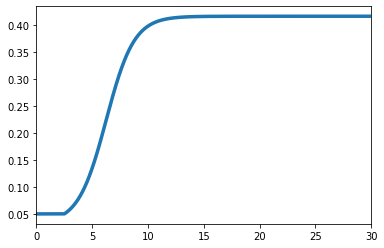

In [ ]:
# plt.plot(t_vec, r1)
plt.plot(t_vec, p)
# plt.plot(t_vec, p1)
plt.xlim(0, 30)

In [ ]:
p[0]

0.05

## Baseline

In [ ]:
base_prams=dict(
  beta= (2/3)*5/2, #r1
  m= 3*m_0,
  alpha= 0.005,
  gamma= 1,
  sigma= 0.35,#0.3,
  tau= 0.25,#0.2,
  kappa=1.5,
  rand='e',

  epsilon= lambda t, qp: 1,
  p= 0,
  
  delta=1,

  t_start=0, 
  dt=0.005,
  t_end=100,

  init=(S0, E0, I0, R0)
)

In [ ]:
baseline=SEIQR(**base_prams)
baseline.run()

In [ ]:
plt.rcParams.update({'font.size': 34})
def basline_plot(x):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9), dpi=350)
  # ax1.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax1.plot(x.t_vector, x.S, label="S", c='b')
  ax1.plot(x.t_vector, x.E, label="E", c='orange')
  ax1.plot(x.t_vector, x.I, label="I", c='r')

  ax1.plot(x.t_vector, x.R, label="R", c='purple')


  title='SEIR Model with no control mechanisms.'
  fig.suptitle(title)

  ax1.set_xlabel('x 10 days')
  ax1.set_ylabel('population')
  ax1.legend(loc='upper right')

  ax2.plot(x.t_vector, x.I, label="I", c='r')
  ax2.plot(x.t_vector, x.E, label="E", c='orange')
 
  # ax2.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax2.set_xlabel('x 10 days')
  
  ax1.set_xlim(0, 80)
  ax2.set_xlim(0, 25)
  ax1.set_ylim(0)
  ax2.set_ylim(0, 0.4)

  ax2.legend(loc='upper right')
  # fig.tight_layout()
  fig.show()
  fig.savefig('fig1.tiff', format='tiff')

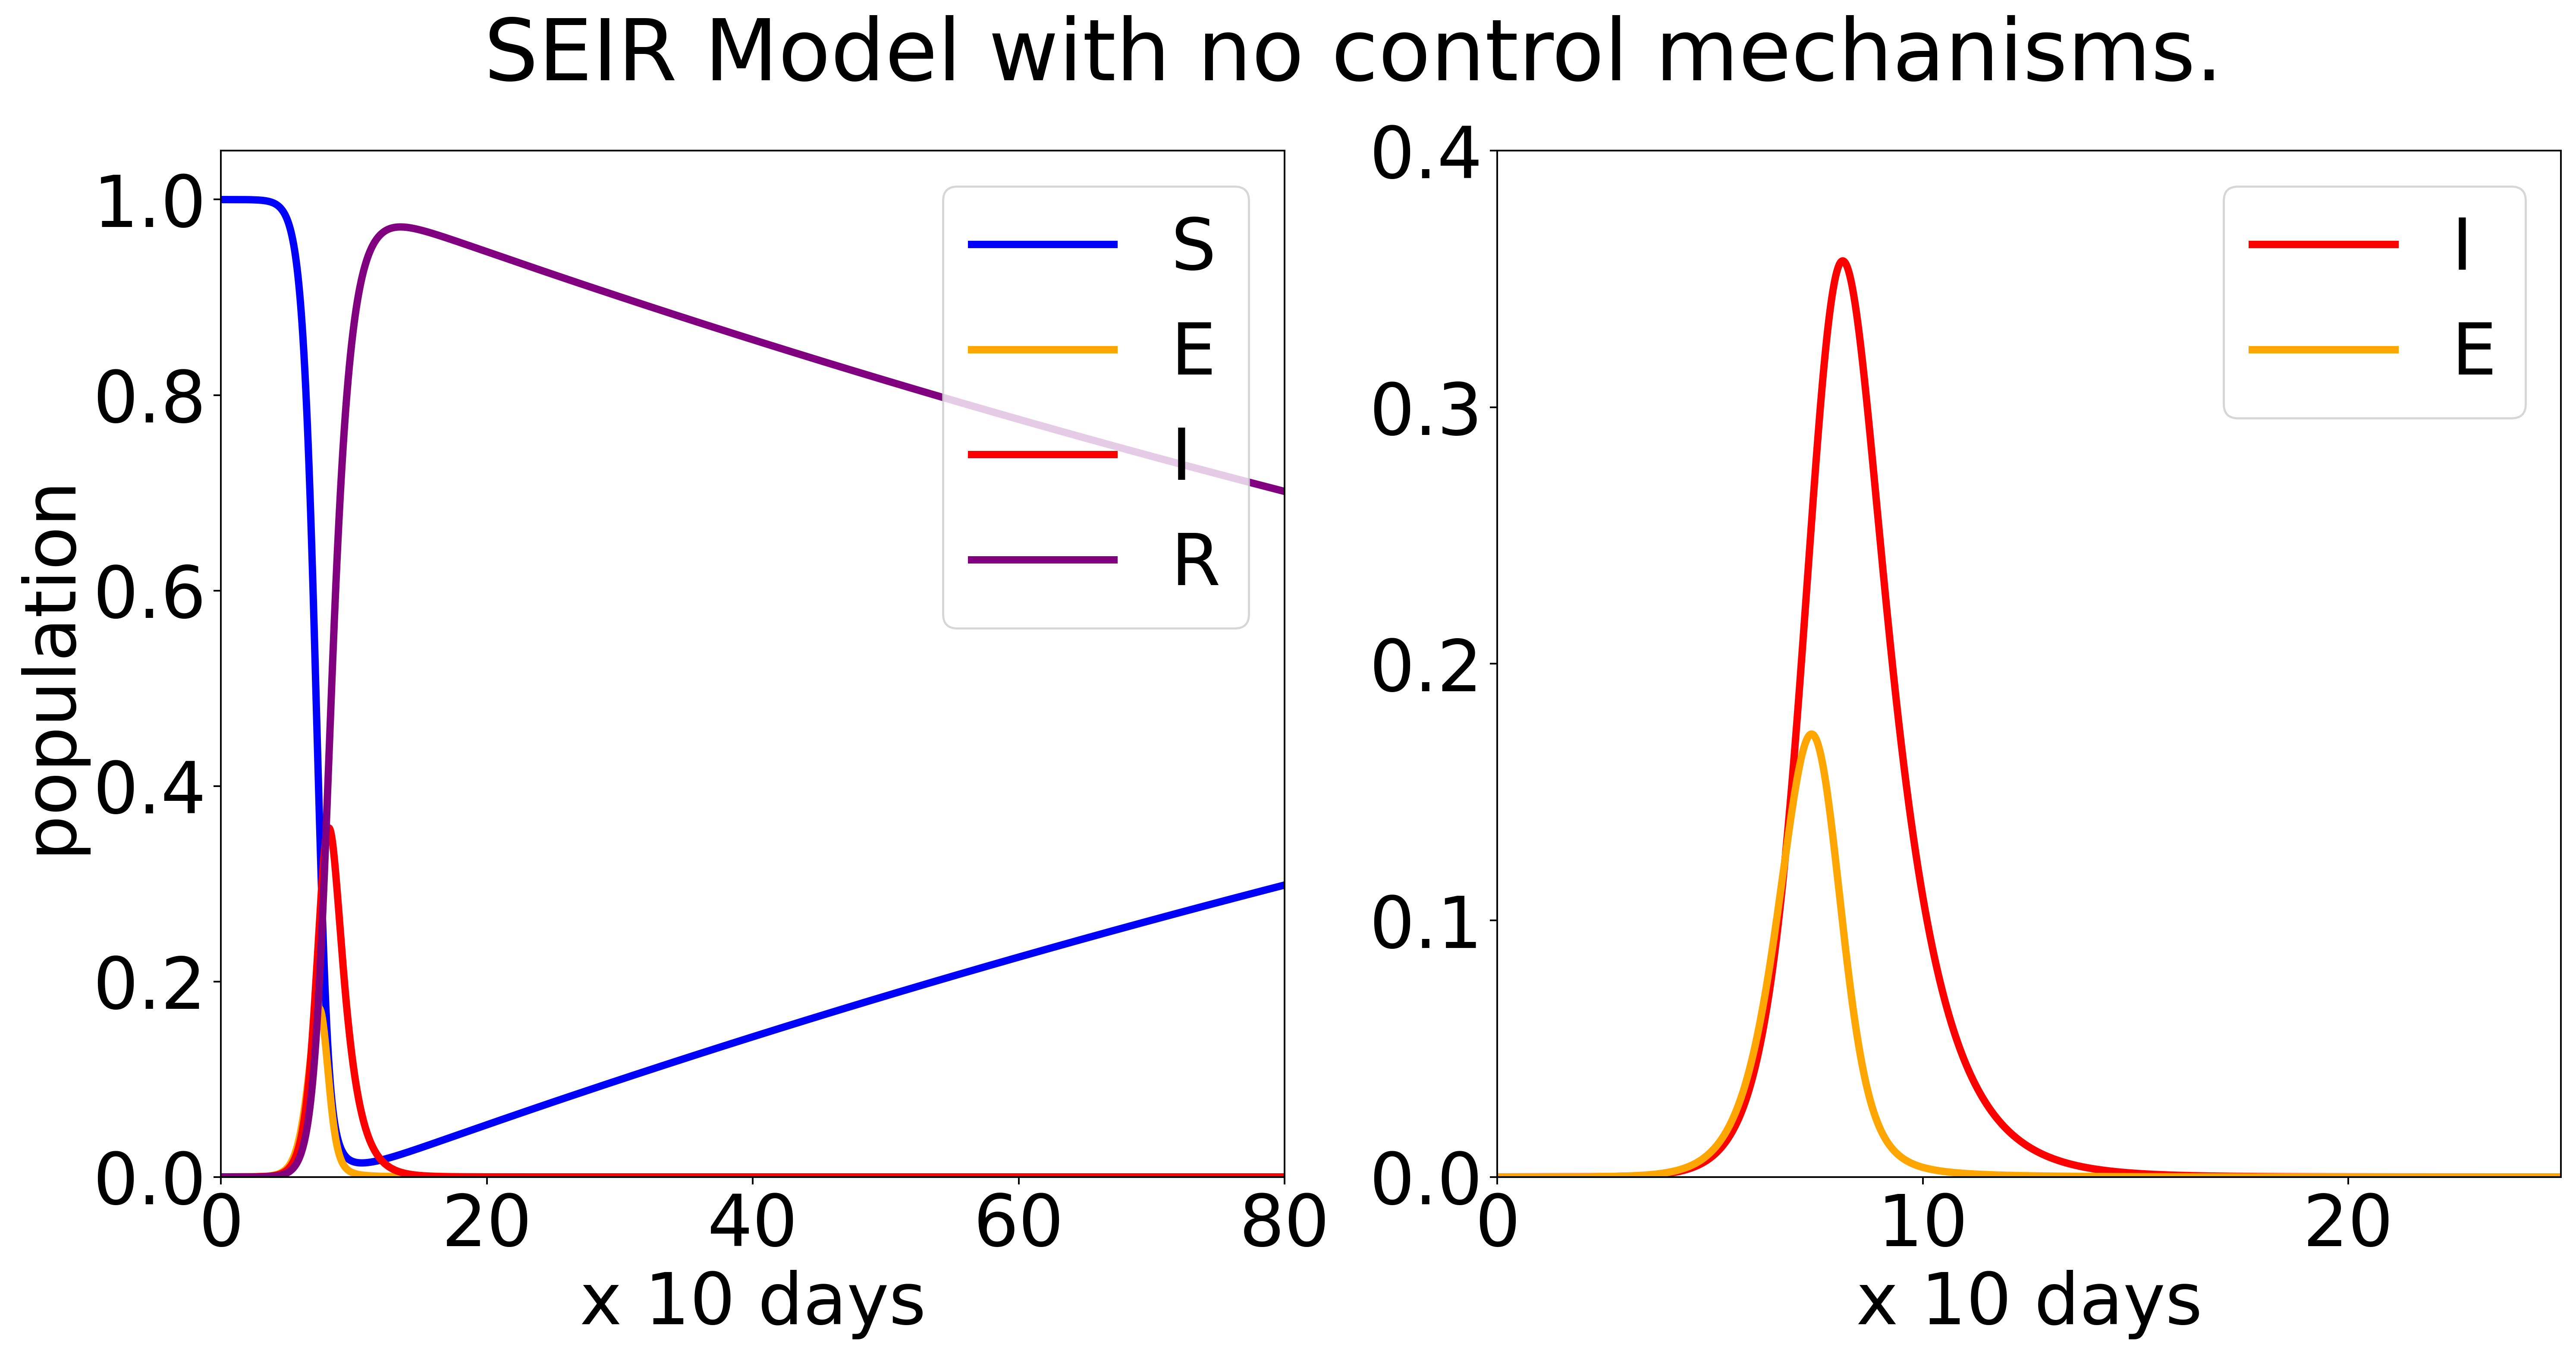

In [ ]:
basline_plot(baseline)

## Initial Lockdown

In [ ]:
lockNhold_prams=dict(
  beta= (2/3)*r1/2, 
  m= 3*m_0,
  alpha= 0.005,
  gamma= 1,
  sigma= 0.35,#0.3,
  tau= 0.25,#0.2,
  kappa=1.5,
  rand='a',

  epsilon= lambda t, qp: 1,
  p= p,

  d_func=lambda t, r, qp, q: 0.3 if np.max(qp)>0.002 else 1,
  d_param='Q+',

  t_start=0, 
  dt=0.005,
  t_end=100,

  init=(S0, E0, I0, R0)
)

In [ ]:
lockNhold=SEIQR(**lockNhold_prams)
lockNhold.run()

In [ ]:
# @markdown initial_lock_plot

def initial_lock_plot(x):
  plt.rcParams.update({'font.size': 34})
  fig, (ax2) = plt.subplots(1, 1, figsize=(10,8), dpi=500)
  plt.rcParams.update({'font.size': 30})
  title='Effect of measures taken to contain the outbreak'# including lockdown'
  fig.suptitle(title)

  ax2.plot(x.t_vector, x.I, label="I", c='r')
  ax2.plot(x.t_vector, x.E, label="E", c='orange')
  ax2.plot(x.t_vector, x.Q, label="Q", c='k')
  # ax2.plot(x.t_vector[x.t0:], x.Qp[x.t0:], label="Q+", c='k', linestyle='dashed')
  # ax2.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  # ax2.axvline(x.t_vector[np.where(x.delta<1)[0][0]],c='g', alpha=0.4)
  ax2.axvline(2.5, c='green', linestyle='dashed', alpha=0.6, label='$t_1$') 
  ax2.axvline(x.t_vector[np.where(x.delta<1)[0][0]], c='green', alpha=0.6, label='$t_2$') 
  


  ax2.set_xlabel('x 10 days')
  # ax2.yaxis.set_ticks(np.arange(0, 0., 0.1))
  ax2.set_xlim(0, 25)

  ax2.set_ylim(0, 0.02)
  ax2.legend(loc='upper right')
  fig.tight_layout()
  fig.show()
  fig.savefig('fig2.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


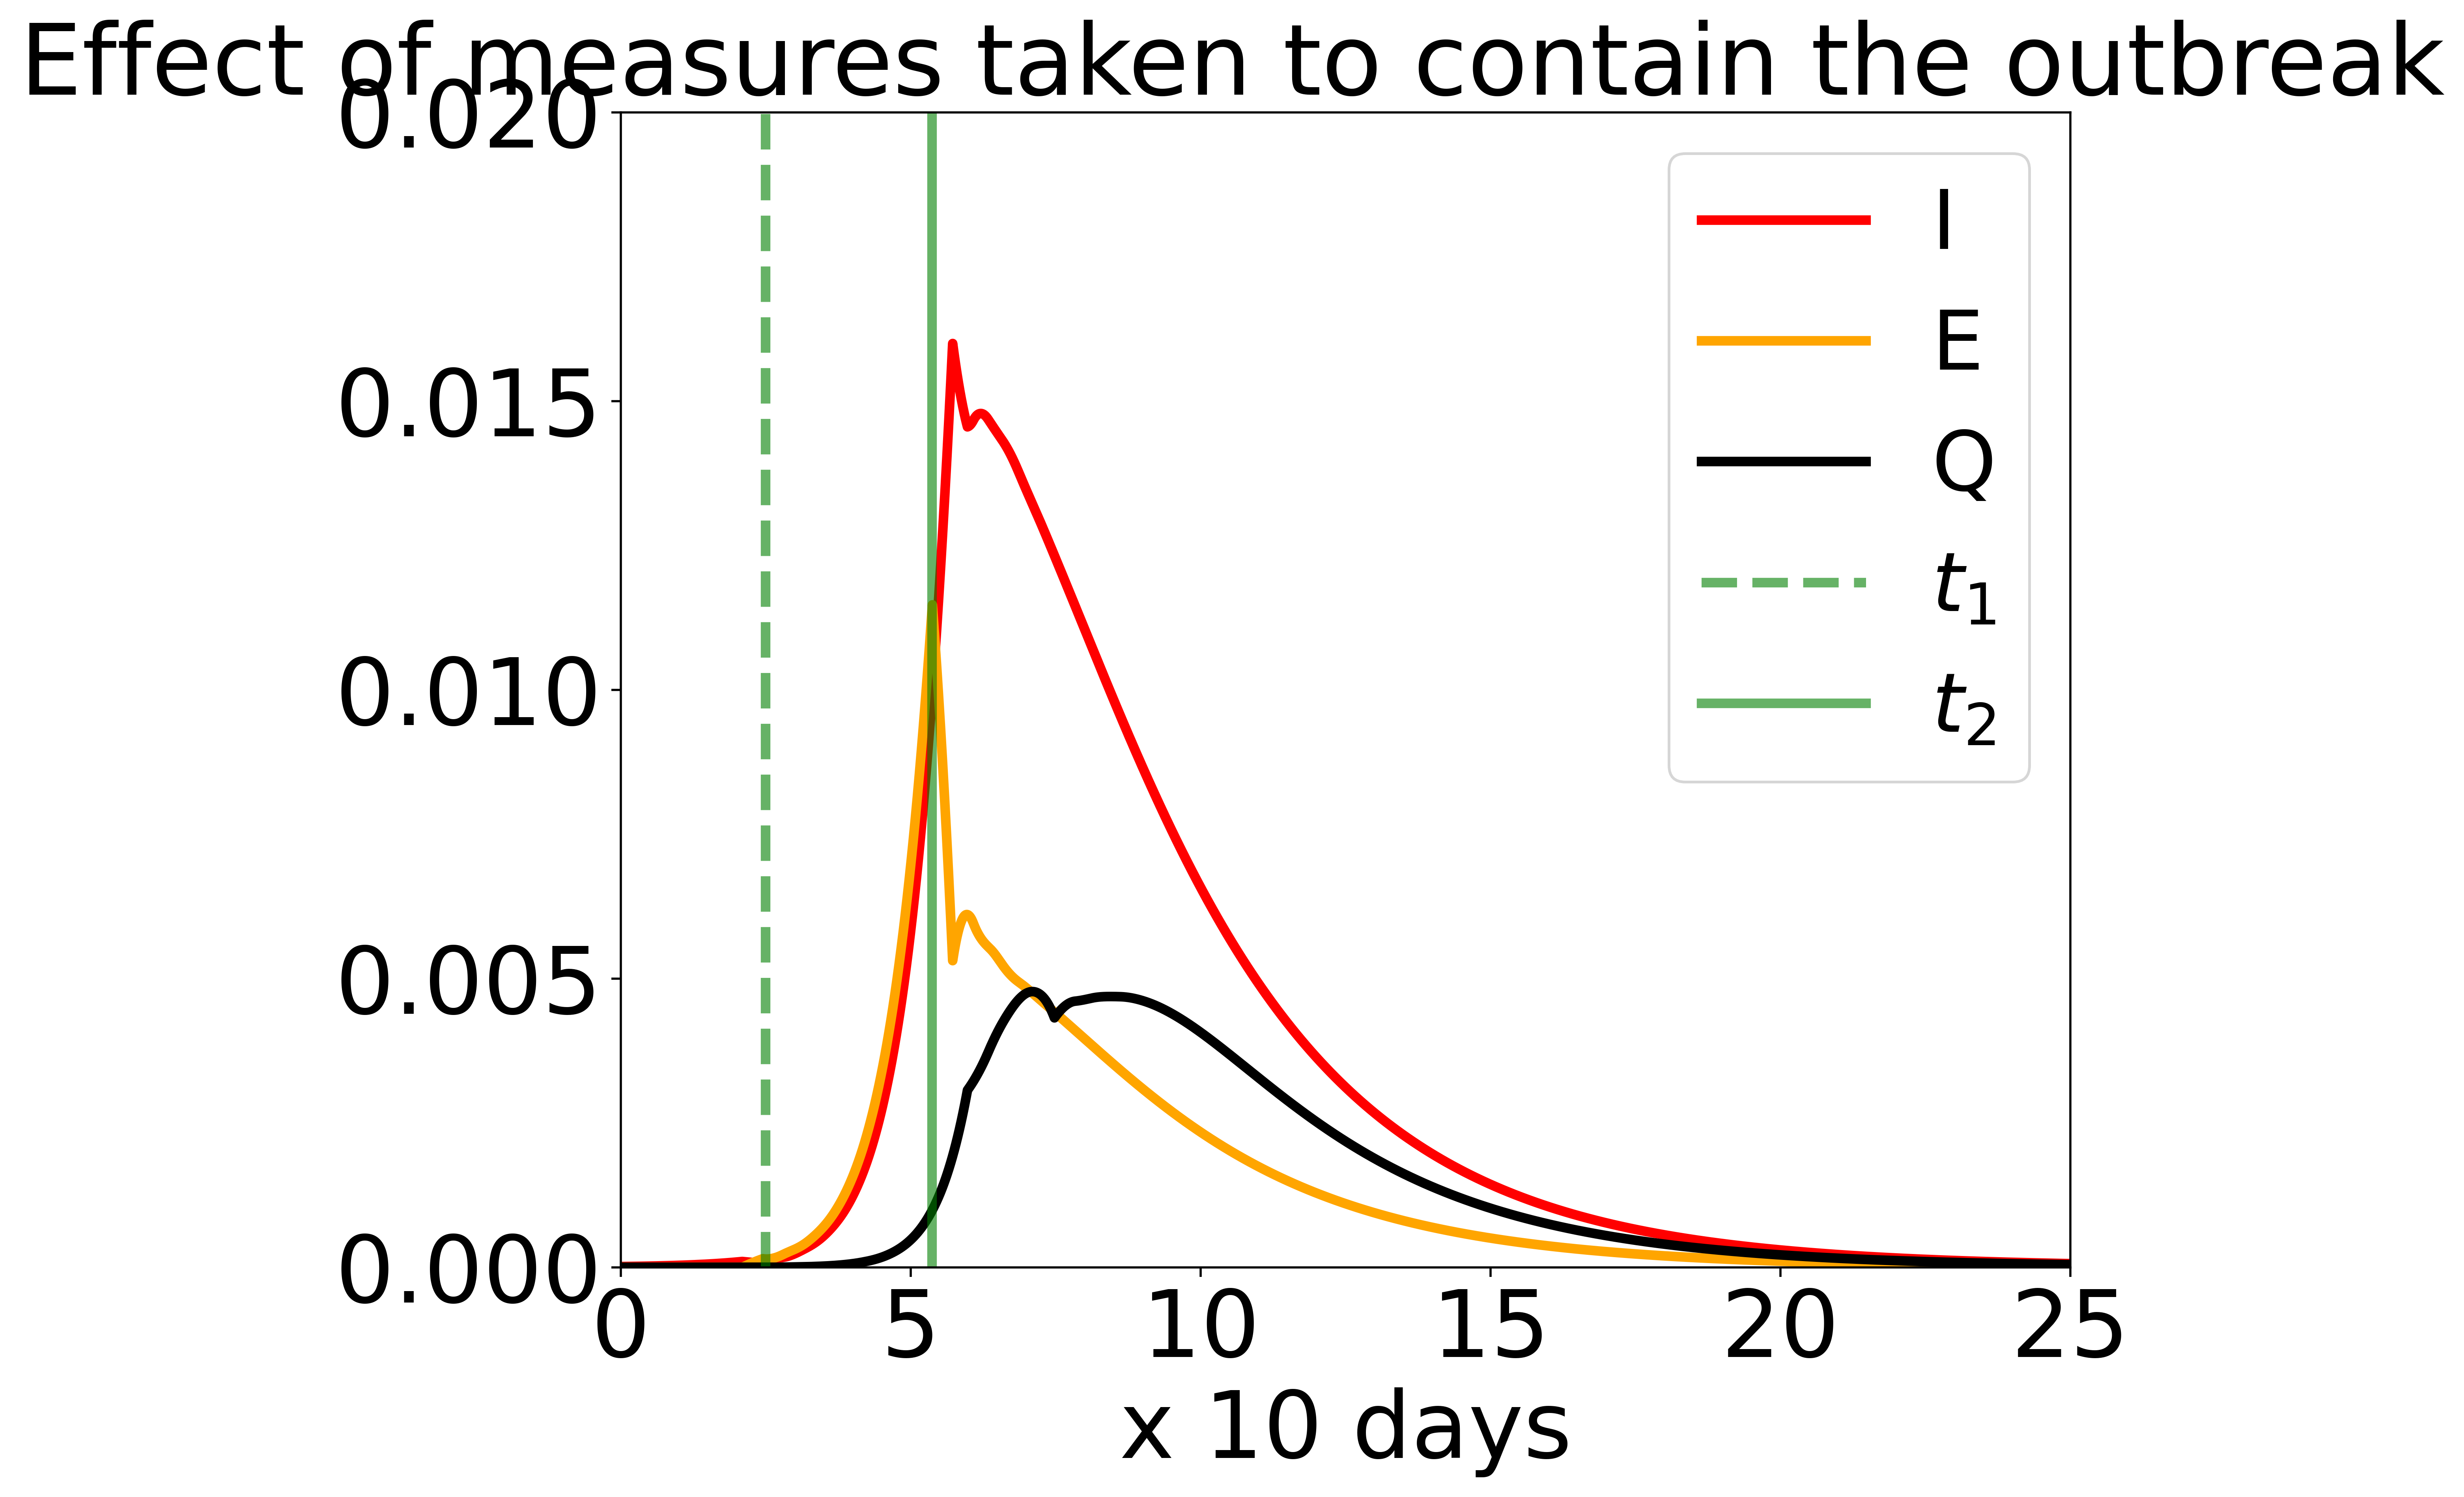

In [ ]:
initial_lock_plot(lockNhold)

In [ ]:
np.max(lockNhold.I)

0.01599536494207903

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [ ]:
# @markdown Singularity Analysis
def singularity_analysis(x):
  plt.rcParams['lines.linewidth'] = 2
  id=np.where(x.delta<1)[0][0]
  tdrop = x.t_vector[id]

  ie=np.where(x.E==np.max(x.E[:int(5.5/x.dt)]))[0][0]
  temax, emax = x.t_vector[ie], x.E[ie]

  iqp=np.where(x.Qp==np.max(x.Qp[:int(6/x.dt)]))[0][0]
  tqpmax, qpmax = x.t_vector[iqp], x.Qp[iqp]

  iqp2=np.where(x.Qp==np.max(x.Qp[iqp+1:int(6.4/x.dt)]))[0][0]
  tqpmax2, qpmax2 = x.t_vector[iqp2], x.Qp[iqp2]

  ii=np.where(x.I==np.max(x.I[:iqp]))[0][0]
  timax, imax = x.t_vector[ii], x.I[ii]

  iq=np.where(x.Q==np.max(x.Q[:int(15/x.dt)]))[0][0]
  tqmax, qmax = x.t_vector[iq], x.Q[iq]

  out = [i if i <lockNhold.Q.shape[0]-1 and lockNhold.Q[i-1]>v and lockNhold.Q[i+1]>v else None for i, v in enumerate(lockNhold.Q)]
  for i, v in enumerate(lockNhold.Q):
    if i <lockNhold.Q.shape[0]-1 and lockNhold.Q[i-1]>v and lockNhold.Q[i+1]>v:
      iqm=i
      break
  tqmin, qmin = x.t_vector[iqm], x.Q[iqm]


  ip=np.where(x.p==np.max(x.p))[0][0]
  tpmax, pmax = x.t_vector[ip], x.p[ip]


  fig, ax =plt.subplots(figsize=(20, 8))
  # fig.patch.set_facecolor('#000000')
  ax.step(x.t_vector, x.E, 'orange', label='E')
  ax.step(x.t_vector, x.I, 'r', label='I')
  ax.step(x.t_vector, x.Q, 'w', label='Q')
  ax.step(x.t_vector, x.Qp, 'w--', label='$Q^+$')


  # ax.set_xlim(1, 20)
  ax.set_xlim(2, 10)
  ax.set_ylim(0, 0.019)

  ax.scatter([temax, timax, tqpmax, tqpmax2], [emax, imax, qpmax, qpmax2], s=500, facecolors='none', edgecolors=['orange', 'r', 'k', 'w', 'w'], )
  ax.annotate('1', xy=(4.8, 0.005), xytext=(temax-0.2, 0.01))
  ax.annotate('2', xy=(4.8, 0.005), xytext=(timax - 0.2, 0.014))
  ax.annotate('3', xy=(4.8, 0.005), xytext=(tqpmax +0.1, 0.0065))
  ax.annotate('4', xy=(4.8, 0.005), xytext=(tqpmax2 -0.15, 0.004))
  # ax.annotate('5', xy=(4.8, 0.005), xytext=(tqmin -0.15, 0.0055))
  ax.axvline(temax, c='orange', alpha=0.6)
  ax.axvline(timax, c='r', alpha=0.6)
  # ax.axvline(tqmin, c='k', alpha=0.6)
  ax.axvline(tqpmax, c='w', linestyle='dashed', alpha=0.6) 
  ax.axvline(tqpmax2, c='w', linestyle='dashed', alpha=0.6) 
  # ax.axvline(5, c='blue', linestyle='dashed', alpha=1, label='linear p') 
  # ax.axhline(0.007, c='r', linestyle='dashed', alpha=0.8, label='$Q^+_{max}$') 
  # ax.axvline(x.t_vector[x.t0],c='k', alpha=0.6, label='$t_1$')
  ax.axvline(2.5, c='green', linestyle='dashed', alpha=0.6, label='$t_1$') 
  ax.axvline(tdrop, c='green', alpha=0.6, label='$t_2$') 
  
  
  plt.rcParams.update({'font.size': 18})
  temp=round((timax-temax)/x.sigma, 3)
  if temp==1:
    ax.annotate('---$\\sigma$---', xy=(x.t_vector[ie], 0.013), xytext=(x.t_vector[ie], 0.017))
  temp=round((tqpmax-timax)/x.tau, 2)
  if temp==1:
    ax.annotate('--$\\tau$--', xy=(4.8, 0.005), xytext=(x.t_vector[ii], 0.0165))
  temp = round((tqpmax2 - tqpmax)/(x.sigma), 1)
  if temp==1:
    ax.annotate('---$\\sigma$---', xy=(5, 0.01), xytext=(tqpmax, 0.017))
  temp = round((tqmin - tqpmax)/(x.t0*x.dt), 2) #/(x.kappa)
  # if temp==1:
    # ax.annotate('--------------------- $t_0$ --------------------', xy=(5, 0.01), xytext=(tqpmax, 0.0075))
  plt.rcParams.update({'font.size': 23})
  # ax.set_ylabel('population')
  ax.set_xlabel('x 10 days')
  ax.legend(loc='upper left', bbox_to_anchor=(0.07, 1))

  # ax2 = plt.axes([0,0,25,0.5])
  # ax2.set_xlim(0,25)
  # ip = InsetPosition(ax, [0.7,0.53,0.28,0.45])
  # ax2.set_axes_locator(ip)

  ax2 = fig.add_axes([0.7,0.58,0.22,0.42])

  ax2.plot(t_vec, p, 'b', label='p')
  ax2.xaxis.set_ticks(np.arange(0, 30, 5))
  ax2.set_xlim(0, 25)
  ax2.legend(loc='lower right')



  fig.suptitle('Singularity Analysis')
  # plt.plot([temax, timax, tqmax, tqpmax], [emax, imax, qmax, qpmax], linestyle='None', marker='o')

In [ ]:
#lockNhold.full_plot()

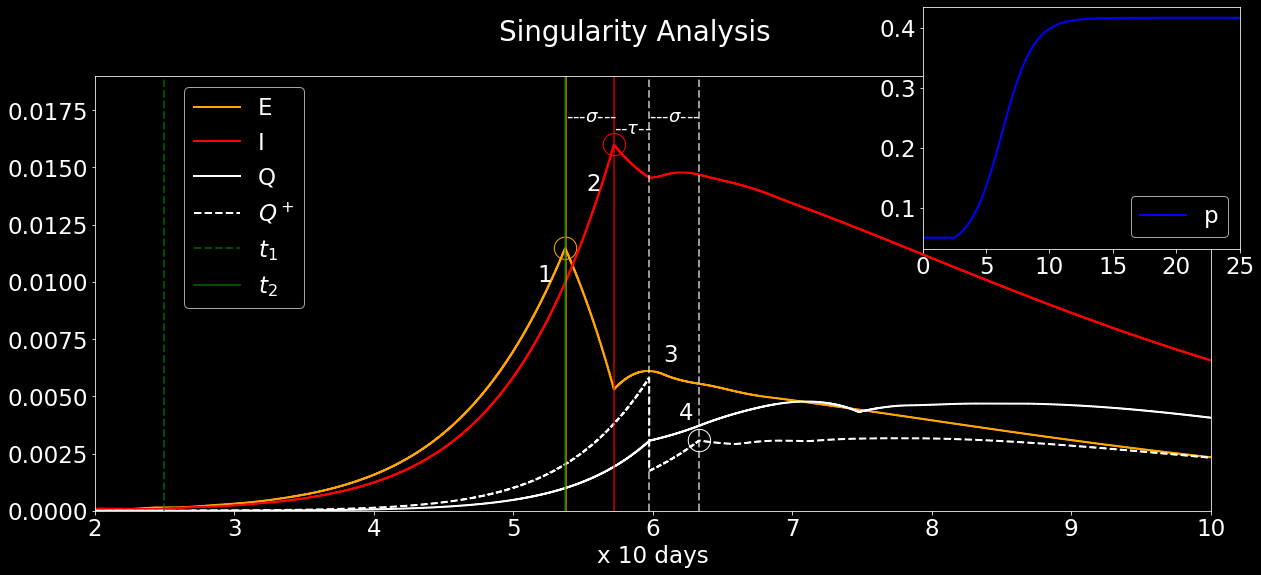

In [ ]:
singularity_analysis(lockNhold)
# plt.rcParams['lines.linewidth'] = 3.5

In [ ]:
x=lockNhold

1.5050000000000001

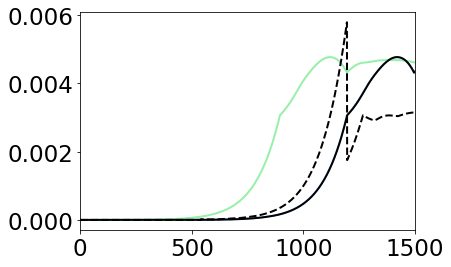

In [ ]:
camp = list(lockNhold.dt*np.cumsum(lockNhold.Qp[int((baseline.kappa)/baseline.dt):]) - baseline.dt*np.cumsum(lockNhold.Qp[:-int((baseline.kappa)/baseline.dt)]))
f = [0]*int(x.kappa/x.dt)
f.extend(camp)
plt.plot(f)
plt.plot(camp)
plt.plot(lockNhold.Q, 'k')
plt.plot(lockNhold.Qp, 'k--')
plt.xlim(0, 1500)
(np.argmax(x.Q) - np.argmax(lockNhold.dt*np.cumsum(lockNhold.Qp[int((baseline.kappa)/baseline.dt):]) - baseline.dt*np.cumsum(lockNhold.Qp[:-int((baseline.kappa)/baseline.dt)])))*x.dt

In [ ]:
2.105 - x.t0*x.dt

0.009999999999999787

In [ ]:
x.t0*x.dt

2.095

## Steering


In [ ]:
steer_smol_prams = dict(
  beta= (2/3)*r1/2,
  m= 3*m_0,
  alpha= 0.005,
  gamma= 1,
  sigma= 0.35,#0.3,
  tau= 0.25,#0.2,
  epsilon= lambda t, qp: 1,
  p= p, 
  kappa=1.5,
  d_param='straight',
  steer_value= 0.001,
  d_func = 1.003,
  r1=r1,
  rand='a',
  sett = False,

  t_start=0, 
  dt=0.005,
  t_end=100,

  init=(S0, E0, I0, R0)
)
steer_smol=SEIQR(**steer_smol_prams)
steer_smol.run()

steer_smol_hiprams = steer_smol_prams
steer_smol_hiprams['d_func'] = 1.02
steer_smol_hi=SEIQR(**steer_smol_hiprams)
steer_smol_hi.run()

steer_smol_loprams = steer_smol_prams
steer_smol_loprams['d_func'] = 0.98
steer_smol_lo=SEIQR(**steer_smol_loprams)
steer_smol_lo.run()

steer_med_prams = steer_smol_prams
steer_med_prams['d_func'] = 1
steer_med_prams['steer_value'] = 0.003
steer_med=SEIQR(**steer_med_prams)
steer_med.run()

steer_big_prams = steer_smol_prams
steer_big_prams['d_func'] = 1
steer_big_prams['steer_value'] = 0.002
steer_big=SEIQR(**steer_big_prams)
steer_big.run()

set
set
set
set
set


In [ ]:
#@title steering plots
# sns.set_color_codes()
def dual(hi, x):
  title='2% above steering formula'
  plt.rcParams.update({'font.size': 20})
  fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(25,8))

  ax1.plot(hi.t_vector, hi.I, label="I", c='r')
  ax1.plot(hi.t_vector, hi.E, label="E", c='orange')
  ax1.plot(hi.t_vector, hi.Q, label="Q", c='w')
  ax1.plot(hi.t_vector[hi.t0:], hi.Qp[hi.t0:], label="Q+", c='w', linestyle='dashed', linewidth=2.5)
  # ax2.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax1.axhline(hi.steer_value, c='b', linestyle='dashed', alpha=0.4)
  ax1.axvline(hi.t_vector[np.where(hi.delta<1)[0][0]],c='g', alpha=0.4)
  ax1.set_xlabel('x 10 days')
  ax1.set_xlim(0, 80)
  ax1.set_ylim(0, 0.01)
  ax1.legend(loc='upper right')
  ax1.set_title(title)

  title='2% below steering formula'
  ax2.plot(x.t_vector, x.I, label="I", c='r')
  ax2.plot(x.t_vector, x.E, label="E", c='orange')
  ax2.plot(x.t_vector, x.Q, label="Q", c='w')
  ax2.plot(x.t_vector[x.t0:], x.Qp[x.t0:], label="Q+", c='w', linestyle='dashed', linewidth=2.5)
  # ax2.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax2.axhline(x.steer_value, c='b', linestyle='dashed', alpha=0.4)
  ax2.axvline(x.t_vector[np.where(x.delta<1)[0][0]],c='g', alpha=0.4)
  ax2.set_xlabel('x 10 days')
  ax2.set_xlim(0, 80)
  ax2.set_ylim(0, 0.01)
  ax2.legend(loc='upper right')
  ax2.set_title(title)
  fig.show()

def steer_smol_plot(x, hi=False, lo=False):
  plt.rcParams.update({'font.size': 34})
  fig, ax1 = plt.subplots(1, 1, figsize=(12,12))
  fig1, ax2 = plt.subplots(1, 1, figsize=(12,12))
  fig2, ax3 = plt.subplots(1, 1, figsize=(12,12))
  # ax1.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax1.plot(x.t_vector, x.S, label="S", c='b')
  ax1.plot(x.t_vector, x.E, label="E", c='orange')
  ax1.plot(x.t_vector, x.I, label="I", c='r')
  ax1.plot(x.t_vector, x.R, label="R", c='purple')  
  title='Steering to balance infection\nand activity upon reopening'
  ax1.set_xlabel('x 10 days')
  ax1.set_ylabel('population')
  ax1.legend(loc='upper right')
  

  ax2.plot(x.t_vector, x.I, label="I", c='r')
  ax2.plot(x.t_vector, x.E, label="E", c='orange')
  ax2.plot(x.t_vector, x.Q, label="Q", c='w')
  ax2.plot(x.t_vector[x.t0:], x.Qp[x.t0:], label="Q+", c='w', linestyle='dashed', linewidth=3)
  # ax2.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax2.axhline(x.steer_value, c='b', linestyle='dashed', alpha=0.4)
  ax2.axvline(x.t_vector[np.where(x.delta<1)[0][0]],c='g', alpha=0.4)
  # ax1.set_title('(a)')
  # ax2.set_title('(b)')
  # ax3.set_title('(c)')
  ax2.set_xlabel('x 10 days')
  ax3.set_xlabel('x 10 days')
  
  ax1.set_xlim(0, 80)
  ax1.set_ylim(0, 1)
  ax2.set_xlim(0, 80)
  ax2.set_ylim(0, 0.01)
  # ax3.set_ylim(0)
  ax3.set_xlim(0, 80)
  ax2.legend(loc='upper right')

  r1 = x.m*x.beta
  r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
  r3 = np.multiply(r2, (1 - x.R - x.Q))
  r4 = np.multiply(r3, x.epsilon_history)
  
  ax3.plot(x.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='slateblue')
  ax3.tick_params(axis='y', labelcolor='slateblue')
  # ax3.plot(x.t_vector[:-1], x.p[:-1], label="$p$", c='blue')
  ax5 = ax3.twinx()
  ax5.step(x.t_vector[:-1], x.delta[:-1], label="$\\delta$", c='g')
  ax5.tick_params(axis='y', labelcolor='g')
  ax3.set_ylim(-0.15, 5.15)
  ax5.set_ylim(-0.05, 1.05)
  ax3.legend(loc='lower left')
  ax5.legend(loc='lower right')
  fig1.suptitle(title)

  fig.show()
  fig1.show()
  fig2.show()

In [ ]:
t2=steer_smol.t_vector[np.where(steer_smol.delta[1:]<steer_smol.delta[:-1])[0][0]]
t3=steer_smol.t_vector[np.where(steer_smol.delta[1:]>steer_smol.delta[:-1])[0][0]]
(t3 - t2)*10

76.2

In [ ]:
t3

12.99

In [ ]:
steer_smol_plot(steer_med)

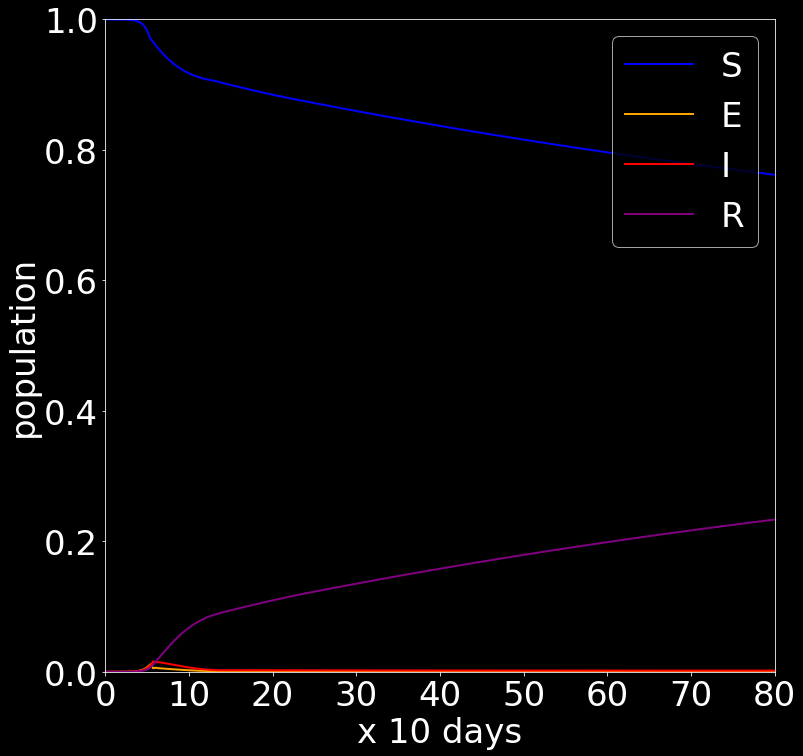

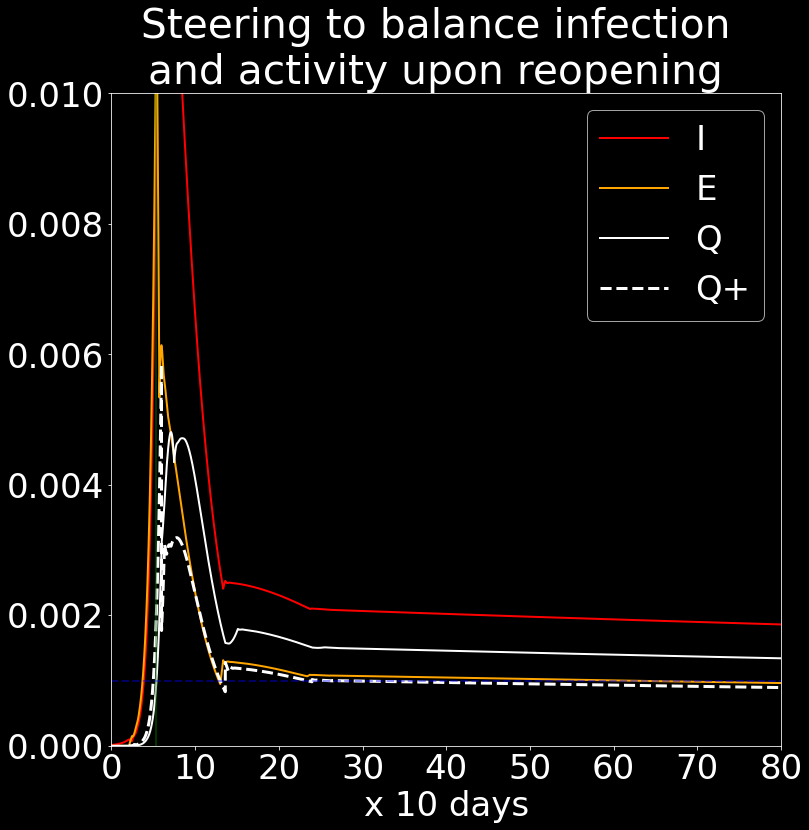

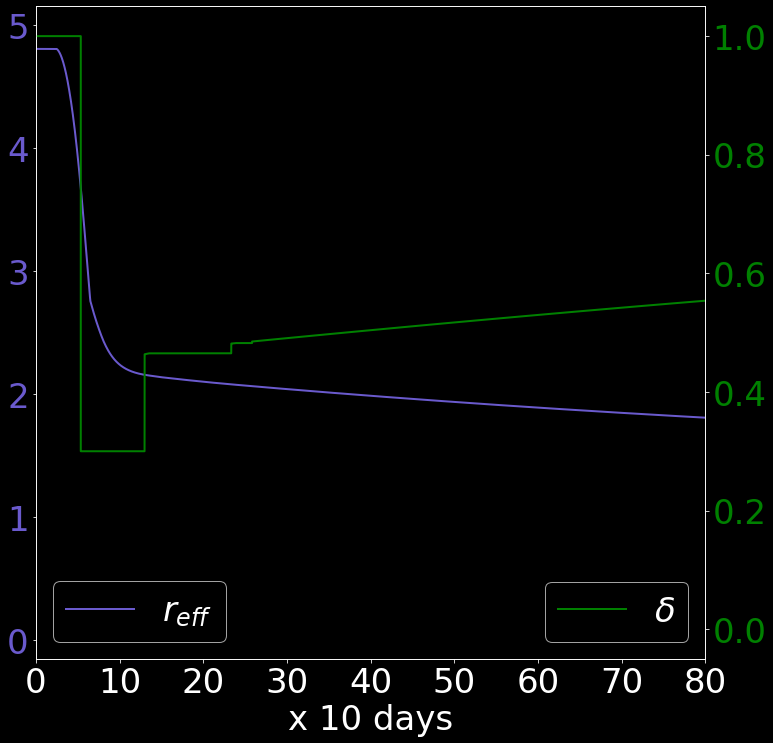

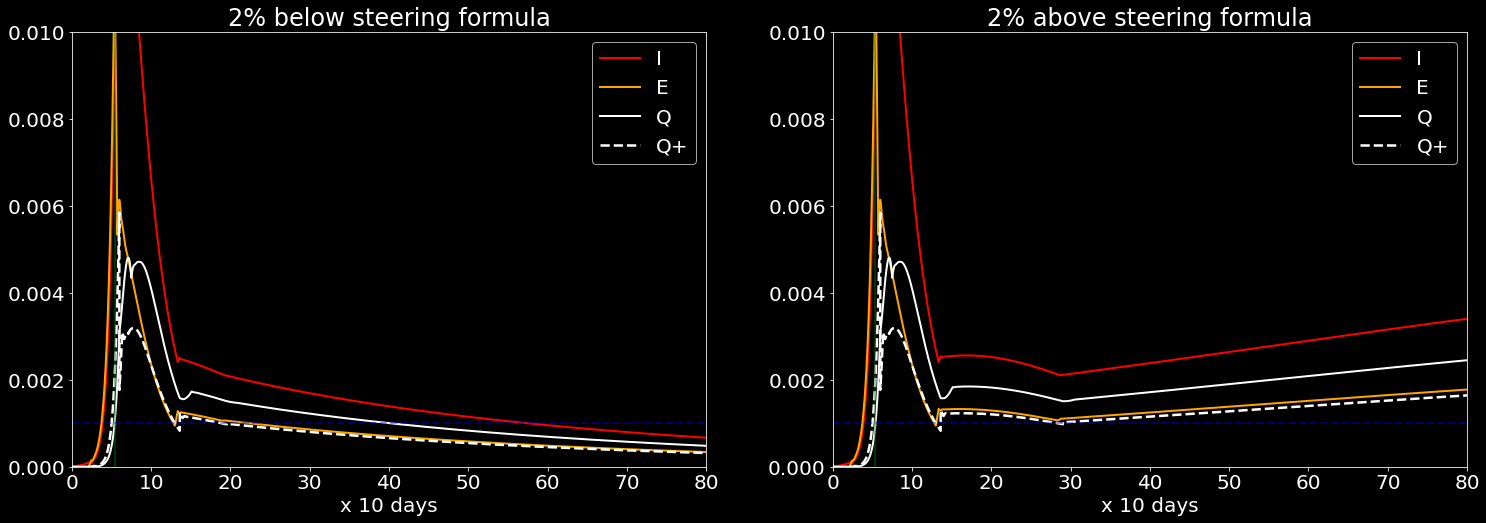

In [ ]:
steer_smol_plot(steer_smol)
dual(steer_smol_hi,steer_smol_lo)


## Stamping

### contact tracing

In [ ]:
qpos = []
dos = []
cc=[]
ef = []
eps = []

r2 = np.multiply(r1, (1 - p*np.exp(-0.25)))

for qpo in [i/100000 for i in range(1, 15)]:
  test=dict(
    beta= (2/3)*r1/2,
    m= 3*m_0,
    alpha= 0.005,
    gamma= 1,
    sigma= 0.35,
    epsilon= lambda t, qp: 1 if t<10 else 1 - 0.5*SEIQR.contact_curve(qp),
    p= p,
    tau= 0.25,
    kappa=1.5,
    d_param='delta_open',
    d_func = 1,
    delta_o=1,
    dld = 0.3,
    qpo=qpo,
    rand='a',

    t_start=0, 
    dt=0.005,
    t_end=100,

    init=(S0, E0, I0, R0)
  )
  x=SEIQR(**test)
  x.run()

  iopen = np.where(x.delta[1:]>x.delta[:-1])[0][0]
  # r3 = np.multiply(r2, (1 - x.R[iopen]))
  r4 = r2*(1 - 0.5*SEIQR.contact_curve(qpo))
  cc.append(SEIQR.contact_curve(qpo))
  qpos.append(qpo)
  dos.append(1/r4[iopen])

  ef.append(r4[iopen])
  eps.append(x.Ep[iopen])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:476: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Activity Capacity by Daily Positive Cases at Opening')

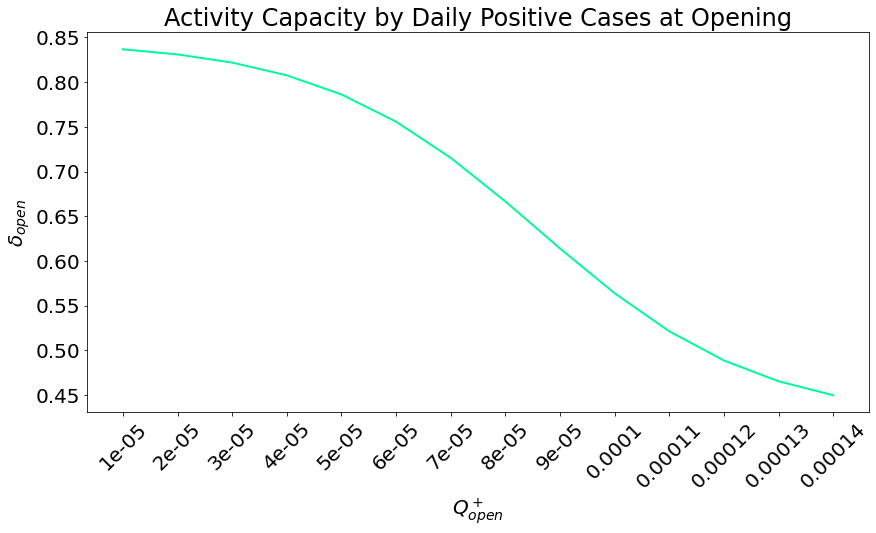

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
# fig.patch.set_facecolor('#000000')
ax.plot(qpos, dos, 'mediumspringgreen', label='$\delta_{open}$')
# ax.plot(qpos, 0.5*np.asarray(cc), 'blue')
ax.set_ylabel('$\delta_{open}$')
ax.set_xlabel('$Q^+_{open}$')
ax.set_xticks(qpos)
ax.set_xticklabels(qpos, rotation=45)
ax.set_title('Activity Capacity by Daily Positive Cases at Opening')

Text(0.5, 1.0, 'r_eff by Daily Positive Cases at Opening')

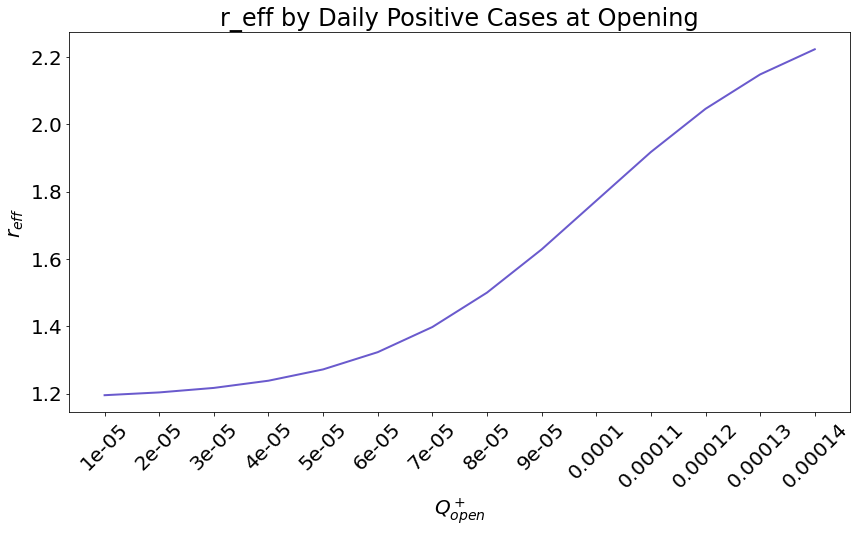

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
# fig.patch.set_facecolor('#000000')
ax.plot(qpos, ef, 'slateblue', label='$r_{eff}$')
# ax.plot(qpos, 0.5*np.asarray(cc), 'blue')
ax.set_ylabel('$r_{eff}$')
ax.set_xlabel('$Q^+_{open}$')
ax.set_xticks(qpos)
ax.set_xticklabels(qpos, rotation=45)
ax.set_title('r_eff by Daily Positive Cases at Opening')

Text(0.5, 1.0, '$E^+$ by Daily Positive Cases at Opening')

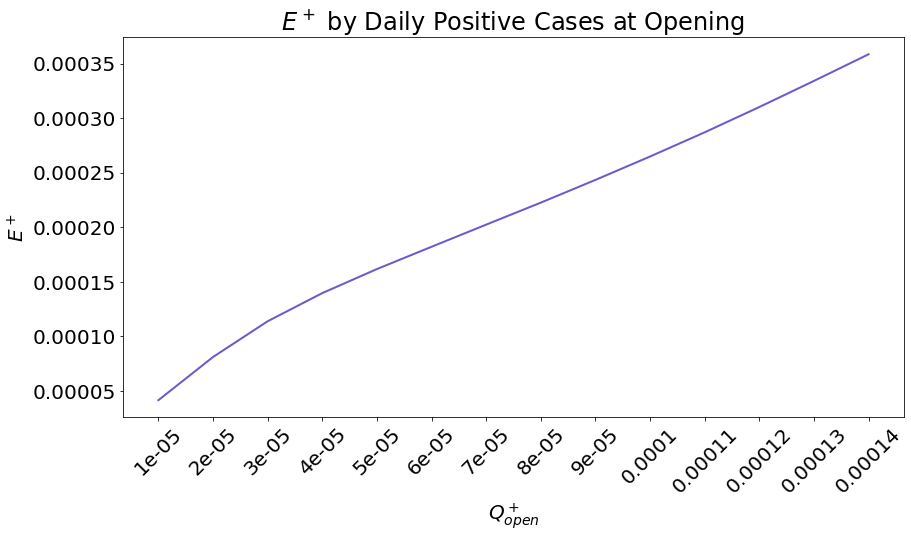

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
# fig.patch.set_facecolor('#000000')
ax.plot(qpos, eps, 'slateblue', label='$E^+$')
# ax.plot(qpos, 0.5*np.asarray(cc), 'blue')
ax.set_ylabel('$E^+$')
ax.set_xlabel('$Q^+_{open}$')
ax.set_xticks(qpos)
ax.set_xticklabels(qpos, rotation=45)
ax.set_title('$E^+$ by Daily Positive Cases at Opening')

### figs

In [ ]:
model2s=[]
for qpo in [0.00001]*19:
  test=dict(
    beta= (2/3)*r1/2,
    m= 3*m_0,
    alpha= 0.005,
    gamma= 1,
    sigma= 0.35,#0.3,
    tau= 0.25,#0.2,
    epsilon= lambda t, qp: 1 if t<10 else 1 - 0.5*SEIQR.contact_curve(qp),
    p= p,
    kappa=1.5,
    d_param='delta_open',
    d_func = 1,
    delta_o=0.9,
    dld=0.3,
    qpo=qpo,
    r1=r1,
    # rand='manual',
    rand='e',
  
    t_start=0, 
    dt=0.005,
    t_end=100,

    init=(S0, E0, I0, R0)
  )
  x=SEIQR(**test)
  x.run()
  model2s.append(x)

In [ ]:
x=model2s[0]
start = x.t_vector[np.where(x.delta[1:]>x.delta[:-1])[0][0]] - 0.5
start

22.85

In [ ]:
#@title stoch_plot

def stoch_plot(x):
  fig, ax1 = plt.subplots(1, 1, figsize=(20,8))
  plt.rcParams.update({'font.size': 25})
  start = x.t_vector[np.where(x.delta[1:]>x.delta[:-1])[0][0]] - 0.5
  dstart = np.where(x.delta[1:]>x.delta[:-1])[0][0]
  end = int(80/x.dt)
  ax1.step(10*x.t_vector-start, 10e6*x.n_history, 'r', label='$X$')
  ax1.vlines(10*start+5, 0, 500, 'g', alpha=0.6, linewidth=1.4)
  ax1.set_xlim(10*start, 800)
  ax1.set_ylim(0, 300)
  ax1.legend(loc='lower right')
  ax1.set_xlabel('days')
  ax1.set_ylabel('# of cases')

  big_day = np.argmax(x.n_history[dstart:end])
  big = 10e6*x.n_history[dstart + big_day]
  # ax1.hlines(big, 0, 800, 'g', alpha=0.6, linewidth=1.4)

  ivec=np.arange(dstart + big_day-int(0.5/x.dt),dstart +big_day+int(5/x.dt), 20)
  tvec=[10*x.t_vector[i]-start for i in ivec]


  qp = np.asarray([10e6*x.dt*np.sum(x.Qp[i:i+20]) for i in ivec])
  # ax2 = plt.axes([0,0,25,0.5])
  ax2 = fig.add_axes([0.73,0.53,0.2,0.45])
  ax2.set_xlim(tvec[0]-1, tvec[-1]+1)
  # ip = InsetPosition(ax1, [0.7,0.53,0.28,0.45])
  # ax2.set_axes_locator(ip)
  ax2.bar(tvec, qp, label='Q+', color='k')
  ax2.axhline(qp[-1], color='slateblue', linestyle='dashed', linewidth=1.3)
  
  ax2.legend()
  ax1.indicate_inset([tvec[0], 0, 50, np.max([big, 250])], inset_ax=ax2, edgecolor='purple')


  iz = np.asarray([10e6*x.I[i] for i in ivec])
  ax3 = fig.add_axes([0.45,0.53,0.2,0.45])
  # ax3 = plt.axes([0,0,25,0.5])
  ax3.set_xlim(tvec[0]-1, tvec[-1]+1)
  ax3.set_ylim(bottom=0.6*np.min(iz), top=1.1*np.max(iz))
  # ip2 = InsetPosition(ax1, [0.3,0.53,0.28,0.45])
  # ax3.set_axes_locator(ip2)
  ax3.bar(tvec, iz, label='I', color='lightcoral')
  
  ax3.legend()
  ax1.indicate_inset([tvec[0], 0, 50, np.max([big, 250])], inset_ax=ax3, edgecolor='purple')

  fig.show()

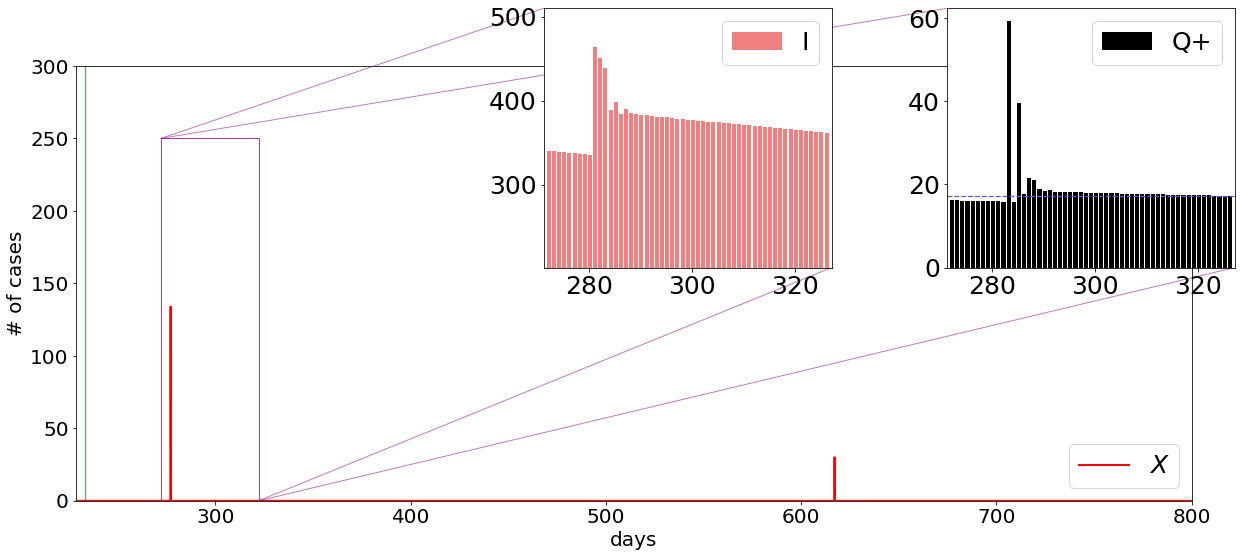

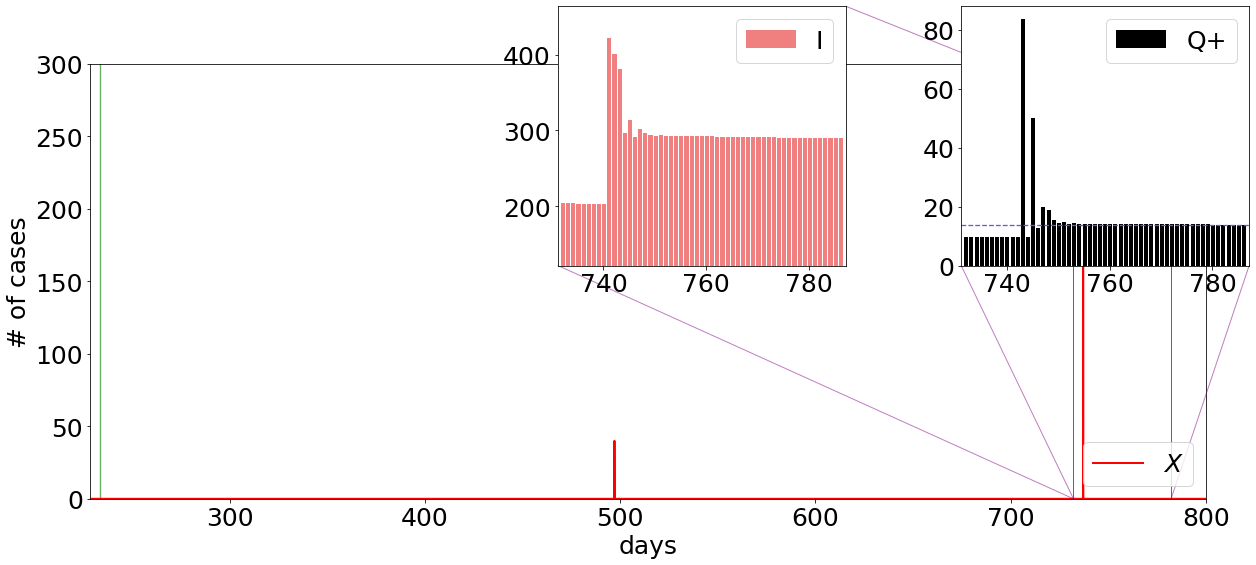

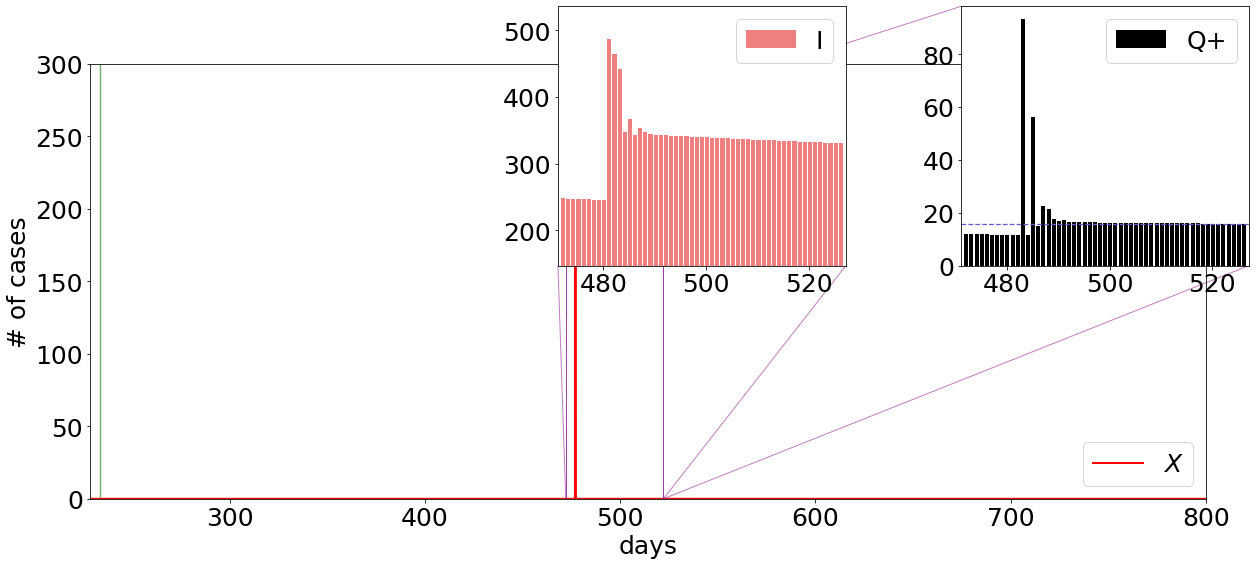

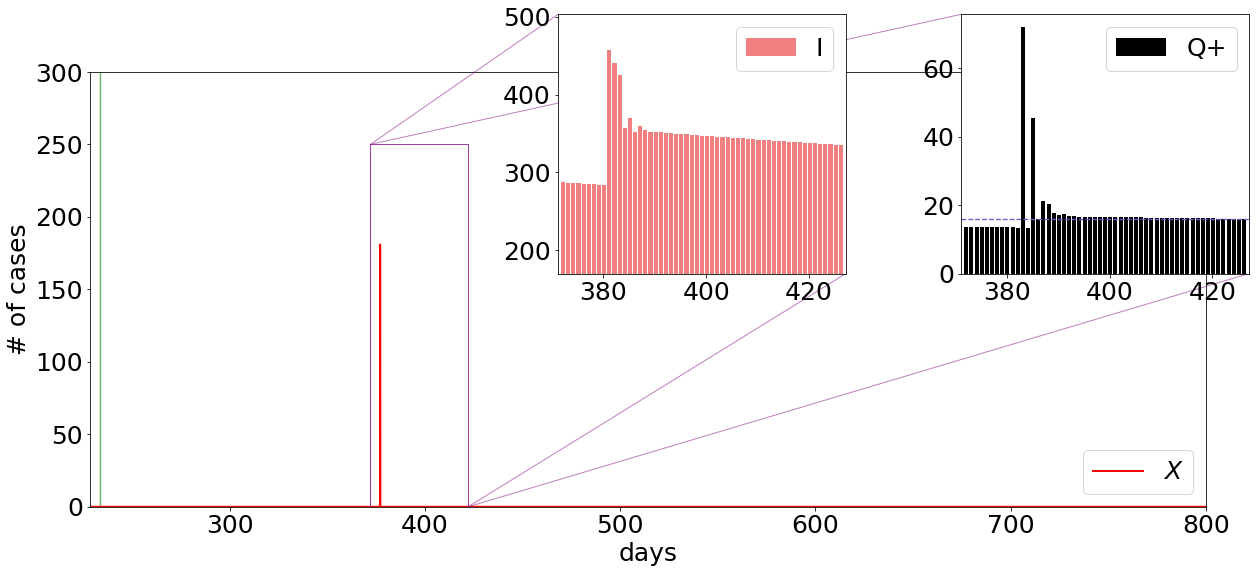

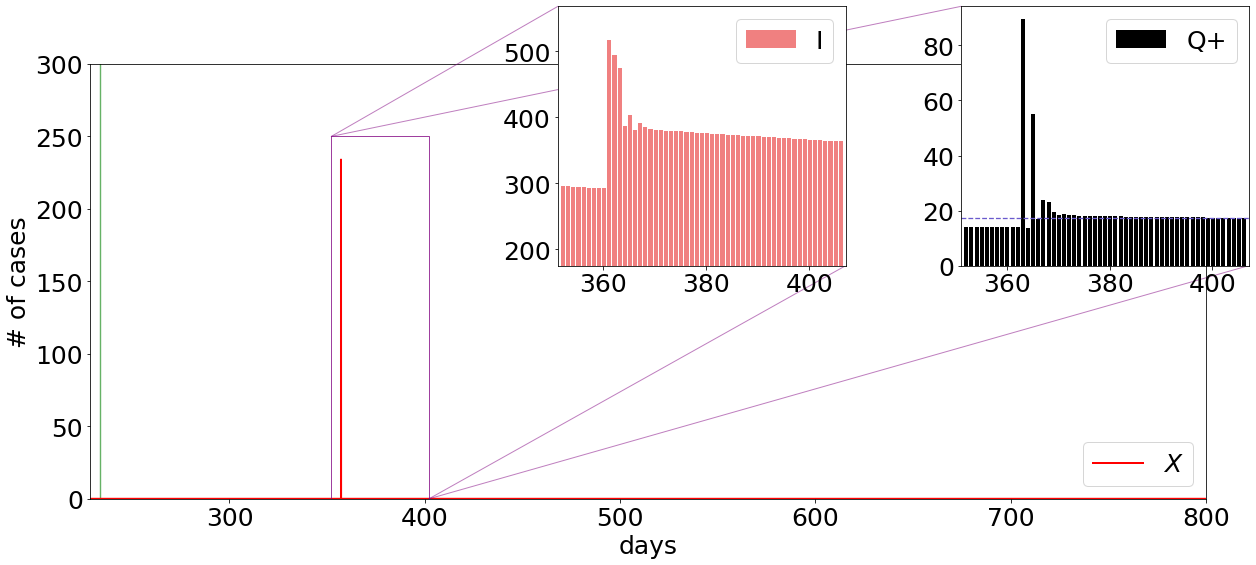

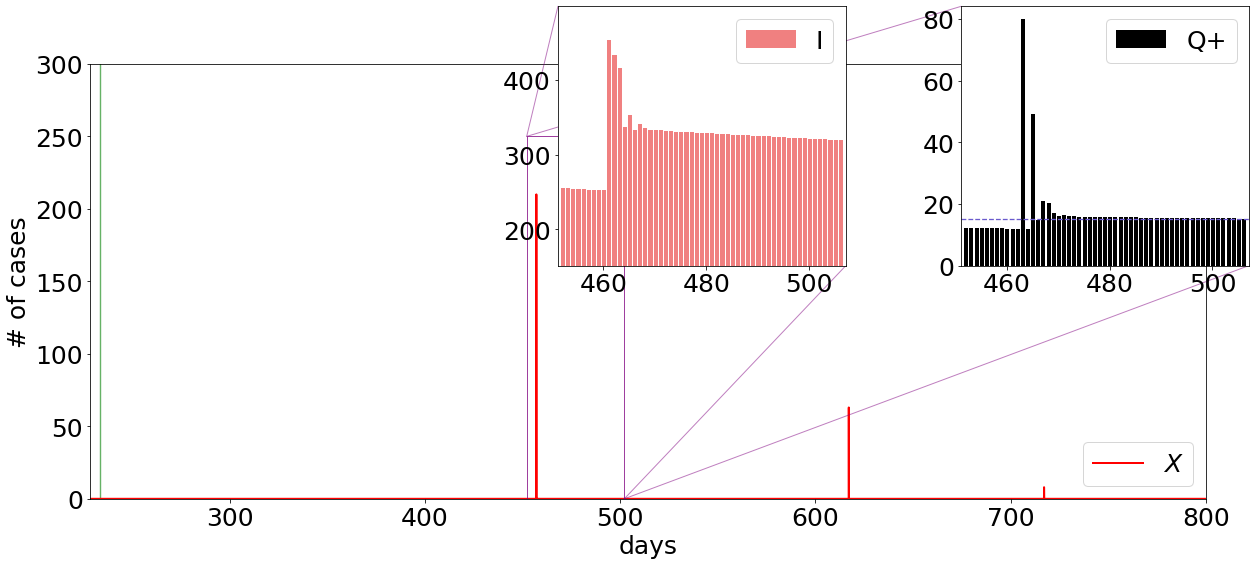

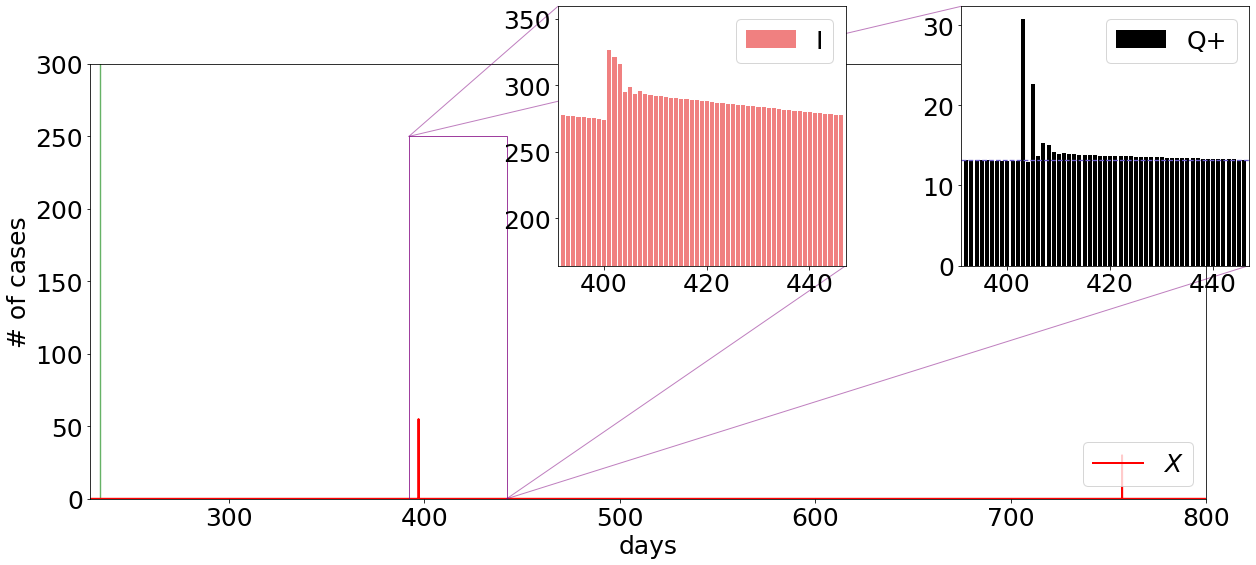

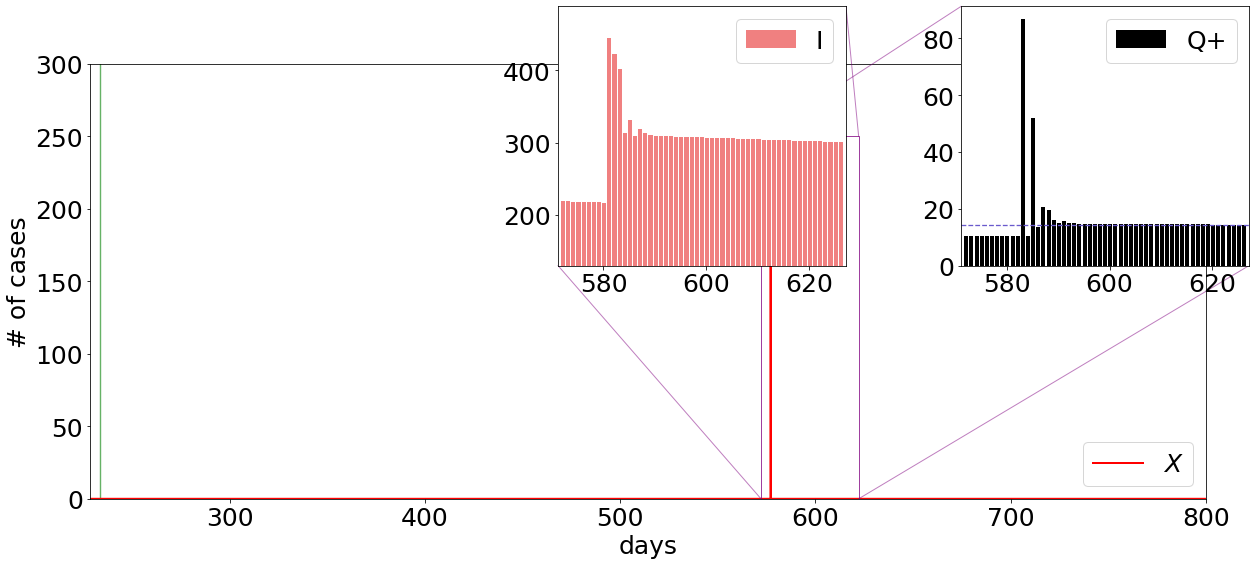

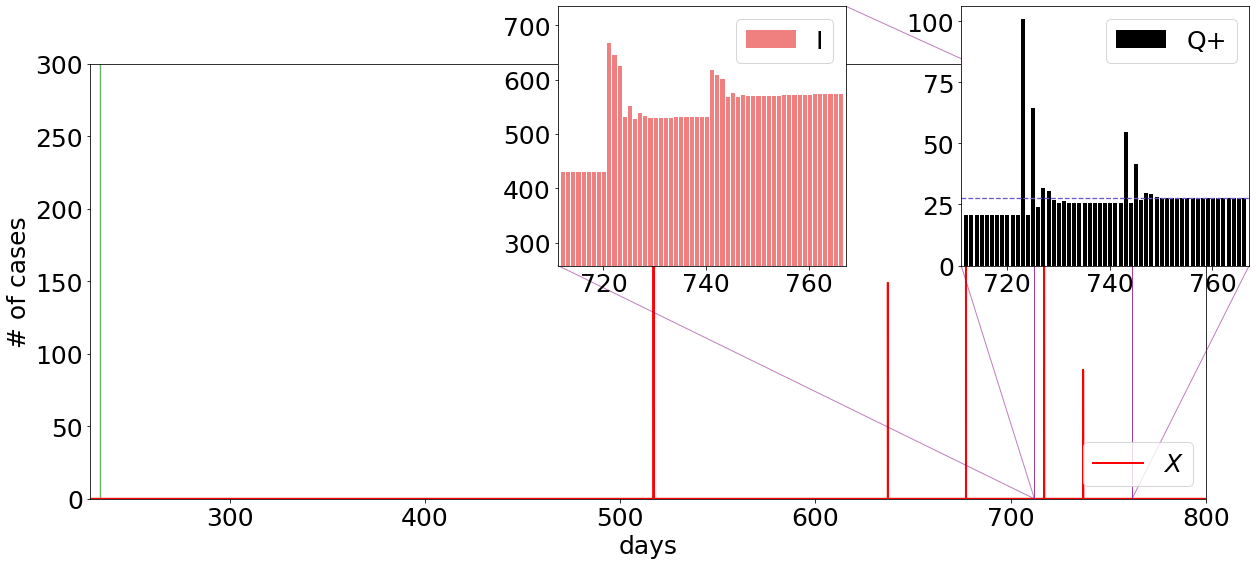

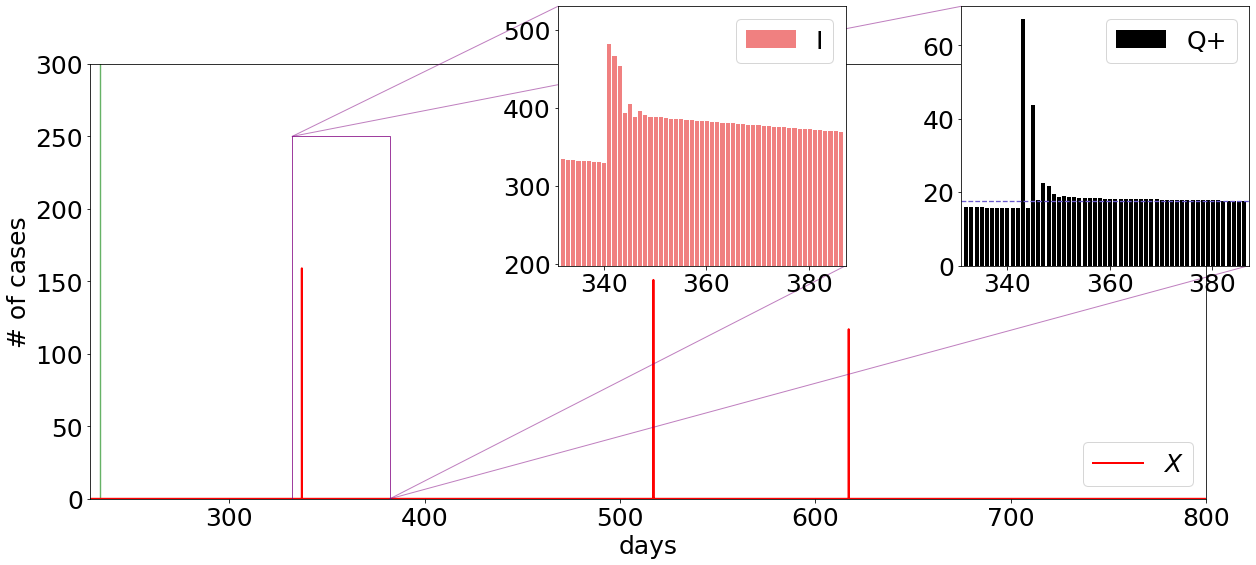

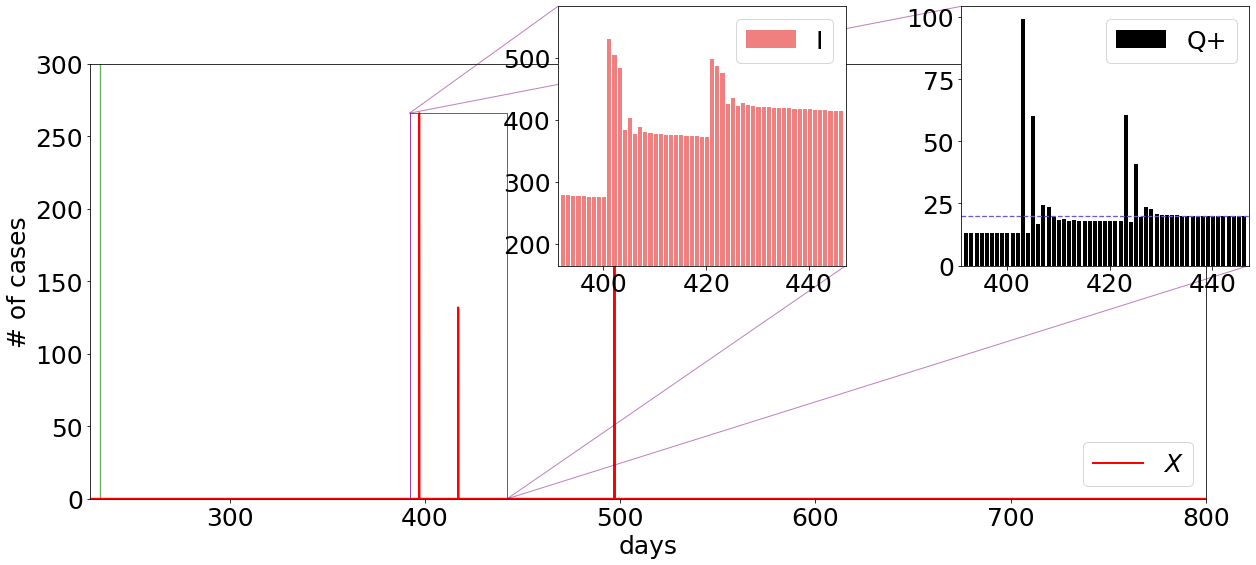

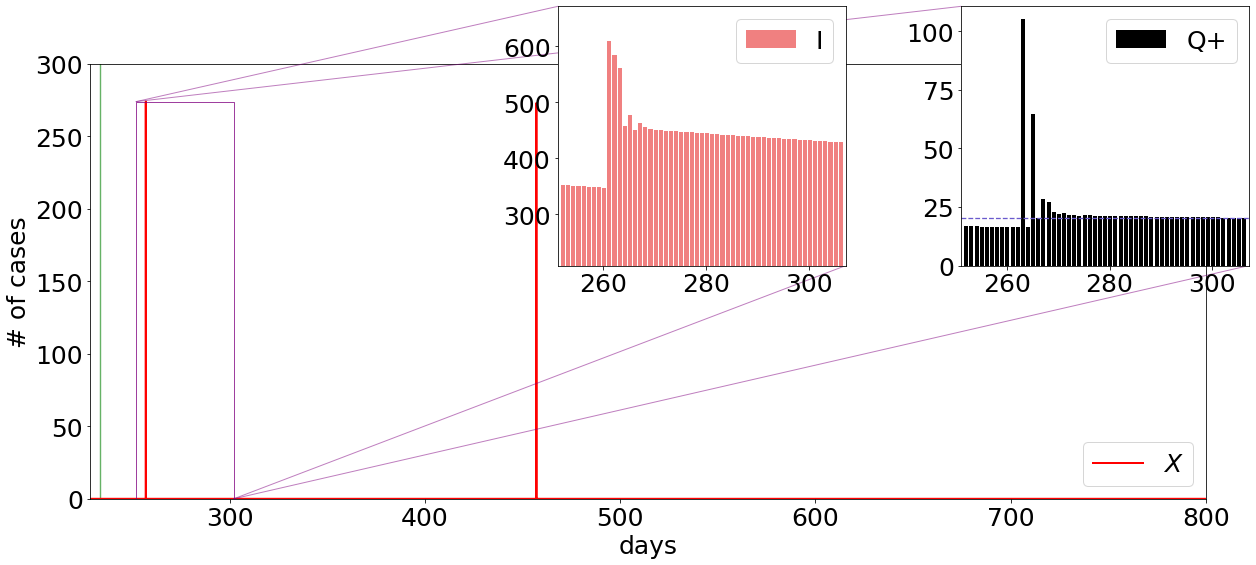

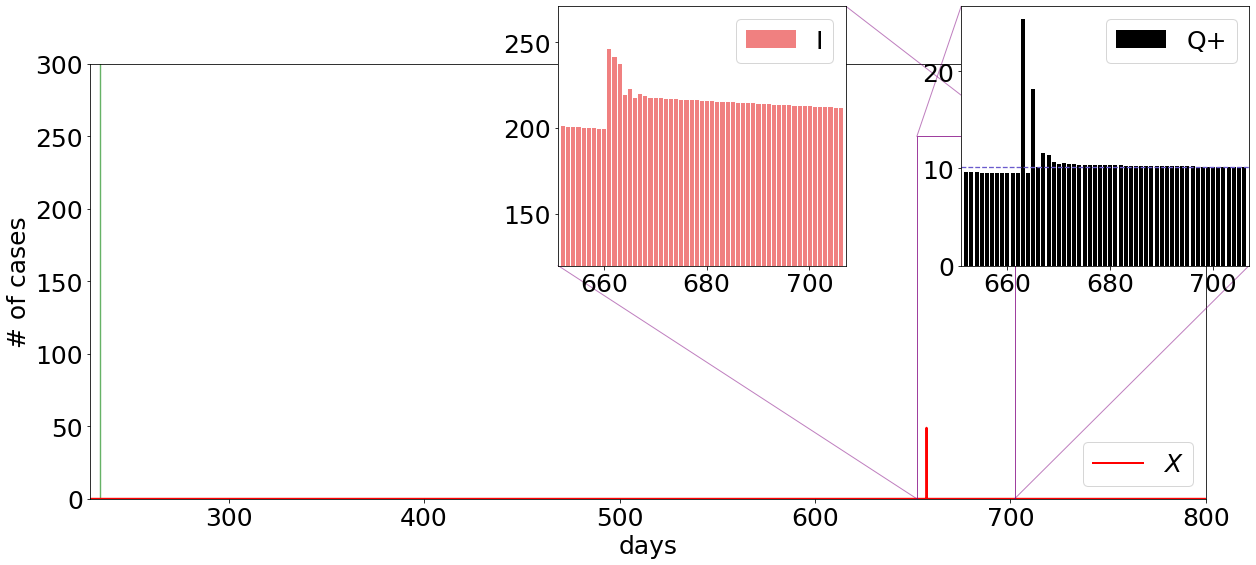

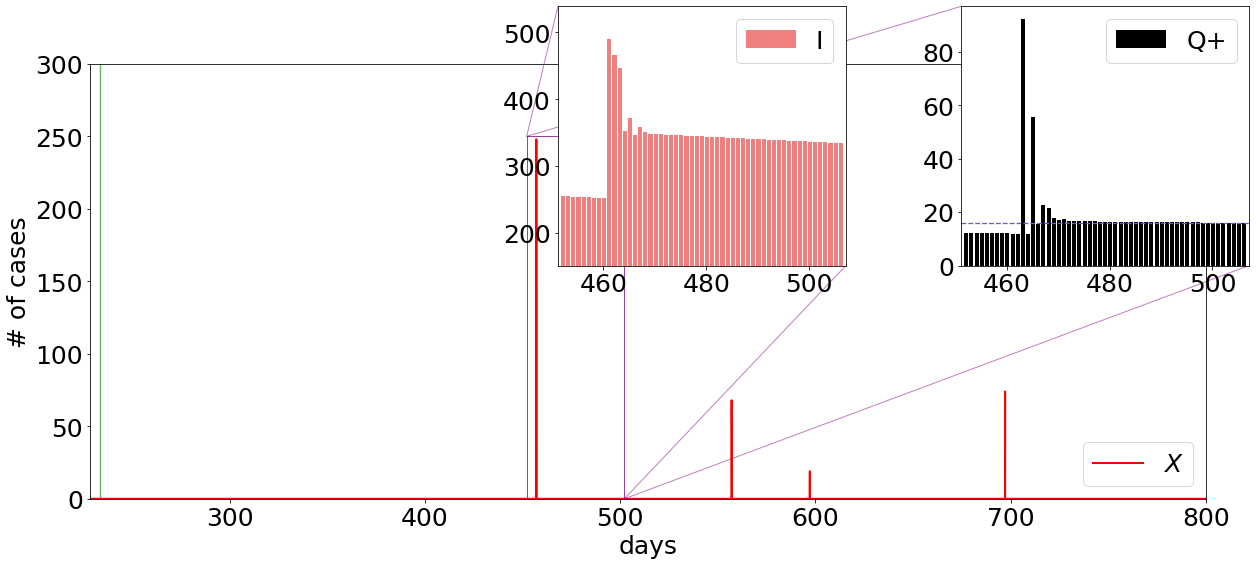

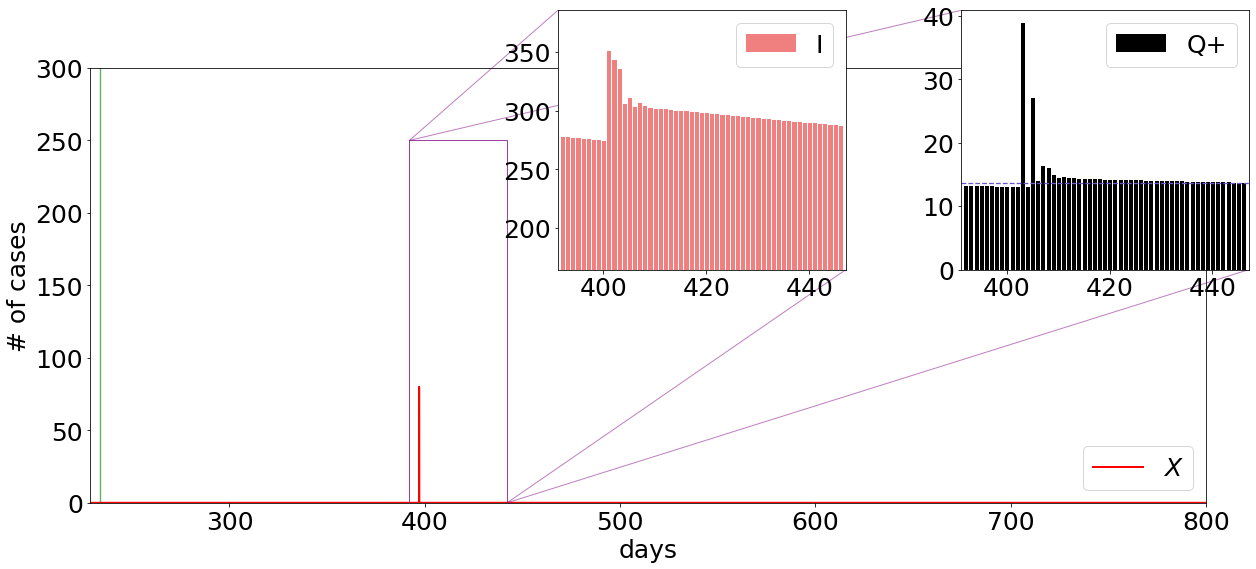

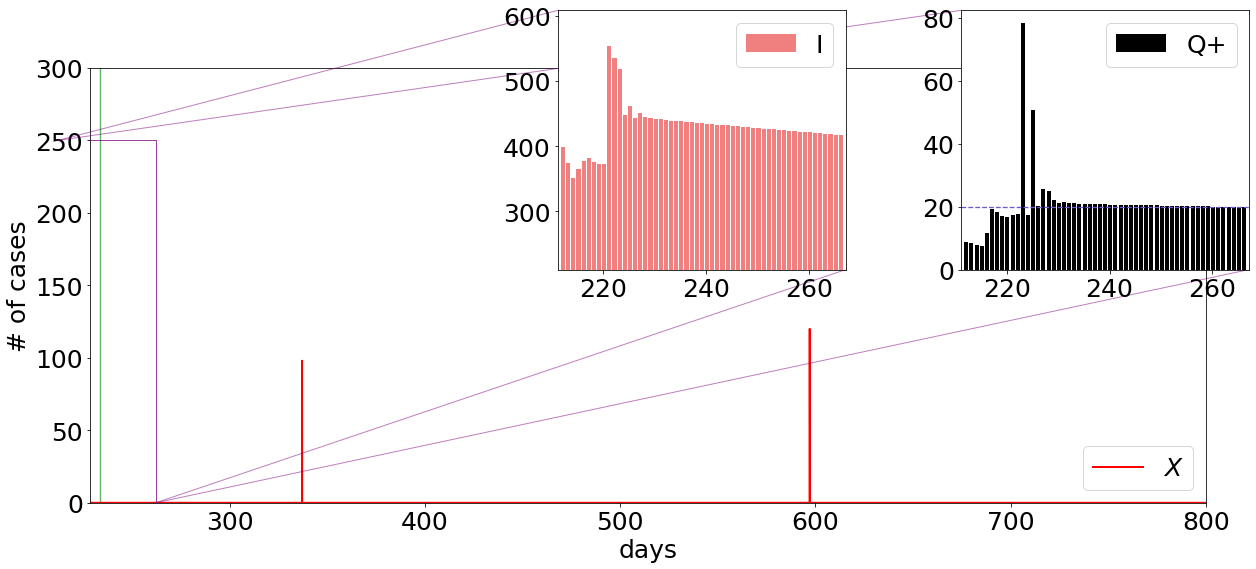

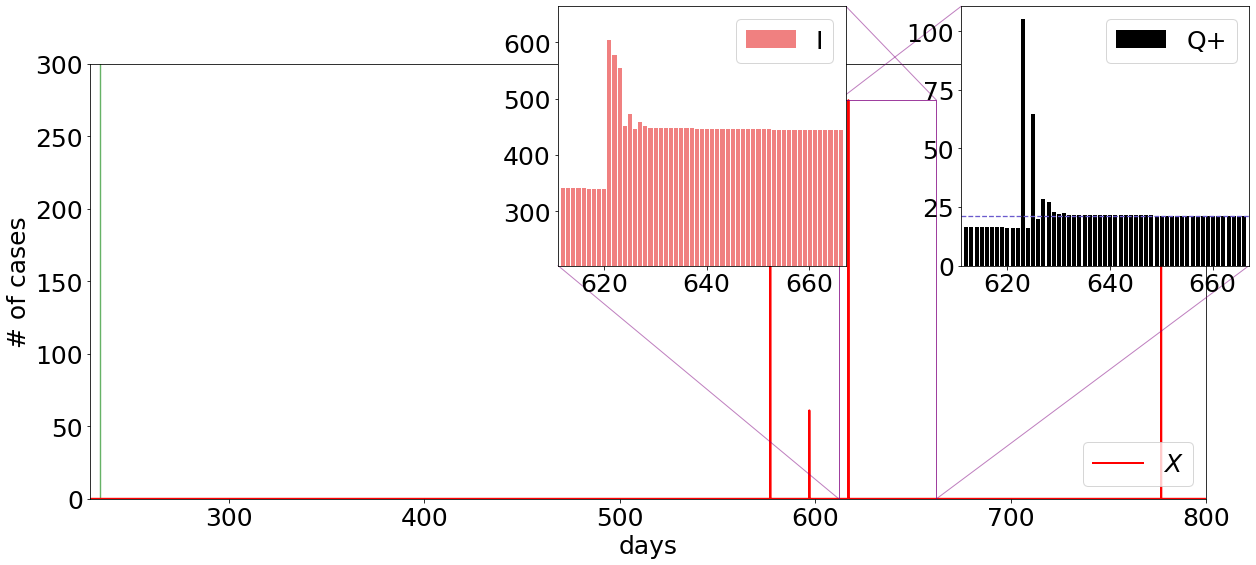

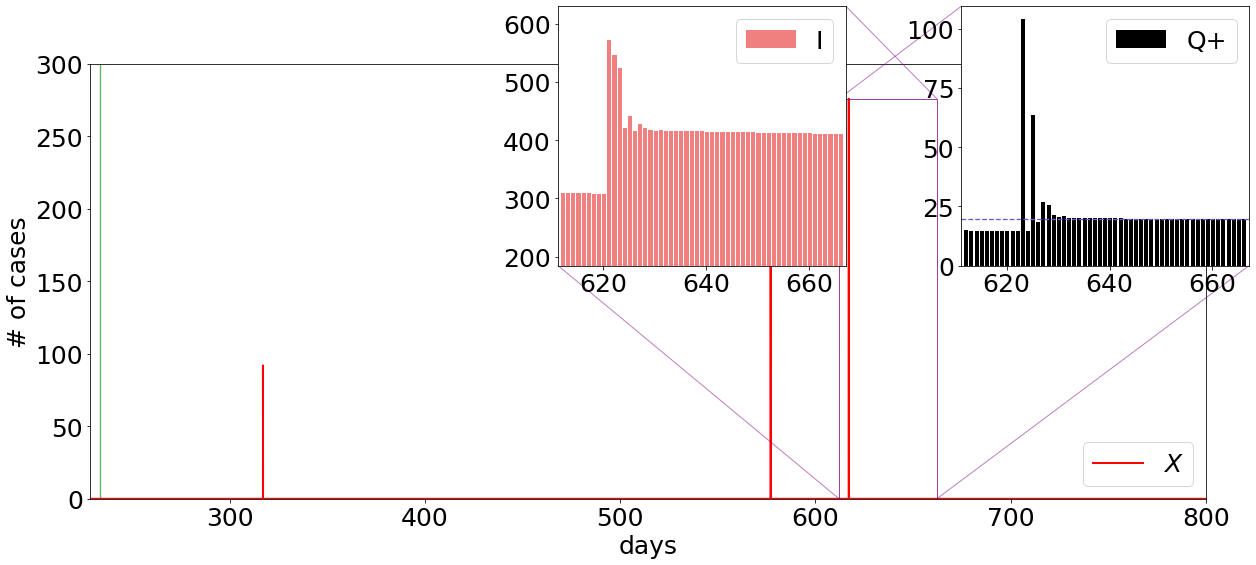

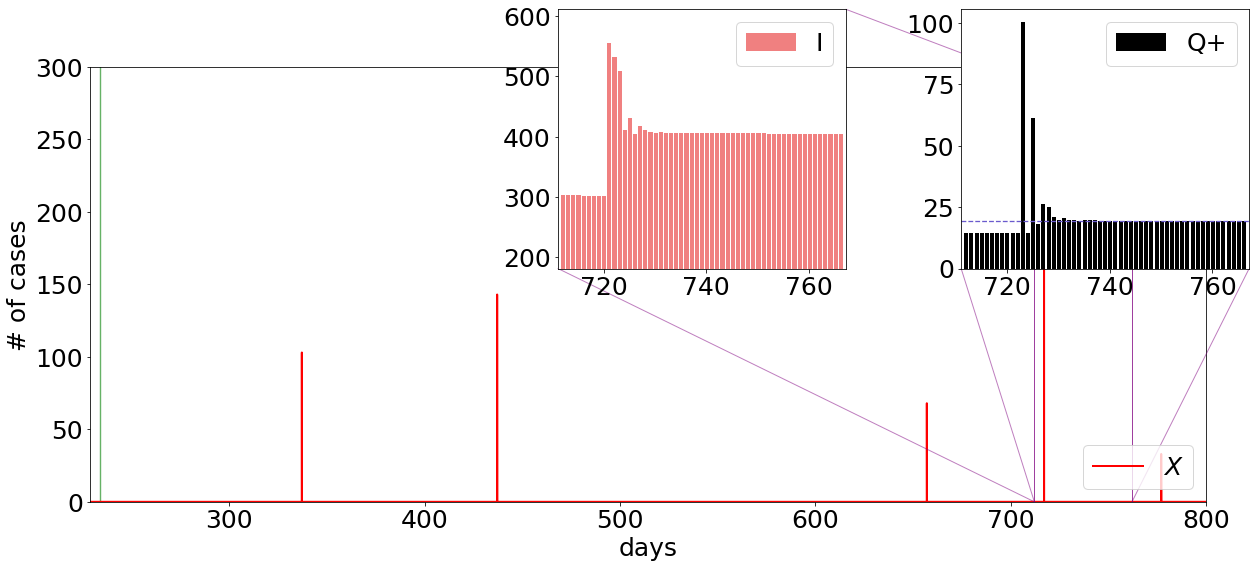

In [ ]:
for x in model2s:
  stoch_plot(x)

#### Histograms

In [ ]:
test=dict(
  beta= (2/3)*r1/2,
  m= 3*m_0,
  alpha= 0.005,
  gamma= 1,
  sigma= 0.35,#0.3,
  tau= 0.25,#0.2,
  epsilon= lambda t, qp: 1 if t<10 else 1 - 0.5*SEIQR.contact_curve(qp),
  p= p,
  kappa=1.5,
  d_param='delta_open',
  d_func = 1,
  delta_o=0.9,
  dld=0.3,
  qpo=0.00001,
  # r1=r1,
  # rand='manual',
  rand='a',

  t_start=0, 
  dt=0.005,
  t_end=100,

  init=(S0, E0, I0, R0)
)
ct_tracer=SEIQR(**test)
ct_tracer.run()

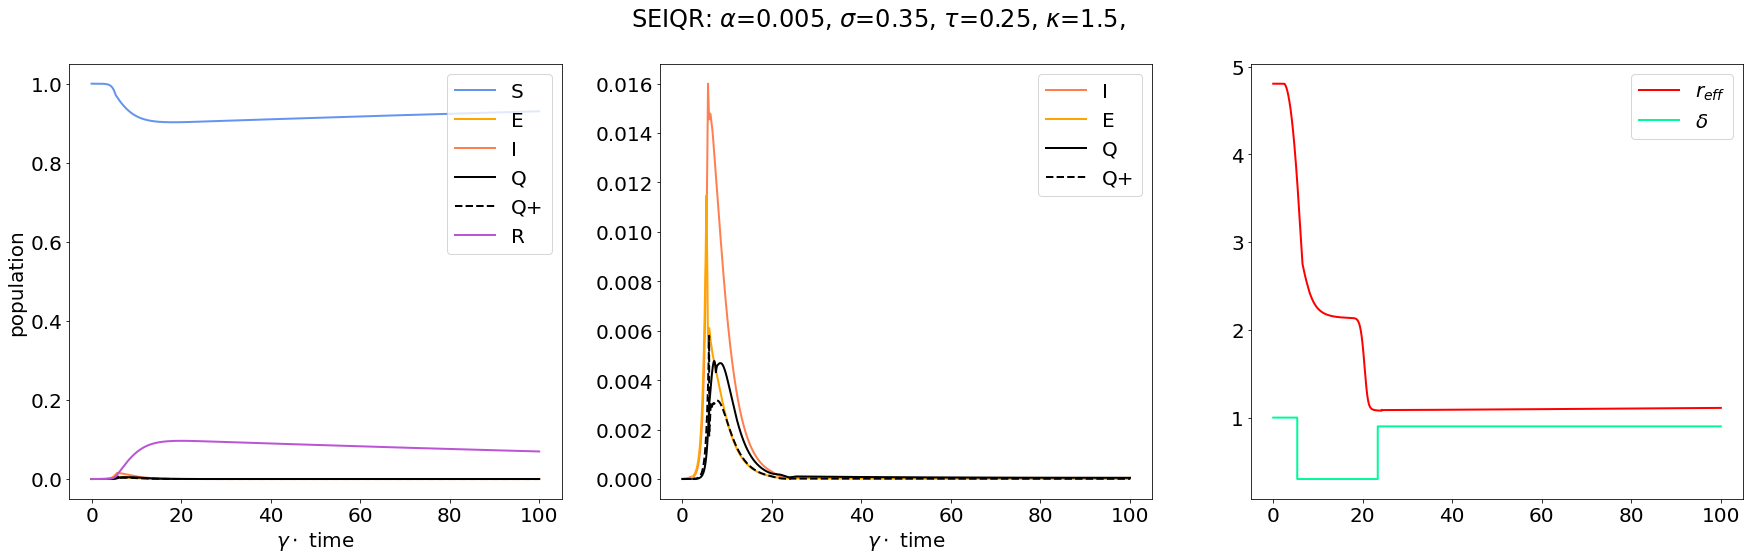

In [ ]:
ct_tracer.full_plot()

In [ ]:
def ct_plot(x):
  fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20,8))
  plt.rcParams.update({'font.size': 30})

  fig.suptitle('Zero Tolerance')

  ax1.set_xlabel('x 10 days')
  ax3.set_xlabel('x 10 days')
  ax1.set_ylabel('population')
  ax1.legend(loc='upper right')

  ax1.plot(x.t_vector[x.t0:], x.Qp[x.t0:], label="Q+", c='w', linestyle='dashed', linewidth=2.5)
  ax1.plot(x.t_vector, x.I, label="I", c='r')
  ax1.plot(x.t_vector, x.E, label="E", c='orange')
  ax1.plot(x.t_vector, x.Q, label="Q", c='w')
  # ax1.plot(x.t_vector, x.ct_history, label="$\\epsilon$", c='g', alpha=0.2)
  
  ax1.set_xlim(20, 80)
  # ax1.set_xlim(30, 37)
  ax1.set_ylim(0, 0.00015)

  # # ax2=ax1.twinx()
  # ax2.step(x.t_vector, 10e6*x.n_history, label='$\\lambda$')
  # ax2.plot(x.t_vector, 1e6*x.ct_history, label='$\\epsilon$')
  # ax2.plot(x.t_vector, [10e6*x.dt*np.sum(x.Qp[i-100:i]) for i in range(20000)], label='5 days')
  # # ax2.plot(x.t_vector, [10e6*x.dt*np.sum(x.Qp[i-20:i]) for i in range(20000)], label='daily cases')
  # ax2.set_ylabel('# of cases')
  # ax2.set_ylim(0, 200)
  # ax2.set_xlim(20, 80)
  # # ax2.set_xlim(30, 37)

  ax1.legend(loc='upper right')
  # ax2.legend(loc='upper right')
  r1 = x.m*x.beta
  r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
  r3 = np.multiply(r2, (1 - x.R - x.Q))
  r4 = np.multiply(r3, x.epsilon_history)

  ax3.set_xlim(0, 80)
  
  ax3.plot(x.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='slateblue')
  ax3.tick_params(axis='y', labelcolor='slateblue')
  # ax3.plot(x.t_vector[:-1], x.p[:-1], label="$p$", c='blue')
  ax5 = ax3.twinx()
  ax5.step(x.t_vector[:-1], x.delta[:-1], label="$\\delta$", c='g')
  ax5.tick_params(axis='y', labelcolor='g')
  ax3.set_ylim(-0.15, 5.15)
  ax5.set_ylim(-0.05, 1.05)
  ax3.legend(loc='lower left')
  ax5.legend(loc='lower right')
  fig.show()

No handles with labels found to put in legend.


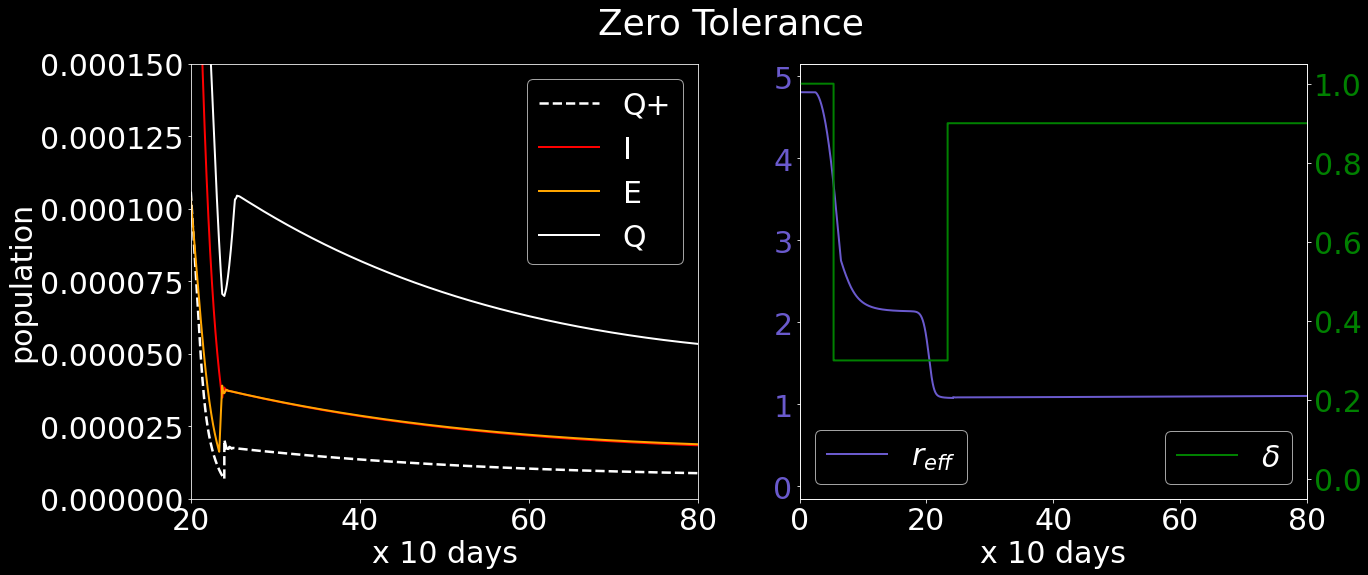

In [ ]:
ct_plot(ct_tracer)
# model2_plot(ct_tracer, 0)

(0.0, 200.0)

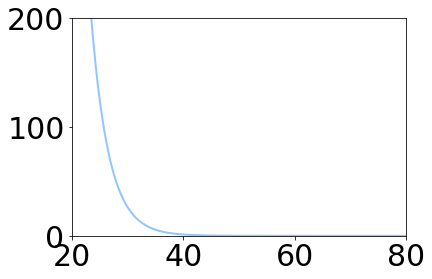

In [ ]:
s=[10e6*x.dt*np.sum(x.Qp[i-100:i]) for i in range(20000)]
plt.plot(x.t_vector, s)
np.max([10e6*x.dt*np.sum(x.Qp[i-100:i]) for i in range(20000)])
plt.xlim(20, 80)
plt.ylim(0, 200)
# x.full_plot()

In [ ]:
x=model2s[0]
x.t_vector[np.where(x.delta[1:]>x.delta[:-1])[0][0]]

NameError: ignored

In [ ]:
import pickle

pickle.dump([x.E, x.Ep, x.S, x.I, x.Q, x.Qp, x.R, x.delta], open('sing2.p', 'wb'))

In [ ]:
# @markdown Singularity Analysis
def singularity_analysis2(x):
  start=int(22.1/model2s[0].dt)
  end=int(27.1/model2s[0].dt)
  plt.rcParams['lines.linewidth'] = 2
  id=np.where(x.delta<1)[0][0]
  tdrop = x.t_vector[id]

  ie=np.where(x.E[start+1:end]-x.E[start:end-1]>0)[0][0]
  temax, emax = x.t_vector[start+ie], x.E[start+ie]

  ie2=np.argmin(x.E[start+1:end]-x.E[start:end-1])
  temax2, emax2 = x.t_vector[start+ie], x.E[start+ie]

  iqp=np.where(x.Qp[start+1:end]-x.Qp[start:end-1]>0)[0][0]
  tqpmax, qpmax = x.t_vector[start+iqp], x.Qp[start+iqp]

  iq=np.where(x.Q[start+1:end]-x.Q[start:end-1]>0)[0][0]
  tqmax, qmax = x.t_vector[start+iq], x.Q[start+iq]

  iqp1=np.where(x.Qp[start+1:end]-x.Qp[start:end-1]>0)[0][1]
  tqpmax1, qpmax1 = x.t_vector[start+iqp1], x.Qp[start+iqp1]
  
  iqp2=np.where(x.Qp[start+1:end]-x.Qp[start:end-1]>0)[0][2]
  tqpmax2, qpmax2 = x.t_vector[start+iqp2], x.Qp[start+iqp2]

  ii=np.argmax(x.I[start:end])
  timax, imax = x.t_vector[start+ii], x.I[start+ii]

  # iq=np.where(x.Q==np.max(x.Q[:int(15/x.dt)]))[0][0]
  # tqmax, qmax = x.t_vector[iq], x.Q[iq]


  fig, ax =plt.subplots(figsize=(20, 8))
  # fig.patch.set_facecolor('#000000')
  ax.step(x.t_vector, x.E, 'orange', label='E')
  ax.step(x.t_vector, x.Ep, 'orange', linewidth=1.3, linestyle='--', label='E+')
  ax.step(x.t_vector, x.I, 'r', label='I')
  ax.step(x.t_vector, x.Q, 'k', label='Q')
  ax.step(x.t_vector, x.Qp, 'k--', label='$Q^+$')
  


  # ax.set_xlim(1, 20)
  ax.set_xlim(x.t_vector[start], x.t_vector[end])
  ax.set_ylim(0.00001, 0.00015)

  # ax.scatter([temax, timax, tqmin, tqpmax, tqpmax2], [emax, imax, qmin, qpmax, qpmax2], s=500, facecolors='none', edgecolors=['orange', 'r', 'k', 'k', 'k'], )
  # ax.annotate('1', xy=(4.8, 0.005), xytext=(temax-0.2, 0.01))
  # ax.annotate('2', xy=(4.8, 0.005), xytext=(timax - 0.2, 0.014))
  # ax.annotate('3', xy=(4.8, 0.005), xytext=(tqpmax +0.1, 0.0065))
  # ax.annotate('4', xy=(4.8, 0.005), xytext=(tqpmax2 -0.15, 0.004))
  # ax.annotate('5', xy=(4.8, 0.005), xytext=(tqmin -0.15, 0.0055))
  ax.axvline(temax, c='orange', linewidth=1.3, alpha=0.3)
  ax.axvline(temax2, c='orange', linewidth=1.3, alpha=0.3)
  ax.axvline(timax, c='r', linewidth=1.3, alpha=0.3)
  # ax.axvline(tqmin, c='k', alpha=0.6)
  ax.axvline(tqpmax, c='k', linestyle='dashed', linewidth=1.3, alpha=0.3) 
  ax.axvline(tqmax, c='k', linestyle='dashed', linewidth=1.3, alpha=0.3) 
  ax.axvline(tqpmax2, c='k', linestyle='dashed', linewidth=1.3, alpha=0.8) 
  # ax.axvline(tqpmax2, c='k', linestyle='dashed', alpha=0.6) 
  # # ax.axvline(5, c='blue', linestyle='dashed', alpha=1, label='linear p') 
  # # ax.axhline(0.007, c='r', linestyle='dashed', alpha=0.8, label='$Q^+_{max}$') 
  # # ax.axvline(x.t_vector[x.t0],c='k', alpha=0.6, label='$t_1$')
  # ax.axvline(tdrop, c='green', linestyle='dashed', alpha=0.6, label='lockdown') 
  
  plt.rcParams.update({'font.size': 18})
  temp=round((timax-temax)/x.sigma, 3)
  print(temp, 'sigma')
  # if temp==1:
  ax.annotate('---$\\sigma$---', xy=(temax, 3e-5), xytext=(temax, 3e-5))
  temp=round((tqmax-timax)/(x.tau), 2)
  # if temp==1:
  print(temp, 'tau')
  ax.annotate('----$\\tau$-----', xy=(timax, 3e-5), xytext=(timax, 5e-5))
  # temp = round((tqpmax2 - tqpmax)/(x.sigma), 1)
  # if temp==1:
  #   ax.annotate('---$\\sigma$---', xy=(5, 0.01), xytext=(tqpmax, 0.017))
  # temp = round((tqmin - tqpmax)/(x.t0*x.dt), 2) #/(x.kappa)
  # if temp==1:
  #   ax.annotate('--------------------- $t_0$ --------------------', xy=(5, 0.01), xytext=(tqpmax, 0.0075))
  # plt.rcParams.update({'font.size': 23})
  # ax.set_ylabel('population')
  ax.set_xlabel('x 10 days')
  ax.legend(loc='upper left')

  # ax2 = plt.axes([0,0,25,0.5])
  # ax2.set_xlim(0,25)
  # ip = InsetPosition(ax, [0.7,0.53,0.28,0.45])
  # ax2.set_axes_locator(ip)
  # ax2.plot(t_vec, p, 'b', label='p')
  # ax2.xaxis.set_ticks(np.arange(0, 30, 5))
  # ax2.legend()



  fig.suptitle('Singularity Analysis')
  # plt.plot([temax, timax, tqmax, tqpmax], [emax, imax, qmax, qpmax], linestyle='None', marker='o')

x= model2s[0]
singularity_analysis2(x)

In [ ]:
# @markdown Singularity Analysis
def singularity_analysis2(x):
  start=int(40/model2s[0].dt)
  end=int(50/model2s[0].dt)
  plt.rcParams['lines.linewidth'] = 2
  id=np.where(x.delta<1)[0][0]
  tdrop = x.t_vector[id]

  ie=np.where(x.E[start+1:end]-x.E[start:end-1]>0)[0][0]
  temax, emax = x.t_vector[start+ie], x.E[start+ie]

  ie2=np.argmin(x.E[start+1:end]-x.E[start:end-1])
  temax2, emax2 = x.t_vector[start+ie], x.E[start+ie]

  iqp=np.where(x.Qp[start+1:end]-x.Qp[start:end-1]>0)[0][0]
  tqpmax, qpmax = x.t_vector[start+iqp], x.Qp[start+iqp]

  iqp1=np.where(x.Qp[start+1:end]-x.Qp[start:end-1]>0)[0][1]
  tqpmax1, qpmax1 = x.t_vector[start+iqp1], x.Qp[start+iqp1]
  
  iqp2=np.where(x.Qp[start+1:end]-x.Qp[start:end-1]>0)[0][2]
  tqpmax2, qpmax2 = x.t_vector[start+iqp2], x.Qp[start+iqp2]

  ii=np.argmax(x.I[start:end])
  timax, imax = x.t_vector[start+ii], x.I[start+ii]

  # iq=np.where(x.Q==np.max(x.Q[:int(15/x.dt)]))[0][0]
  # tqmax, qmax = x.t_vector[iq], x.Q[iq]


  fig, ax =plt.subplots(figsize=(20, 8))
  # fig.patch.set_facecolor('#000000')
  ax.step(x.t_vector, x.E, 'orange', label='E')
  # ax.step(x.t_vector, x.Ep, 'orange', linewidth=1.3, linestyle='--', label='E+')
  ax.step(x.t_vector, x.I, 'r', label='I')
  # ax.step(x.t_vector, x.Q, 'k', label='Q')
  ax.step(x.t_vector, x.Qp, 'k--', label='$Q^+$')


  # ax.set_xlim(31.5, 35)
  ax.set_xlim(x.t_vector[start], x.t_vector[end])
  ax.set_ylim(0.00001, 0.00008)

  # ax.scatter([temax, timax, tqmin, tqpmax, tqpmax2], [emax, imax, qmin, qpmax, qpmax2], s=500, facecolors='none', edgecolors=['orange', 'r', 'k', 'k', 'k'], )
  # ax.annotate('1', xy=(4.8, 0.005), xytext=(temax-0.2, 0.01))
  # ax.annotate('2', xy=(4.8, 0.005), xytext=(timax - 0.2, 0.014))
  # ax.annotate('3', xy=(4.8, 0.005), xytext=(tqpmax +0.1, 0.0065))
  # ax.annotate('4', xy=(4.8, 0.005), xytext=(tqpmax2 -0.15, 0.004))
  # ax.annotate('5', xy=(4.8, 0.005), xytext=(tqmin -0.15, 0.0055))
  ax.axvline(temax, c='orange', linewidth=1.3, alpha=0.3)
  ax.axvline(temax2, c='orange', linewidth=1.3, alpha=0.3)
  ax.axvline(timax, c='r', linewidth=1.3, alpha=0.3)
  # ax.axvline(tqmin, c='k', alpha=0.6)
  ax.axvline(tqpmax, c='k', linestyle='dashed', linewidth=1.3, alpha=0.3) 
  ax.axvline(tqpmax1, c='k', linestyle='dashed', linewidth=1.3, alpha=0.3) 
  ax.axvline(tqpmax2, c='k', linestyle='dashed', linewidth=1.3, alpha=0.8) 
  # ax.axvline(tqpmax2, c='k', linestyle='dashed', alpha=0.6) 
  # # ax.axvline(5, c='blue', linestyle='dashed', alpha=1, label='linear p') 
  # # ax.axhline(0.007, c='r', linestyle='dashed', alpha=0.8, label='$Q^+_{max}$') 
  # # ax.axvline(x.t_vector[x.t0],c='k', alpha=0.6, label='$t_1$')
  # ax.axvline(tdrop, c='green', linestyle='dashed', alpha=0.6, label='lockdown') 
  
  plt.rcParams.update({'font.size': 18})
  temp=round((timax-temax)/x.sigma, 3)
  print(temp, 'sigma')
  # if temp==1:
  # ax.annotate('---$\\sigma$---', xy=(temax, 3e-5), xytext=(temax, 3e-5))
  temp=round((tqpmax2-timax)/(x.sigma+x.tau), 2)
  # if temp==1:
  print(temp, 'sigma + tau')
  # ax.annotate('----$\\sigma +\\tau$-----', xy=(timax, 3e-5), xytext=(timax, 5e-5))
  # temp = round((tqpmax2 - tqpmax)/(x.sigma), 1)
  # if temp==1:
  #   ax.annotate('---$\\sigma$---', xy=(5, 0.01), xytext=(tqpmax, 0.017))
  # temp = round((tqmin - tqpmax)/(x.t0*x.dt), 2) #/(x.kappa)
  # if temp==1:
  #   ax.annotate('--------------------- $t_0$ --------------------', xy=(5, 0.01), xytext=(tqpmax, 0.0075))
  # plt.rcParams.update({'font.size': 23})
  # ax.set_ylabel('population')
  ax.set_xlabel('days')
  ax.legend(loc='upper left')

  # ax2 = plt.axes([0,0,25,0.5])
  # ax2.set_xlim(0,25)
  # ip = InsetPosition(ax, [0.7,0.53,0.28,0.45])
  # ax2.set_axes_locator(ip)
  # ax2.plot(t_vec, p, 'b', label='p')
  # ax2.xaxis.set_ticks(np.arange(0, 30, 5))
  # ax2.legend()



  fig.suptitle('Singularity Analysis')
  # plt.plot([temax, timax, tqmax, tqpmax], [emax, imax, qmax, qpmax], linestyle='None', marker='o')

x= model2s[-1]
singularity_analysis2(x)

In [ ]:
# for x in model2s:
#   stoch_plot(x)
x=model2s[0]
plt.figure(figsize=(14, 7))
start=int(22.1/x.dt)
end=int(28.1/x.dt)
skip=int(0.1/x.dt)
# plt.step(10*x.t_vector[start:end], 1e6*model2s[3].Qp[start:end])#:skip
qp = np.asarray([10e6*x.dt*np.sum(x.Qp[i:i+20]) for i in np.arange(start,end, 20)])
qp2 = qp - np.asarray([10e6*x.dt*np.sum(x.Qpb[i:i+20]) for i in np.arange(start,end, 20)])
# n = np.asarray([np.max(10e6*x.n_history[i - int((x.sigma + x.tau)/x.dt):i - int((x.sigma + x.tau)/x.dt) +20]) for i in np.arange(start,end, 20)])
plt.bar(10*x.t_vector[start:end:20]-221, qp)
# plt.bar(10*x.t_vector[start:end:20], )
# plt.bar(10*x.t_vector[start:end], 10e6*model2s[3].n_history[start:end])#:skip
plt.title('Daily new cases')
plt.xlabel('days')
# np.sum(qp2)

In [ ]:
.42*np.exp(-x.tau)*75, (1/2)*(1 - 0.42)*np.exp(-2*x.tau)*75, (1/4)*(1 - 0.42)*np.exp(-3*x.tau)*75

In [ ]:
# np.where(x.S+x.E+x.I+x.Q+x.R<1)
plt.plot(x.S+x.E+x.I+x.Q+x.R)

In [ ]:
plt.plot(x.t_vector, 1-x.epsilon_history)
plt.xlim(19.4, 25)
plt.ylim(0, 1)
plt.hlines(0.5, xmin=0, xmax=25)

In [ ]:
plt.plot(x.t_vector, x.p)
plt.xlim(19.4, 25)
plt.ylim(0, 1)
plt.hlines(0.425, xmin=0, xmax=25)

In [ ]:
x=model2s[0]
plt.figure(figsize=(14, 7))
start=int(22.1/x.dt)
end=int(28.1/x.dt)
skip=int(0.1/x.dt)
# plt.step(10*x.t_vector[start:end], 1e6*model2s[3].Qp[start:end])#:skip
qp = np.asarray([10e6*x.E[i] for i in np.arange(start,end, 20)])
# n = np.asarray([np.max(10e6*x.n_history[i - int((x.sigma + x.tau)/x.dt):i - int((x.sigma + x.tau)/x.dt) +20]) for i in np.arange(start,end, 20)])
plt.bar(10*x.t_vector[start:end:20]-221, qp)
# plt.bar(10*x.t_vector[start:end:20], )
# plt.bar(10*x.t_vector[start:end], 10e6*model2s[3].n_history[start:end])#:skip
plt.ylim(250, 455)
plt.title('[E]')
plt.xlabel('days')

In [ ]:
x=model2s[0]
plt.figure(figsize=(14, 7))
start=int(22.1/x.dt)
end=int(27.1/x.dt)
skip=int(0.1/x.dt)
# plt.step(10*x.t_vector[start:end], 1e6*model2s[3].Qp[start:end])#:skip
qp = np.asarray([10e6*x.I[i] for i in np.arange(start,end, 20)])
# n = np.asarray([np.max(10e6*x.n_history[i - int((x.sigma + x.tau)/x.dt):i - int((x.sigma + x.tau)/x.dt) +20]) for i in np.arange(start,end, 20)])
plt.bar(10*x.t_vector[start:end:20]-221, qp)
# plt.bar(10*x.t_vector[start:end:20], )
# plt.bar(10*x.t_vector[start:end], 10e6*model2s[3].n_history[start:end])#:skip
plt.ylim(340, 510)
plt.title('[I]')
plt.xlabel('days')

In [ ]:
0.5*0.42*np.exp(-x.tau)*75

In [ ]:
plt.plot(model2s[0].S+model2s[0].E+model2s[0].I+model2s[0].Q+model2s[0].R)
# 1 - (model2s[0].S+model2s[0].E+model2s[0].I+model2s[0].Q+model2s[0].R)[np.where(model2s[0].S+model2s[0].E+model2s[0].I+model2s[0].Q+model2s[0].R!=1)]

#### Plot 2

In [ ]:
model2s=[]

test=dict(
  beta= (2/3)*r1/2,
  m= 3*m_0,
  alpha= 0.005,
  gamma= 1,
  sigma= 0.35,#0.3,
  tau= 0.25,#0.2,
  epsilon= lambda t, qp: 1 if t<10 else 1 - 0.5*SEIQR.contact_curve(qp),
  p= p,
  kappa=1.5,
  d_param='new_periodic',
  d_func = 1.2,
  delta_o=0.9,
  dld=0.3,
  qpo=0.001,
  qpld= 0.004,
  r1=r1,
  # rand='manual',
  rand='a',

  t_start=0, 
  dt=0.005,
  t_end=100,

  init=(S0, E0, I0, R0)
)
x=SEIQR(**test)
x.run()
model2s.append(x)

In [ ]:
model2s[0].full_plot()
# np.where(model2s[0].Qp>0.002)

In [ ]:
def model2_plot(x, i):
  # sns.set_color_codes("colorblind")
  plt.style.use('seaborn-pastel')
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

  if i==0:
    title='Zero-Tolerance'
  else:
    title='Zero-Tolerance (failure)'
  fig.suptitle(title)

  ax1.set_xlabel('x 10 days')
  ax1.set_ylabel('population')
  ax1.legend(loc='upper right')

  ax1.plot(x.t_vector, x.I, label="I", c='r')
  ax1.plot(x.t_vector, x.E, label="E", c='orange')
  ax1.plot(x.t_vector, x.Q, label="Q", c='k')
  ax1.plot(x.t_vector[x.t0:], x.Qp[x.t0:], label="Q+", c='k', linestyle='dashed', linewidth=2.5)
  # ax1.plot(x.t_vector[x.t0:], x.Ep[x.t0:], label="E+", c='orange', linestyle='dashed', linewidth=1.5)
  # ax1.plot(x.t_vector[x.t0:], -x.ct_history[x.t0:] + x.m*np.multiply(np.multiply(x.beta[x.t0:], x.delta[x.t0:]), np.multiply(x.S[x.t0:], x.I[x.t0:])), label="E++", c='g', linestyle='dashed', linewidth=1.5)
  # ax1.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax1.axvline(x.t_vector[np.where(x.delta<1)[0][0]],c='g', alpha=0.4)

  r1 = x.m*x.beta
  r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
  r3 = np.multiply(r2, (1 - x.R - x.Q))
  r4 = np.multiply(r3, x.epsilon_history)
  ax2.plot(x.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='slateblue')
  # ax2.plot(x.t_vector[:-1], x.delta[:-1]*r4[:-1], label="$\\delta r_{eff}$", c='slateblue', linewidth=1.3)
  # ax2.plot(x.t_vector[:-1], x.p[:-1], label="$p$", c='blue')
  ax5 = ax2.twinx()
  ax5.step(x.t_vector[:-1], x.delta[:-1], label="$\\delta$", c='g')
  # ax5.step(x.t_vector[:-1], 1 -x.epsilon_history[:-1], label="$\\epsilon$", c='k')
  ax2.tick_params(axis='y', labelcolor='slateblue')
  ax5.tick_params(axis='y', labelcolor='g')
  ax2.set_ylim(-0.1, 5.1)
  # ax2.set_ylim(-0.1, 1.6)
  ax5.set_ylim(-0.05, 1.05)


  ax2.set_xlabel('x 10 days')
  
  ax1.set_xlim(0, 80)
  ax2.set_xlim(0, 80)
  ax1.set_ylim(0, 0.01)

  # ax1.set_ylim(0, 10e-5)
  # ax1.set_xlim(20, 40)
  # ax2.set_xlim(20, 40)
  ax2.legend(loc='lower left')
  ax5.legend(loc='lower right')
  ax1.legend(loc='upper right')
  fig.show()

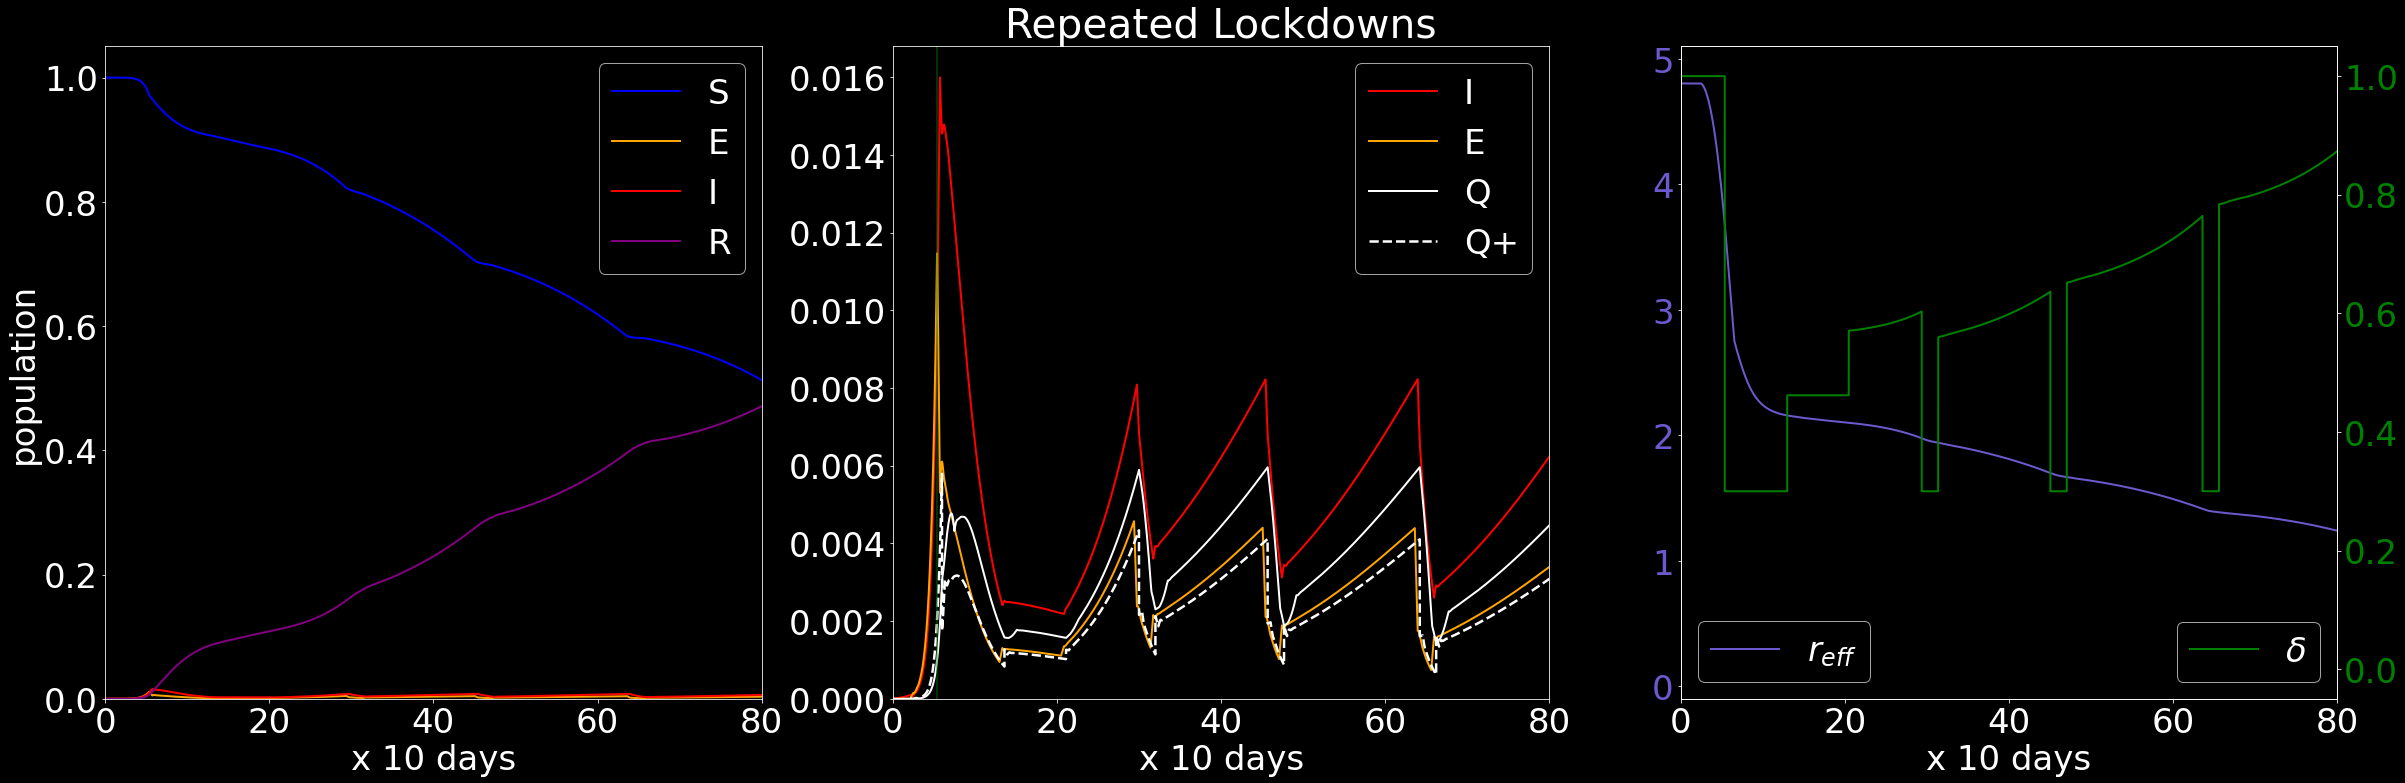

In [ ]:
rpt_lock = model2s[0]
minint_plot(rpt_lock, 'Repeated Lockdowns')
# model2_plot(model2s[0], 0)
# model2_plot(model2s[1], 1)
# model2_plot(model2s[2], 1)
# model2_plot(model2s[3], 1)

In [ ]:
from IPython.display import HTML
import plotly.express as px
# df = px.data.iris()
# display(df.head())
fig = px.scatter(x=x.t_vector, y=x.delta)
HTML(fig.to_html())

In [ ]:
plt.plot(model2s[0].t_vector, model2s[0].Ep)
plt.plot(model2s[0].t_vector, model2s[0].S*model2s[0].I)
plt.xlim(20, 40)
plt.ylim(0, 0.0001)

In [ ]:
# plt.plot(model2s[0].t_vector, model2s[0].delta*model2s[0].beta)
plt.plot(model2s[0].t_vector, model2s[0].m*model2s[0].delta*model2s[0].beta*model2s[0].S*model2s[0].I)
plt.xlim(20, 40)
plt.ylim(0, 0.0001)

In [ ]:
"model2s[0].full_plot()

In [ ]:
# plt.step(model2s[1].beta)
r1 = model2s[1].m*model2s[1].beta
r2 = np.multiply(r1, (1 - model2s[1].p*np.exp(-model2s[1].tau)))
r3 = np.multiply(r2, (1 - model2s[1].R - model2s[1].Q))
r4 = np.multiply(r3, model2s[1].epsilon_history)
plt.plot(model2s[1].t_vector[:-1], r3[:-1], label="$r_{eff}$", c='slateblue')
plt.plot(model2s[1].t_vector[:-1], r4[:-1], label="$r_{eff}$", c='slateblue')

In [ ]:
plt.plot(model2s[1].epsilon_history)
plt.plot(model2s[0].epsilon_history)

In [ ]:
plt.step(model2s[0].t_vector, model2s[0].n_history)
plt.step(model2s[1].t_vector, model2s[1].n_history)

In [ ]:
plt.step(model2s[0].t_vector, model2s[0].ct_history)
plt.step(model2s[1].t_vector, model2s[1].ct_history)

In [ ]:
plt.step(model2s[0].t_vector, model2s[0].epsilon_history)
plt.step(model2s[1].t_vector, model2s[1].epsilon_history)

## Min Intervention

In [ ]:
min_int_prams=dict(
  beta= (2/3)*r1/2,
  m= 3*m_0,
  alpha= 0.005,
  gamma= 1,
  sigma= 0.35,#0.3,
  tau= 0.25,#0.2,
  epsilon= lambda t, qp: 1 if t<10 else 1 - 0.5*SEIQR.contact_curve(qp),
  p= p,
  kappa=1.5,
  d_param='new_model3BIG',
  steer_value= 0.001,
  d_func = 1.025,
  delta_o=1,
  qpo=0.0015,
  r1=r1,
  dld=0.3,
  rand='a',


  t_start=0, 
  dt=0.005,
  t_end=100,

  init=(S0, E0, I0, R0)
)
min_int=SEIQR(**min_int_prams)
min_int.run()

In [ ]:
def minint_plot(x, tit=False):
  plt.rcParams.update({'font.size': 34})
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40,12))
  # fig1, ax2 = plt.subplots(1, 1, figsize=(12,12))
  # fig2, ax3 = plt.subplots(1, 1, figsize=(12,12))
  # ax1.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax1.plot(x.t_vector, x.S, label="S", c='b')
  ax1.plot(x.t_vector, x.E, label="E", c='orange')
  ax1.plot(x.t_vector, x.I, label="I", c='r')
  ax1.plot(x.t_vector, x.R, label="R", c='purple')

  if tit==False:
    title='Living with the Virus'
    fig.suptitle('Model 2')
  else:
    title=tit
  # fig.suptitle(title)
  ax2.set_title(title)

  ax1.set_xlabel('x 10 days')
  ax1.set_ylabel('population')
  ax1.legend(loc='upper right')

  ax2.plot(x.t_vector, x.I, label="I", c='r')
  ax2.plot(x.t_vector, x.E, label="E", c='orange')
  ax2.plot(x.t_vector, x.Q, label="Q", c='w')
  ax2.plot(x.t_vector[x.t0:], x.Qp[x.t0:], label="Q+", c='w', linestyle='dashed', linewidth=2.5)
  # ax2.axvline(x.t_vector[x.t0],c='k', alpha=0.2)
  ax2.axvline(x.t_vector[np.where(x.delta<1)[0][0]],c='g', alpha=0.4)

  r1 = x.m*x.beta
  r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
  r3 = np.multiply(r2, (1 - x.R - x.Q))
  r4 = np.multiply(r3, x.epsilon_history)
  
  ax3.plot(x.t_vector[:-1], r4[:-1], label="$r_{eff}$", c='slateblue')
  # ax3.step(x.t_vector[:-1], x.p[:-1], label="$p$", c='blue')
  ax5 = ax3.twinx()
  ax5.step(x.t_vector[:-1], x.delta[:-1], label="$\\delta$", c='g')
  ax5.tick_params(axis='y', labelcolor='g')
  ax3.tick_params(axis='y', labelcolor='slateblue')
  ax3.set_ylim(-0.1, 5.1)
  ax5.set_ylim(-0.05, 1.05)

  ax2.set_xlabel('x 10 days')
  ax3.set_xlabel('x 10 days')
  
  ax1.set_xlim(0, 80)
  ax2.set_xlim(0, 80)
  ax3.set_xlim(0, 80)
  ax1.set_ylim(0)
  ax2.set_ylim(0)
  ax2.legend(loc='upper right')
  ax3.legend(loc='lower left')
  ax5.legend(loc='lower right')
  fig.show()
  # fig1.show()
  # fig2.show()

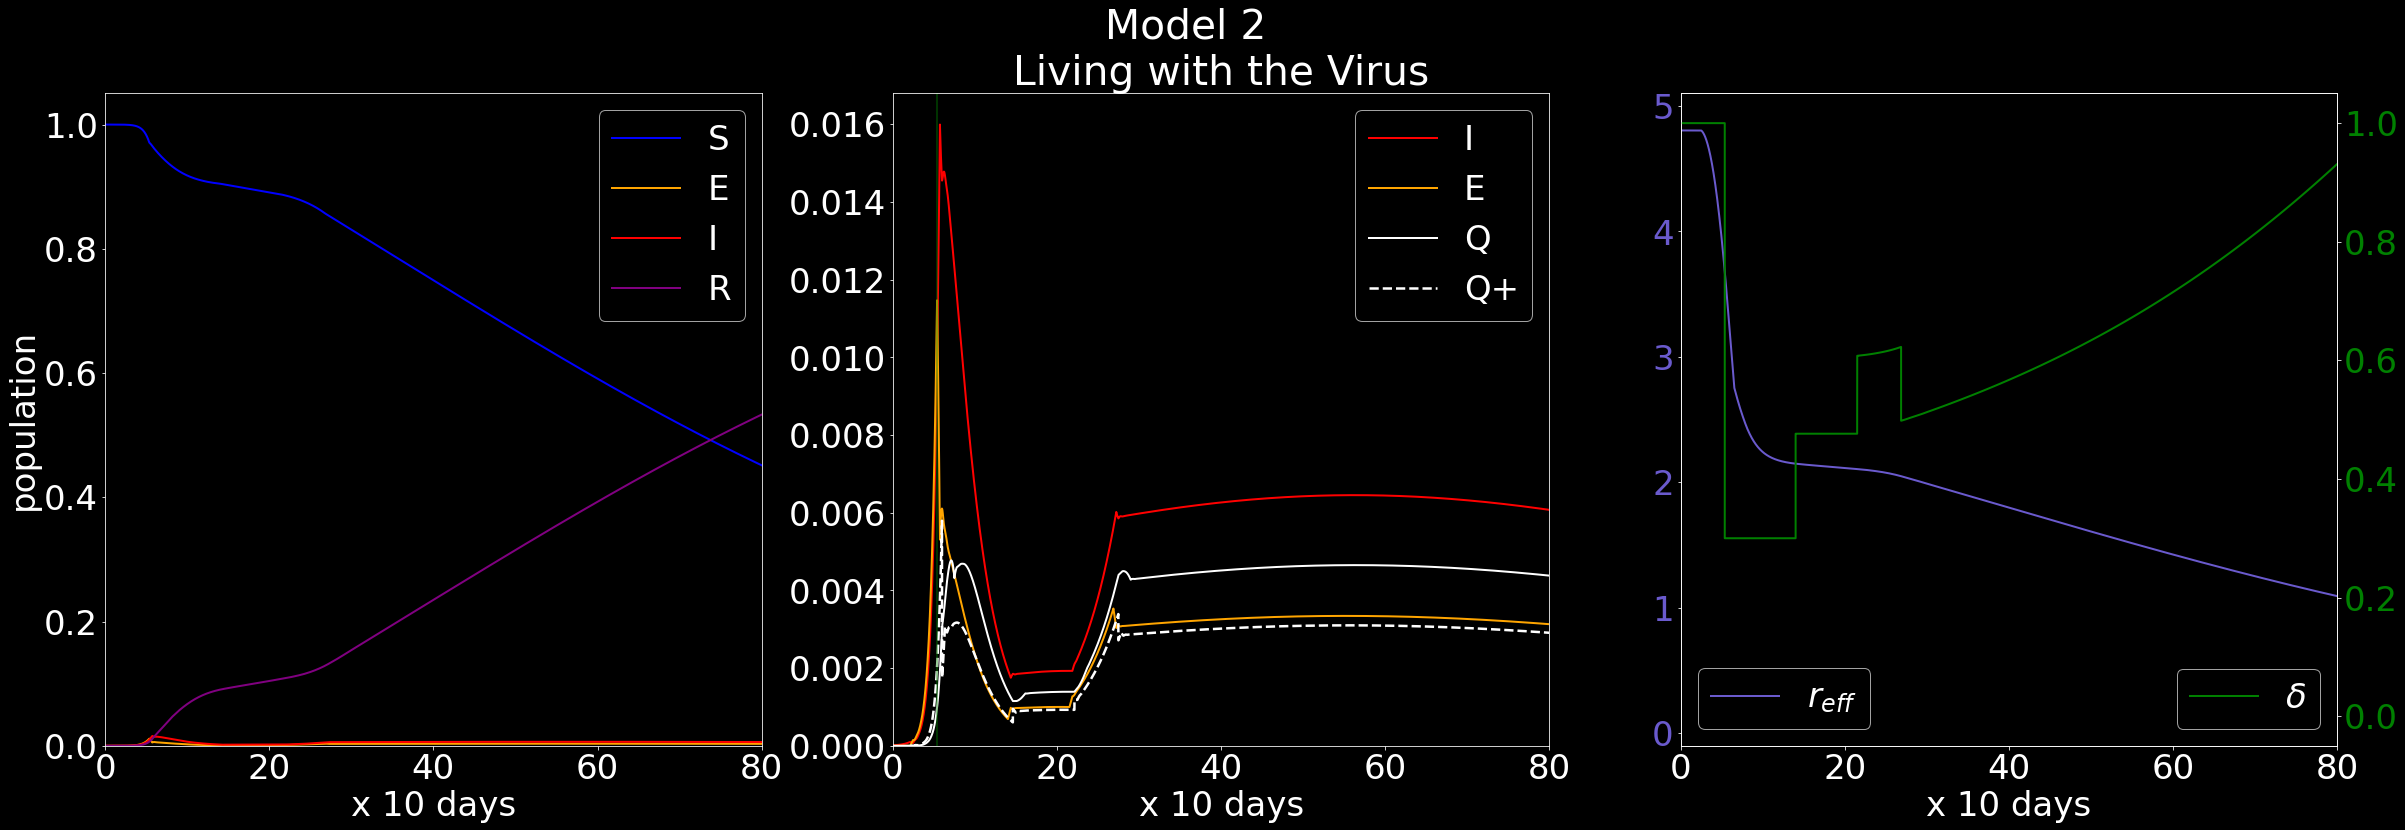

In [ ]:
minint_plot(min_int)

## Comparison

Text(0, 0.5, '$\\delta$')

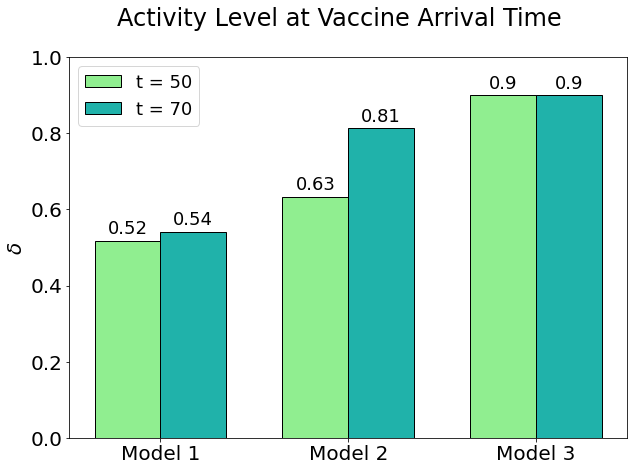

In [ ]:
models=[steer_smol, min_int, ct_tracer]
fig, (ax2) = plt.subplots(1, 1, figsize=(10, 7))
plt.rcParams.update({'font.size': 20})
fig.suptitle('Activity Level at Vaccine Arrival Time')


denom50 =(np.cumsum(baseline.dt*baseline.delta)/(baseline.dt*baseline.size))[int(50/baseline.dt)]
denom70 =(np.cumsum(baseline.dt*baseline.delta)/(baseline.dt*baseline.size))[int(70/baseline.dt)]

labels = ['Model 1', 'Model 2', 'Model 3']
x = np.arange(len(labels))
# y70 = [(np.cumsum(steer_smol.dt*steer_smol.delta)/(steer_smol.dt*steer_smol.size))[int(70/baseline.dt)]/denom70,
#        (np.cumsum(min_int.dt*min_int.delta)/(min_int.dt*min_int.size))[int(70/baseline.dt)]/denom70,
#        (np.cumsum(ct_tracer.dt*ct_tracer.delta)/(ct_tracer.dt*ct_tracer.size))[int(70/baseline.dt)]/denom70,
#        ]
# y50 = [(np.cumsum(steer_smol.dt*steer_smol.delta)/(steer_smol.dt*steer_smol.size))[int(50/baseline.dt)]/denom50,
#        (np.cumsum(min_int.dt*min_int.delta)/(min_int.dt*min_int.size))[int(50/baseline.dt)]/denom50,
#        (np.cumsum(ct_tracer.dt*ct_tracer.delta)/(ct_tracer.dt*ct_tracer.size))[int(50/baseline.dt)]/denom50,
#        ]

y70=[i.delta[int(70/baseline.dt)] for i in models]
y50=[i.delta[int(50/baseline.dt)] for i in models]

width = 0.35
rects1 = ax2.bar(x - width/2, y50, width, label='t = 50', color='lightgreen', edgecolor='k')
rects2 = ax2.bar(x + width/2, y70, width, label='t = 70', color='lightseagreen', edgecolor='k')

ax2.set_xticks(x)
ax2.set_xticklabels(labels)

def autolabel(rects):
    plt.rcParams.update({'font.size': 18})
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax2.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
ax2.legend(loc='upper left')

plt.rcParams.update({'font.size': 20})
ax2.set_ylim(0, 1)
ax2.set_ylabel('$\\delta$')

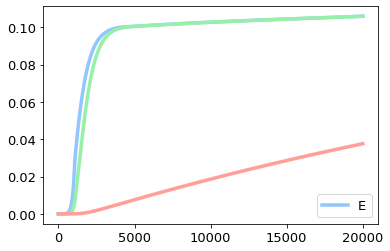

In [ ]:
plt.plot(np.cumsum(ct_tracer.dt*ct_tracer.Ep), label='E')
# plt.plot(ct_tracer.R+np.cumsum(ct_tracer.dt*0.005*ct_tracer.R))
# plt.plot(np.cumsum(ct_tracer.dt*0.005*ct_tracer.R))
plt.legend()

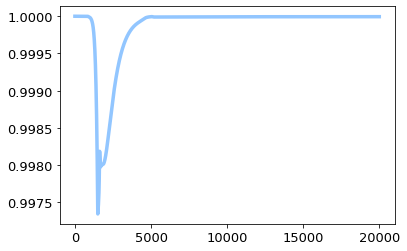

In [ ]:
plt.plot(ct_tracer.S+ct_tracer.I+ct_tracer.E+ct_tracer.R+ct_tracer.Q)

(-0.5, 4.5)

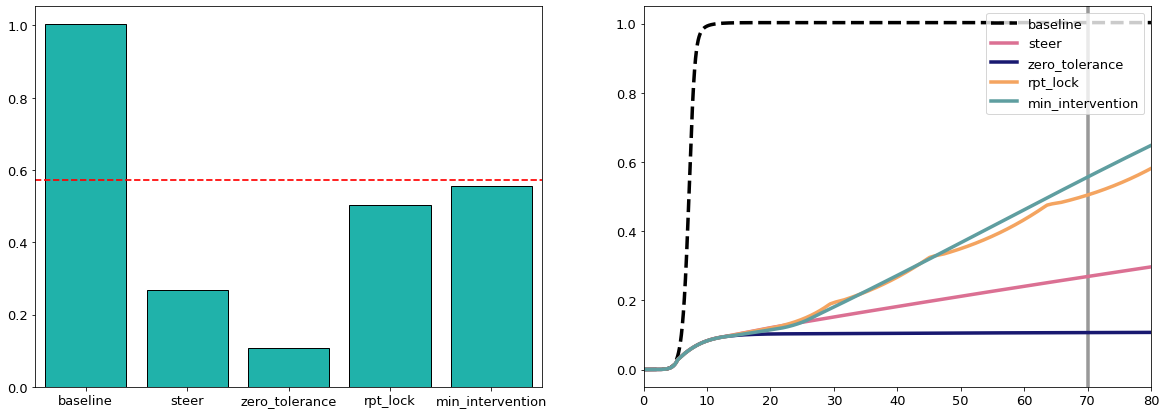

In [ ]:
rptl=np.cumsum(rpt_lock.dt*rpt_lock.Ep)
x=rpt_lock
r1 = x.m*x.beta
r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
r4 = np.multiply(r2, x.epsilon_history)
rptR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]



bsl=np.cumsum(baseline.dt*baseline.Ep)
x=baseline
r1 = x.m*x.beta
r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
r4 = np.multiply(r2, x.epsilon_history)
bsR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]


stl=np.cumsum(steer_smol.dt*steer_smol.Ep)
x=steer_smol
r1 = x.m*x.beta
r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
r4 = np.multiply(r2, x.epsilon_history)
stlR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]


# stl2=np.cumsum(steer_med.dt*steer_med.Ep)
# x=steer_med
# r1 = x.m*x.beta
# r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# # r3 = np.multiply(r2, (1 - x.R - x.Q))
# r4 = np.multiply(r2, x.epsilon_history)
# stl2R=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]


ztl=np.cumsum(ct_tracer.dt*ct_tracer.Ep)
x=ct_tracer
r1 = x.m*x.beta
r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
r4 = np.multiply(r2, x.epsilon_history)
ztlR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]




mnl=np.cumsum(min_int.dt*min_int.Ep)
x=min_int
r1 = x.m*x.beta
r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
r4 = np.multiply(r2, x.epsilon_history)
mnltR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]



fig, (ax3, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax2.plot(baseline.t_vector, bsl, 'k--', label='baseline')
ax2.plot(steer_smol.t_vector, stl, label='steer', color='palevioletred')
# ax2.plot(steer_med.t_vector, stl2, label='steer_05')
ax2.plot(ct_tracer.t_vector, ztl, label='zero_tolerance', color='midnightblue')
ax2.plot(rpt_lock.t_vector, rptl, 'b', label='rpt_lock', color='sandybrown')
ax2.plot(min_int.t_vector, mnl, label='min_intervention', color='cadetblue')
ax2.legend(loc='upper right')
ax2.set_xlim(0, 80)
ax2.set_ylim(-0.05, 1.05)
ax2.vlines(70, -0.05, 1.05, 'k', alpha=0.4)

ax3.bar(['baseline', 'steer', 'zero_tolerance', 'rpt_lock', 'min_intervention'],
        [bsl[int(70/x.dt)], stl[int(70/x.dt)],  ztl[int(70/x.dt)], rptl[int(70/x.dt)], mnl[int(70/x.dt)]], color='lightseagreen', edgecolor='k')
        # [bsR, stlR, stl2R, ztlR, rptR, mnltR])
ax3.hlines(rptR, -0.5, 6, color='r', linestyles='dashed', linewidth=1.7)
ax3.set_xlim(-0.5, 4.5)

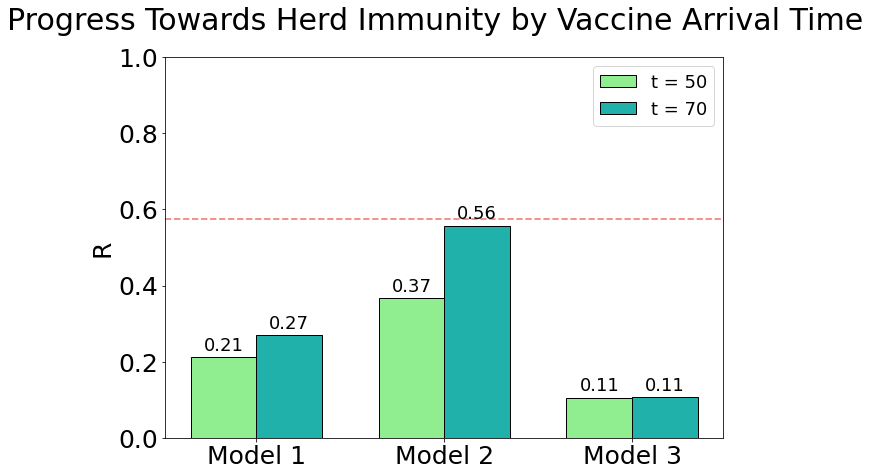

In [ ]:
stl=np.cumsum(steer_smol.dt*steer_smol.Ep)
x=steer_smol
r1 = x.m*x.beta
r4 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
stlR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]

mnl=np.cumsum(min_int.dt*min_int.Ep)
x=min_int
r1 = x.m*x.beta
r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
r4 = np.multiply(r2, x.epsilon_history)
mnltR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]


ztl=np.cumsum(ct_tracer.dt*ct_tracer.Ep)
x=ct_tracer
r1 = x.m*x.beta
r2 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
# r3 = np.multiply(r2, (1 - x.R - x.Q))
r4 = np.multiply(r2, x.epsilon_history)
ztlR=1-x.Q[int(80/x.dt)]-(1/r4)[int(80/x.dt)]



fig, (ax2) = plt.subplots(1, 1, figsize=(10, 7))
plt.rcParams.update({'font.size': 25})
fig.suptitle('Progress Towards Herd Immunity by Vaccine Arrival Time')



labels = ['Model 1', 'Model 2', 'Model 3']

y70 = [stl[int(70/x.dt)],
       mnl[int(70/x.dt)],
       ztl[int(70/x.dt)],
       ]
y50 = [stl[int(50/x.dt)],
       mnl[int(50/x.dt)],
       ztl[int(50/x.dt)],
       ]

x = np.arange(len(labels))

width = 0.35
rects1 = ax2.bar(x - width/2, y50, width, label='t = 50', color='lightgreen', edgecolor='k')
rects2 = ax2.bar(x + width/2, y70, width, label='t = 70', color='lightseagreen', edgecolor='k')

ax2.set_xticks(x)
ax2.set_xticklabels(labels)

autolabel(rects1)
autolabel(rects2)
ax2.legend()

plt.rcParams.update({'font.size': 25})
ax2.set_ylim(0, 1)
ax2.set_ylabel('R')
ax2.axhline(stlR, color='lightcoral', linestyle='dashed', linewidth=1.7)

Text(0, 0.5, 'R')

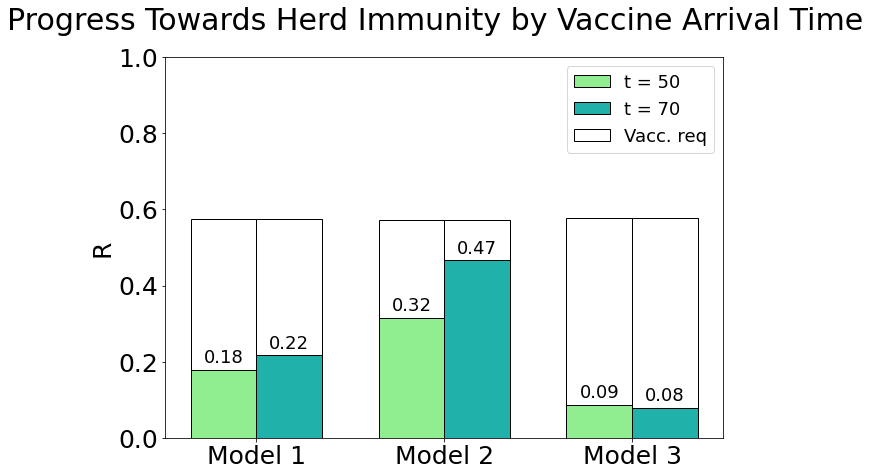

In [ ]:
fig, (ax2) = plt.subplots(1, 1, figsize=(10, 7))
plt.rcParams.update({'font.size': 25})
fig.suptitle('Progress Towards Herd Immunity by Vaccine Arrival Time')

x=steer_smol
r1 = x.m*x.beta
r4 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
stlR50=1-x.Q[int(50/x.dt)]-(1/r4)[int(50/x.dt)]-x.R[int(50/x.dt)]
stlR70=1-x.Q[int(70/x.dt)]-(1/r4)[int(70/x.dt)]-x.R[int(70/x.dt)]

x=min_int
r1 = x.m*x.beta
r4 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
mnlR50=1-x.Q[int(50/x.dt)]-(1/r4)[int(50/x.dt)]-x.R[int(50/x.dt)]
mnlR70=1-x.Q[int(70/x.dt)]-(1/r4)[int(70/x.dt)]-x.R[int(70/x.dt)]

x=ct_tracer
r1 = x.m*x.beta
r4 = np.multiply(r1, (1 - x.p*np.exp(-x.tau)))
ztlR50=1-x.Q[int(50/x.dt)]-(1/r4)[int(50/x.dt)]-x.R[int(50/x.dt)]
ztlR70=1-x.Q[int(70/x.dt)]-(1/r4)[int(70/x.dt)]-x.R[int(70/x.dt)]

# denom =(np.cumsum(baseline.dt*baseline.delta)/(baseline.dt*baseline.size))[int(60/baseline.dt)]

labels = ['Model 1', 'Model 2', 'Model 3']

y70 = [steer_smol.R[int(70/baseline.dt)],
       min_int.R[int(70/baseline.dt)],
       ct_tracer.R[int(70/baseline.dt)],
       ]
y50 = [steer_smol.R[int(50/baseline.dt)],
       min_int.R[int(50/baseline.dt)],
       ct_tracer.R[int(50/baseline.dt)],
       ]

x = np.arange(len(labels))

vreq50 = [stlR50, mnlR50, ztlR50]
vreq70 = [stlR70, mnlR70, ztlR70]

width = 0.35
rects1 = ax2.bar(x - width/2, y50, width, label='t = 50', color='lightgreen', edgecolor='k')
rects2 = ax2.bar(x + width/2, y70, width, label='t = 70', color='lightseagreen', edgecolor='k')

ax2.bar(x - width/2, vreq50, width, bottom=y50, color='white', edgecolor='k')
ax2.bar(x + width/2, vreq70, width, label='Vacc. req', bottom=y70, color='white', edgecolor='k')

ax2.set_xticks(x)
ax2.set_xticklabels(labels)

autolabel(rects1)
autolabel(rects2)
# ax2.axhline(stlR50 + steer_smol.R[int(50/steer_smol.dt)], label='Herd imm.', color='lightcoral', linestyle='dashed', linewidth=1.7)
ax2.legend()

plt.rcParams.update({'font.size': 25})
ax2.set_ylim(0, 1)
ax2.set_ylabel('R')



## test

In [ ]:
testis=[]
x5= [0.0000025*i for i in range(1, 120)]
# x6= [0.000045, 0.000052]
# x5.extend(x6)
for qpo in x5:#, 0.000017, 0.00002, 0.00003, 0.00005]: #np.arange(0.00001, 0.00005, 0.00001): 
  test=dict(
    beta= (2/3)*r1/2,
    m= 3*m_0,
    alpha= 0.005,
    gamma= 1,
    sigma= 0.3,
    epsilon= lambda t, qp: 1 if t<10 else 1 - 0.5*SEIQR.contact_curve(qp),
    p= p,#SEIQR.transition(0.05, 0.35, 3.5, 6.25, x.t_vector),
    tau= 0.2,
    kappa=1.5,
    d_param='delta_open',
    d_func = 1,
    delta_o=0.9,
    dld=0.3,
    qpo=qpo,
    r1=r1,
    rand='a',
    
    t_start=0, 
    dt=0.005,
    t_end=100,

    init=(S0, E0, I0, R0)
  )
  x=SEIQR(**test)
  x.run()
  testis.append(x)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:457: RuntimeWarning: overflow encountered in exp


In [ ]:
x1, y1 =[], []

for j in range(len(testis)):
  test = testis[j]
  t3 = np.where(test.delta[1:]>test.delta[:-1])[0][0]
  x1.append(test.Qp[t3])
  y1.append(1 - SEIQR.test(test, t3))
    
x1=np.asarray(x1)[::-1]
y1=np.asarray(y1)[::-1]

y5 = [0.5*SEIQR.contact_curve(i) for i in x5]
x = [i/100000 for i in range(0, 26)]
# ax.plot(x, [0.5*SEIQR.contact_curve(i) for i in x], 'k')
intersection_idx = np.where(y1<y5)[0][-1]
intersection_idx2 = np.where(y1>y5)[0][0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:457: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:457: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:457: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:457: RuntimeWarning: overflow encountered in exp


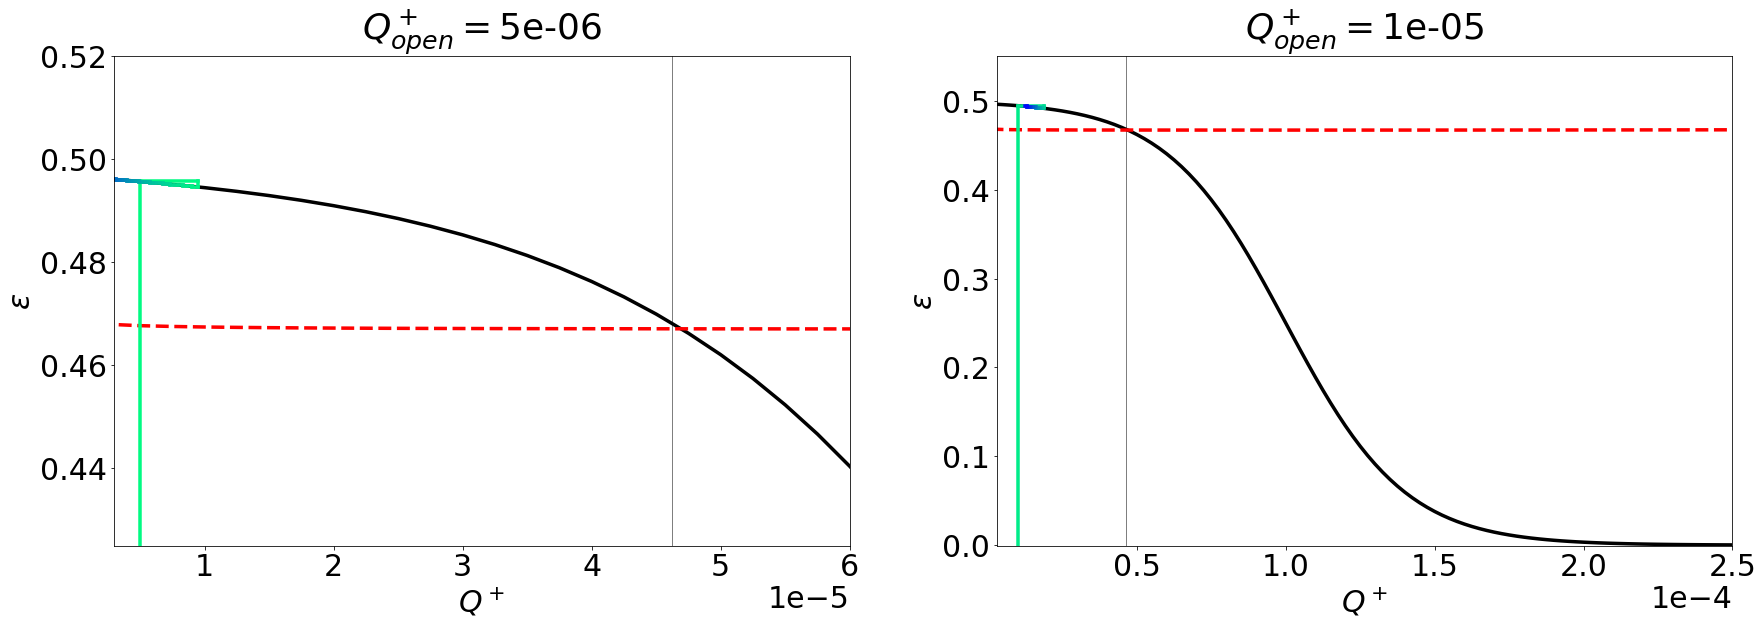

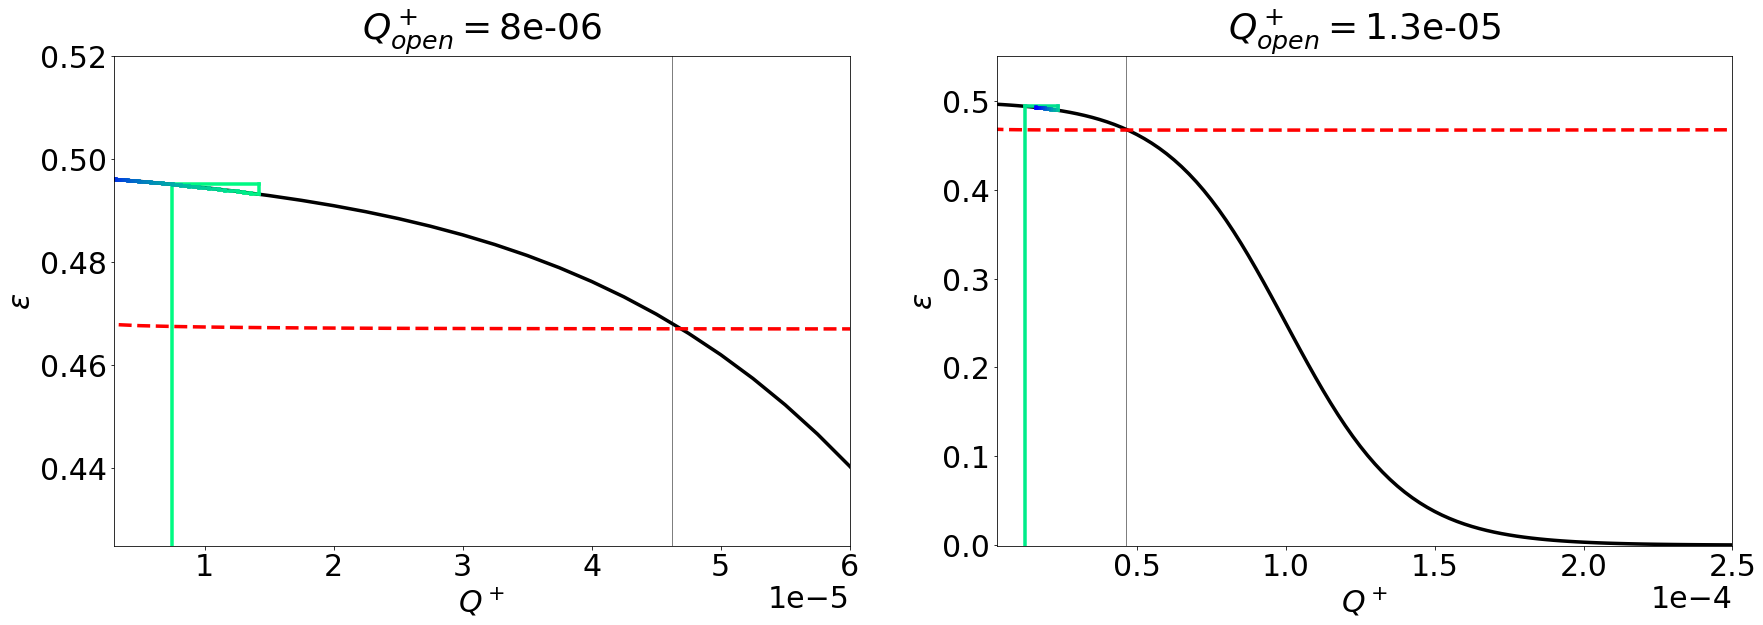

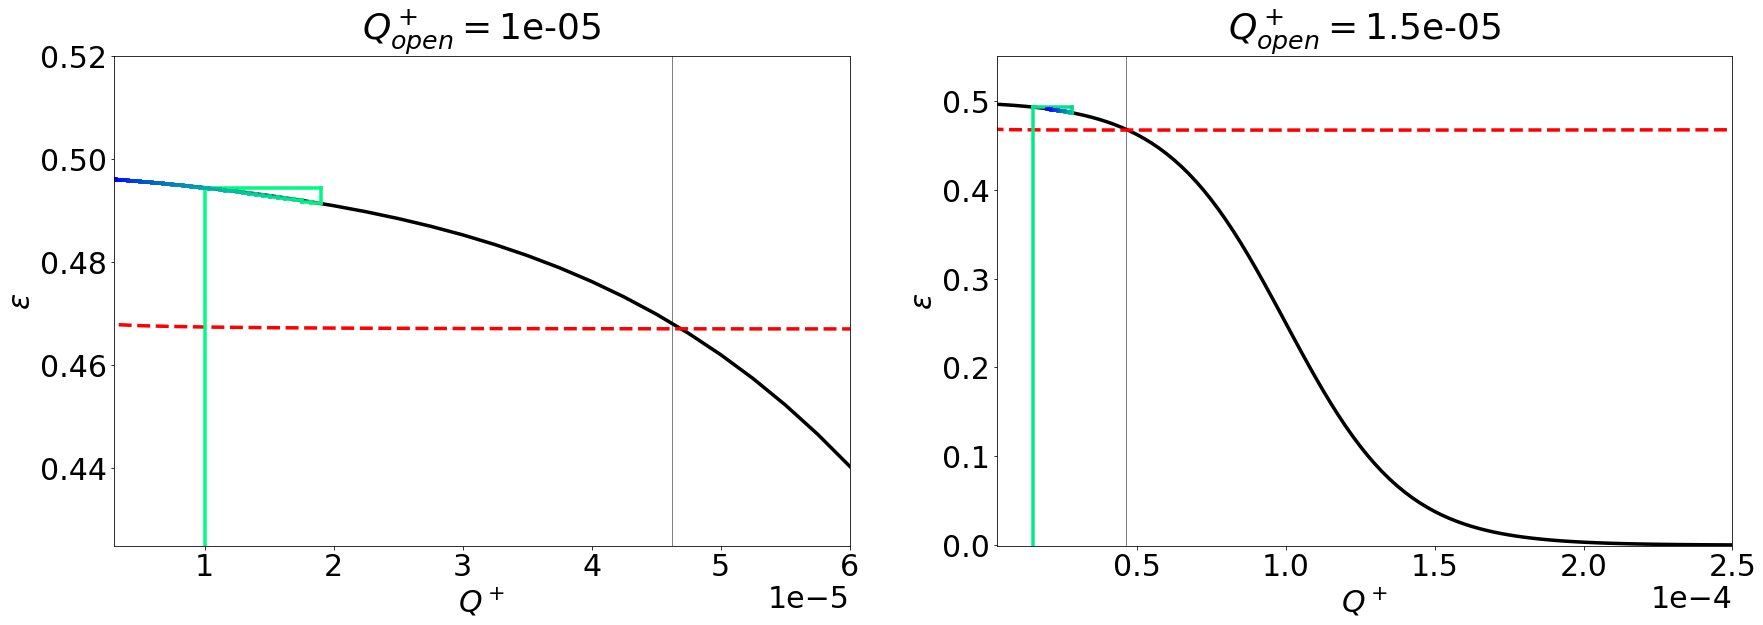

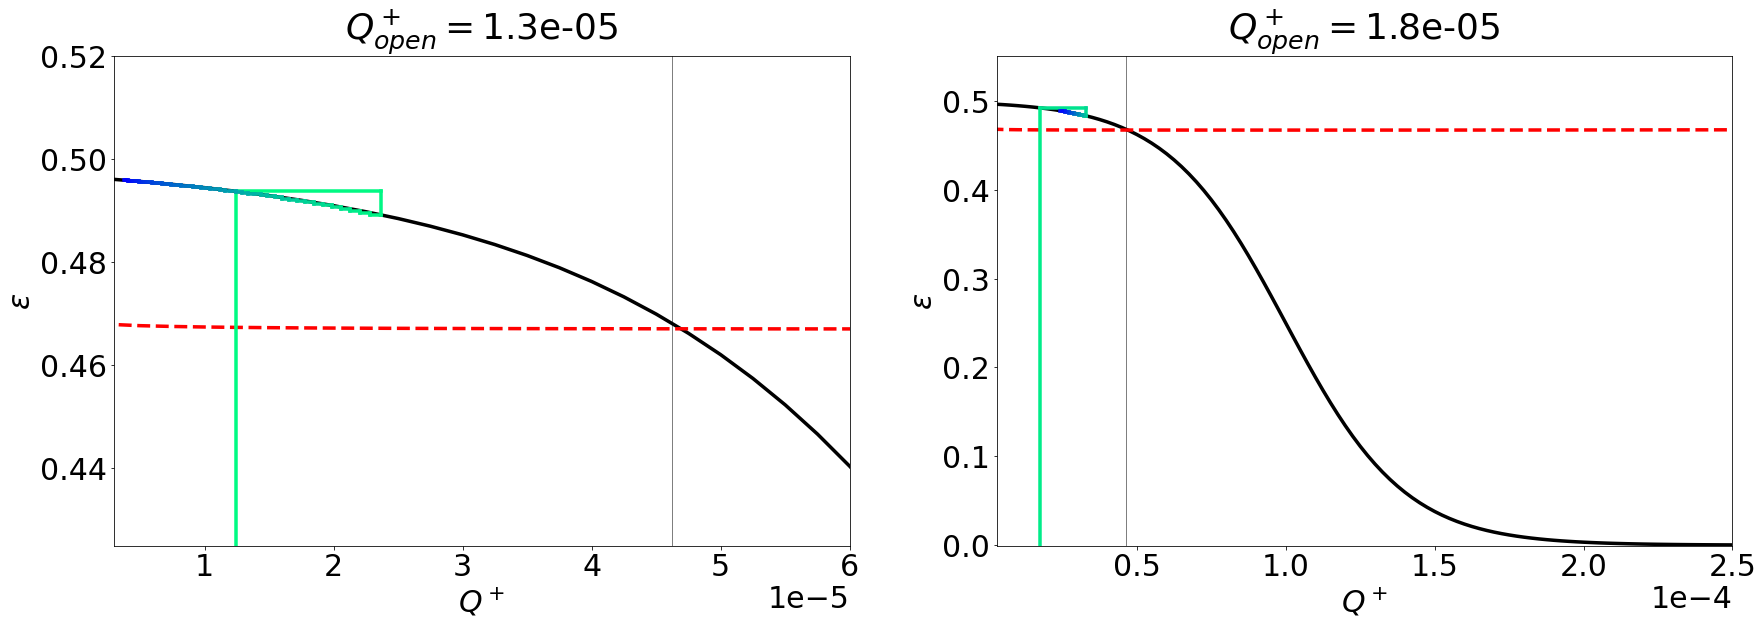

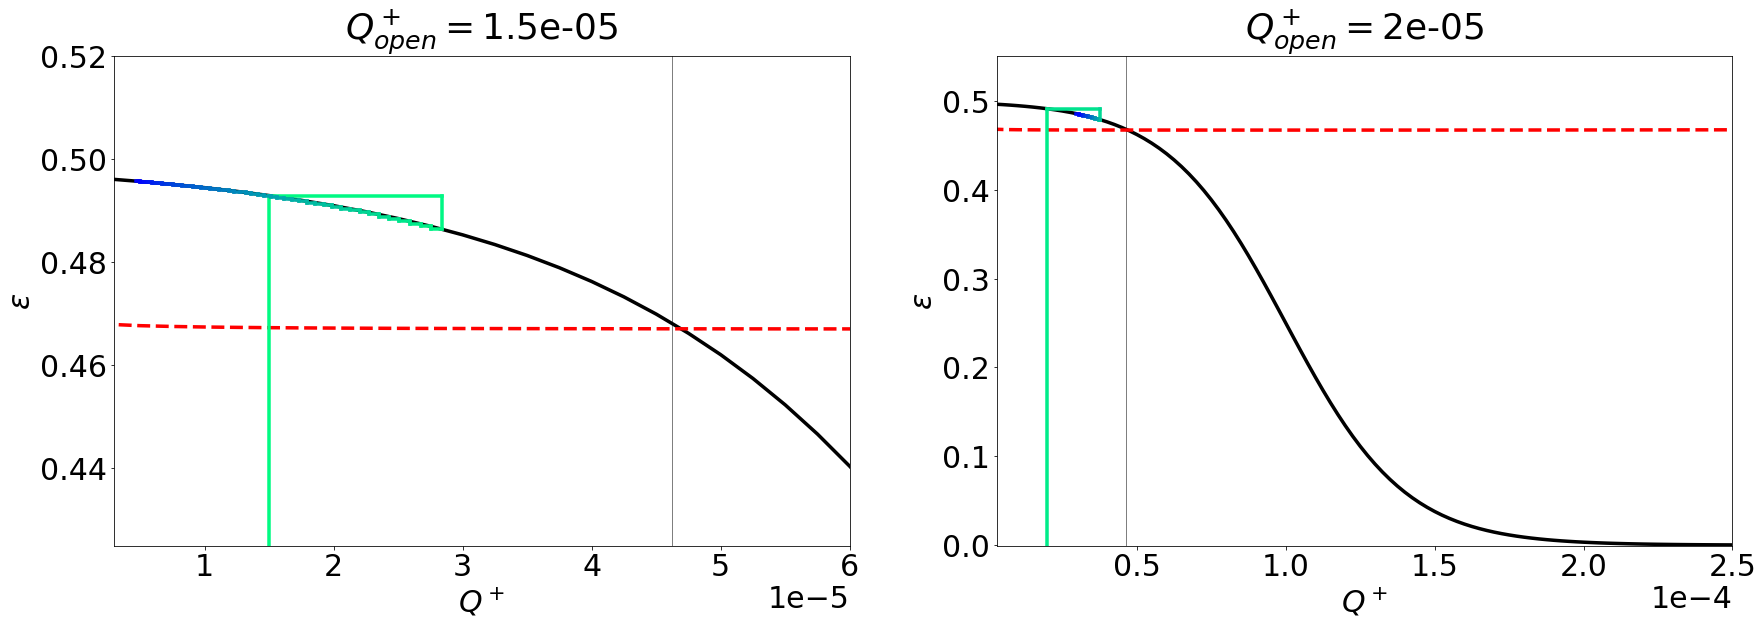

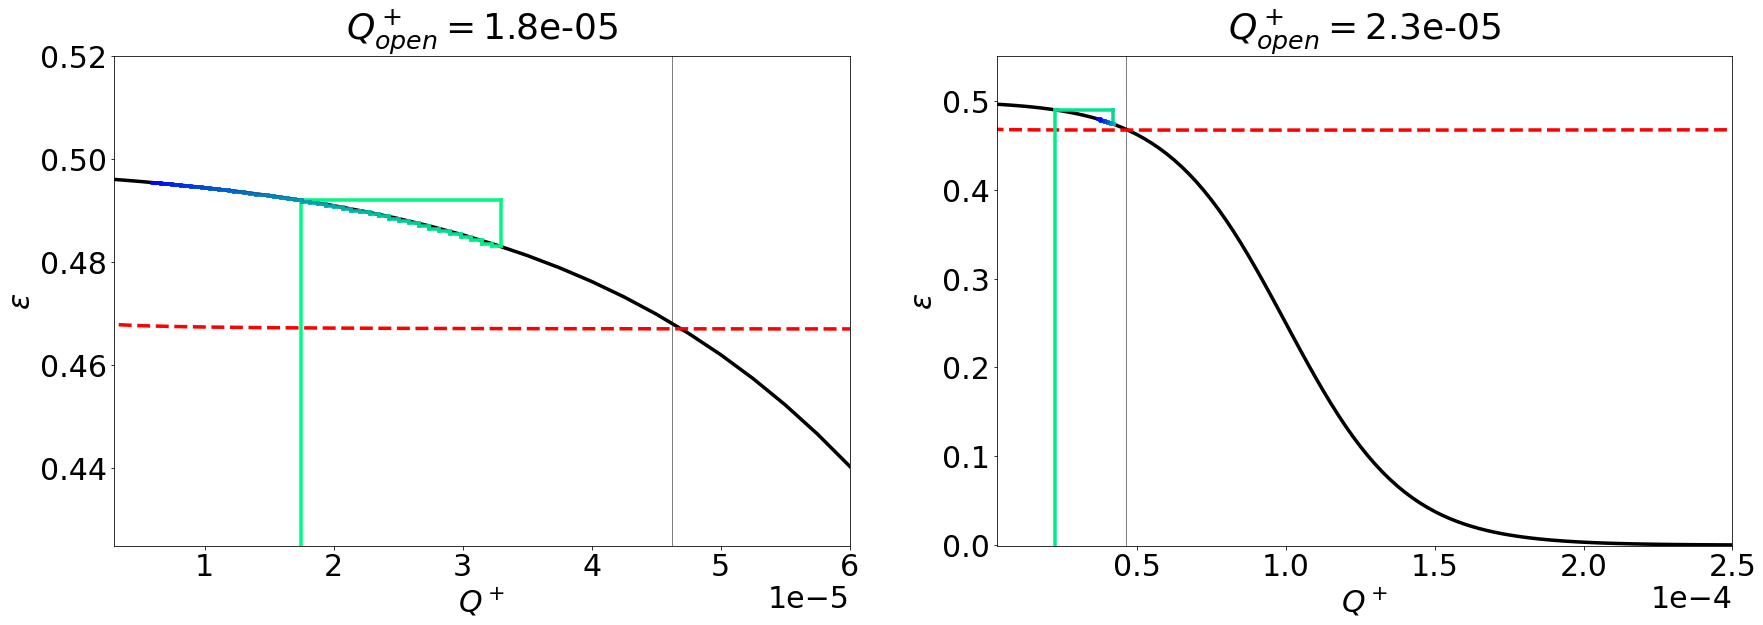

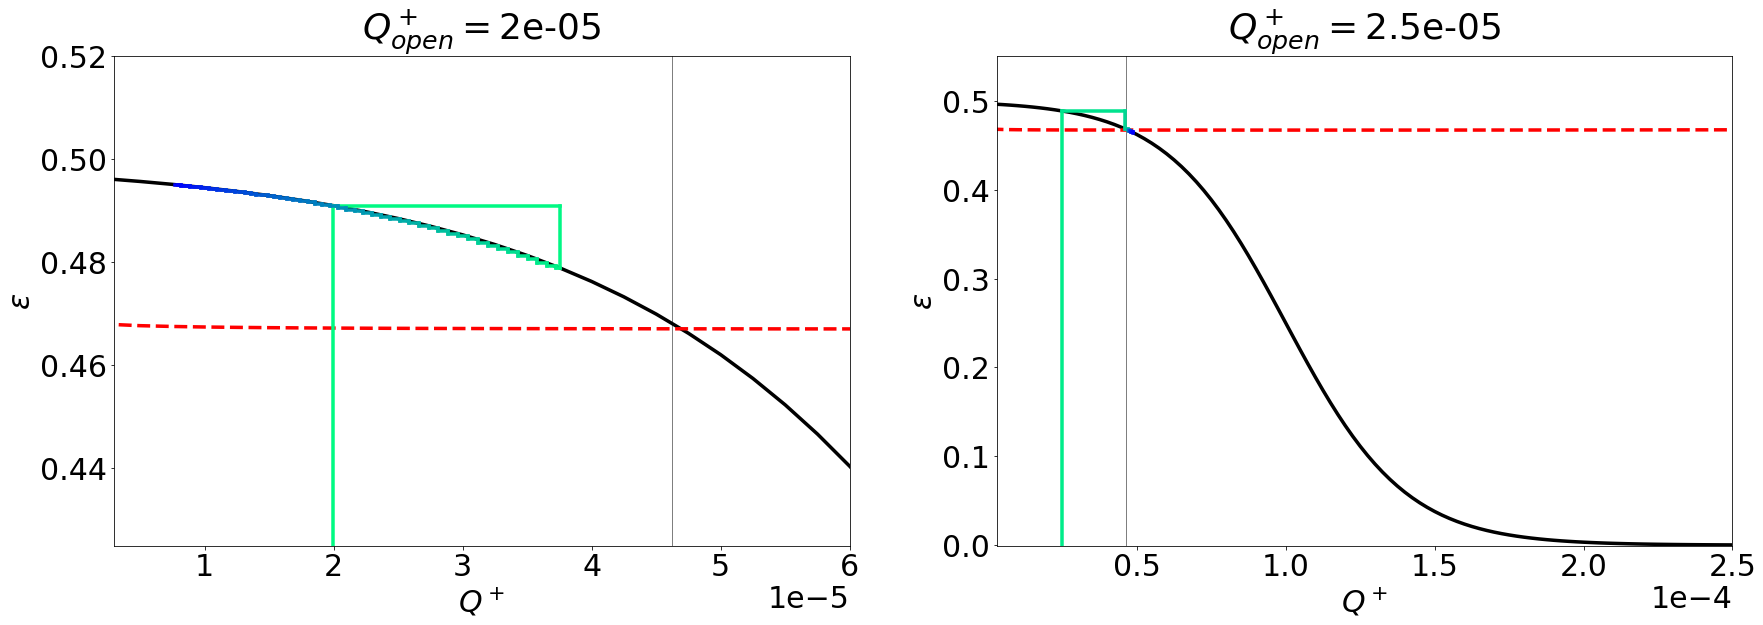

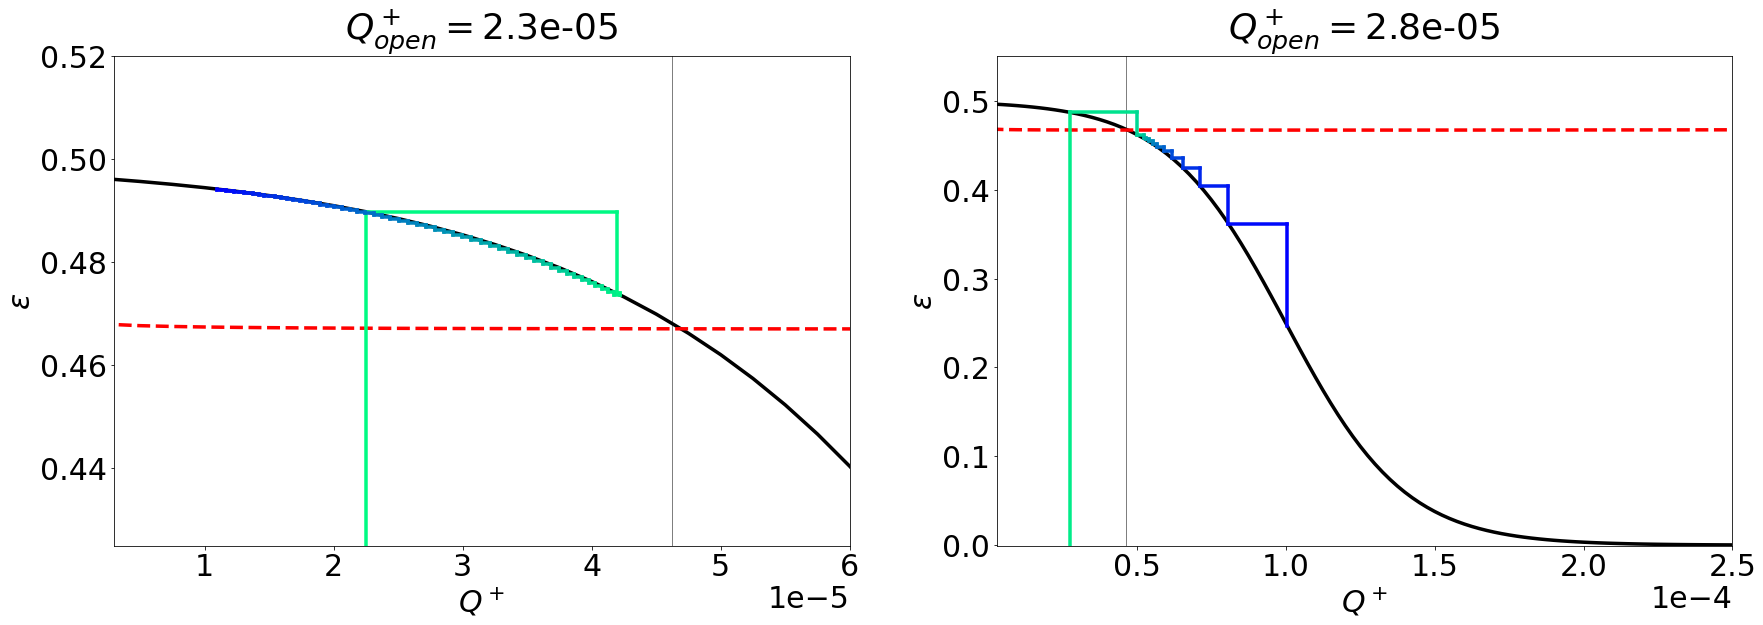

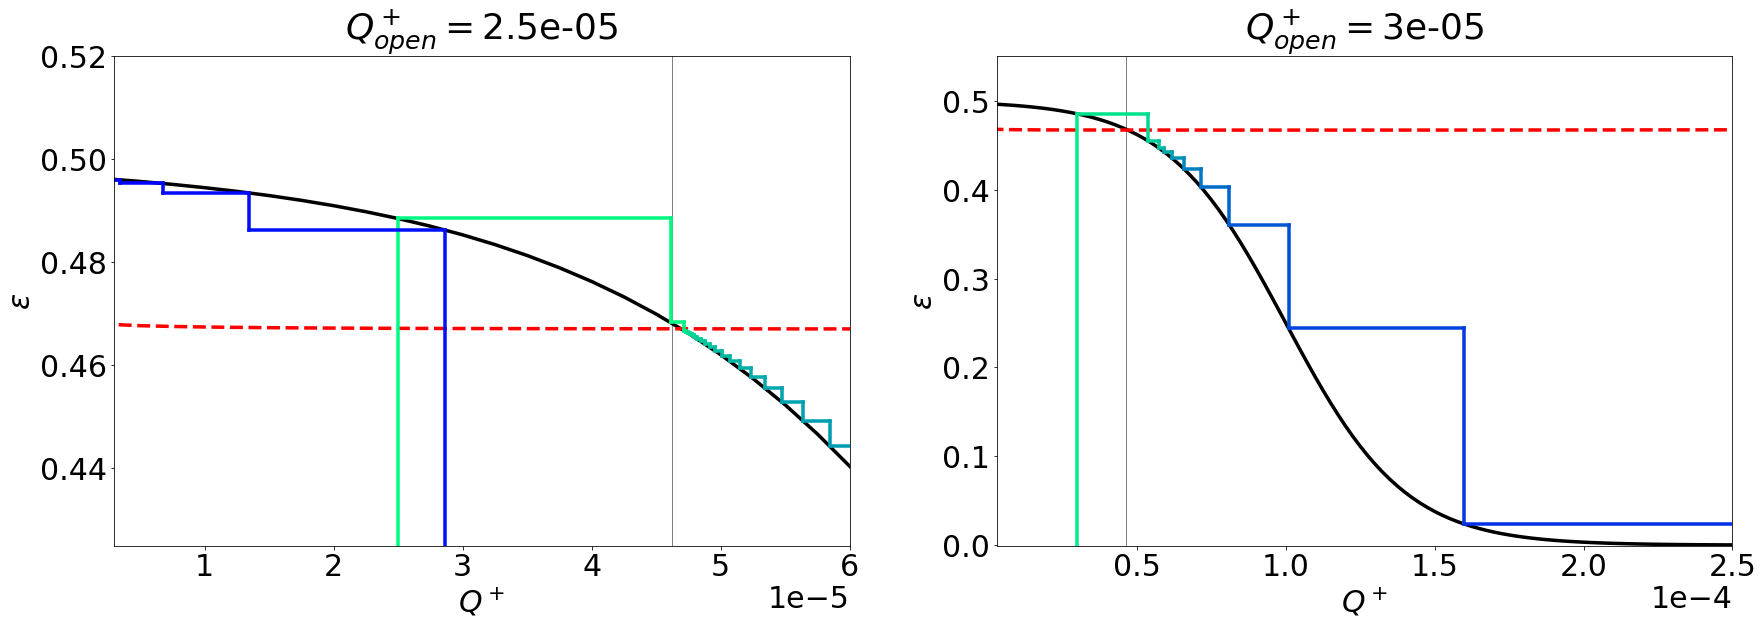

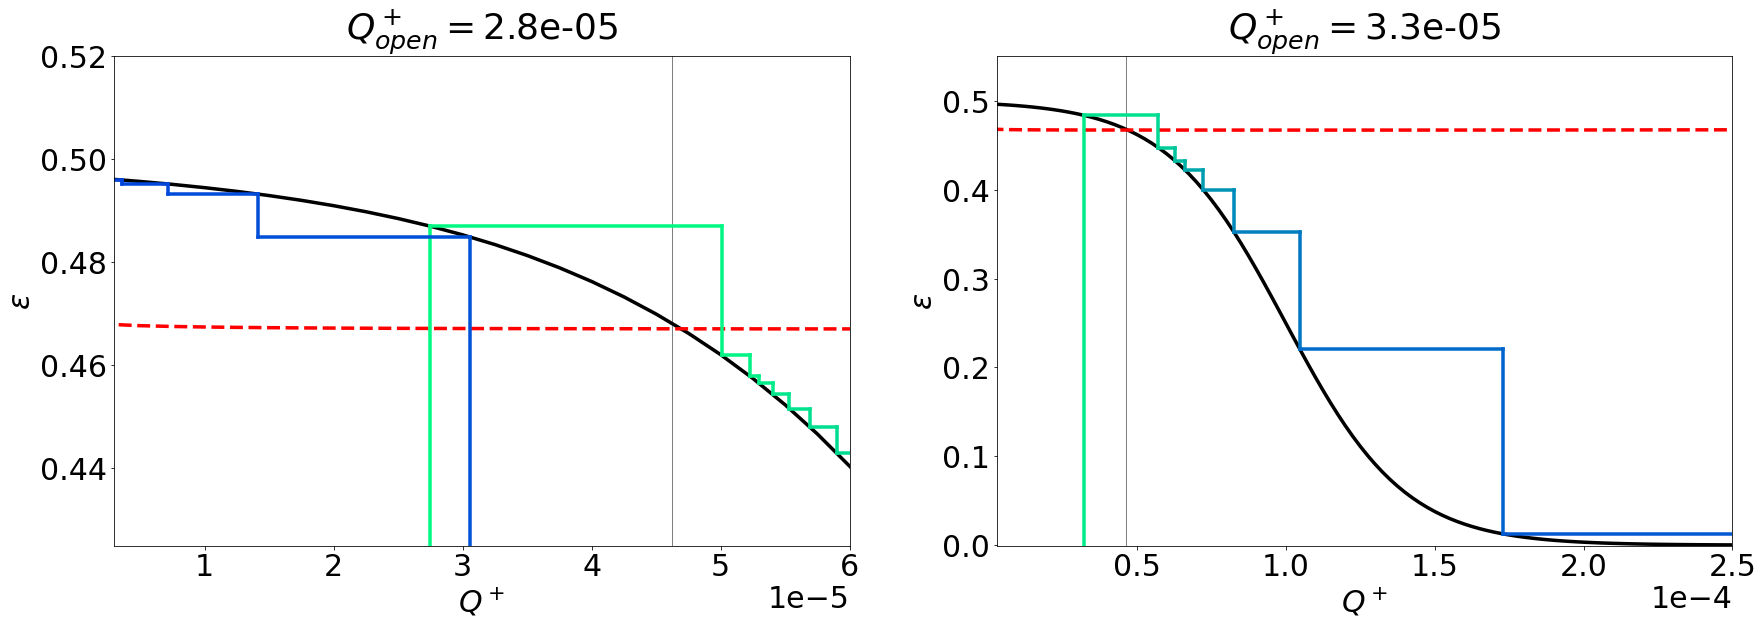

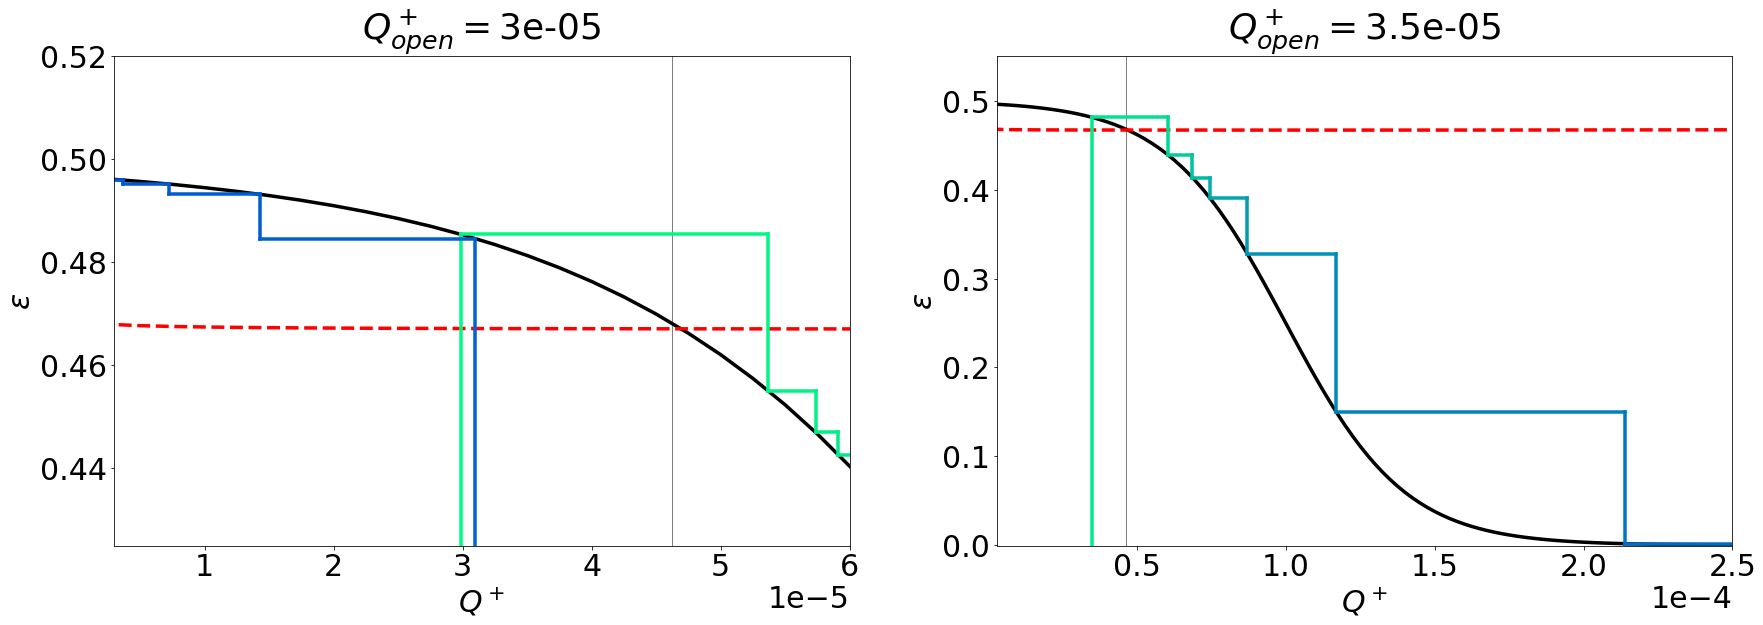

In [ ]:

for ii in [i for i in range(1,12)]:
  fig, (ax, ax2) = plt.subplots(1, 2, figsize=(29, 9))
  plt.rcParams.update({'font.size': 30})
  # sns.set_color_codes("pastel")
  # ax.axvline((x5[intersection_idx-2] + x5[intersection_idx-1])/2, c='k')
  ax.axvline((x5[intersection_idx]+x5[intersection_idx2])/2, c='k', linewidth=0.5)
  ax.plot(x5[:-2], y5[:-2], 'k')
  ax.plot(x1, y1, 'r--')
  # ax.set_xlim(0.000003, 0.00025)
  ax.set_ylim(0.425, 0.52)



  test = testis[ii]
  t2 = np.where(test.delta[1:]<test.delta[:-1])[0][0]  + int(5/test.dt)
  t3 = t2 + np.where(test.Qp[t2:]<=test.qpo)[0][0]
  # t3 = np.where(test.delta[1:]>test.delta[:-1])[0][0]  + int(5/test.dt)
  qeep = test.Qp[t3:int(80/test.dt):int(1/test.dt)] #:int(1/test.dt/4)
  # eep = test.epsilon_history[t3:int(t3+20/test.dt):100]
  eep = [0.5*SEIQR.contact_curve(i) for i in qeep]
  eep[1:]=eep[:-1]
  eep[0] = 0
  # qeep[1:]=qeep[:-1]

  side = np.max([0.00025, test.qpo*5*1.1])
  ax.set_xlim(0.000003, 0.00006)#side)
  # ax.fill_between([test.qpo*5, side], 0, 0.6, color='r', alpha=0.4)

  pts = []
  for i in range(len(qeep)-1):
    pts.append((qeep[i], eep[i]))
    pts.append((qeep[i], eep[i+1]))
  pts = np.asarray(pts)#.T

  cm = plt.get_cmap('winter')
  ax.set_prop_cycle(color=np.asarray([cm(1.*i/(pts.shape[0])) for i in range(pts.shape[0]-1)])[::-1])

  # plt.scatter([pts[0][0]], [pts[0][1]], c='r')

  for i in range(pts.shape[0]-1):
      ax.plot(pts[i:i+2].T[0],pts[i:i+2].T[1])
  # ax.plot(pts[0], pts[1])
  ax.set_title('$Q^+_{open} = $'+str(round(test.qpo,6)))


  ax2.axvline((x5[intersection_idx]+x5[intersection_idx2])/2, c='k', linewidth=0.5)
  ax2.plot(x5[:-2], y5[:-2], 'k')
  ax2.plot(x1, y1, 'r--')
  ax2.set_xlim(0.000003, 0.00025)
  ax2.set_ylim(-0.0005, 0.55)
  ax2.ticklabel_format(axis='x', style='scientific', scilimits=(0,0))


  test = testis[ii+2]
  t2 = np.where(test.delta[1:]<test.delta[:-1])[0][0]  + int(5/test.dt)
  t3 = t2 + np.where(test.Qp[t2:]<=test.qpo)[0][0]
  # t3 = np.where(test.delta[1:]>test.delta[:-1])[0][0]  + int(5/test.dt)
  qeep = test.Qp[t3:t3+int(14/test.dt):int(1/test.dt)] #:int(1/test.dt/4)
  # eep = test.epsilon_history[t3:int(t3+20/test.dt):100]
  eep = [0.5*SEIQR.contact_curve(i) for i in qeep]
  eep[1:]=eep[:-1]
  eep[0] = 0
  # qeep[1:]=qeep[:-1]

  side = np.max([0.00025, test.qpo*5*1.1])
  # ax2.set_xlim(0.000003, side)
  # ax2.fill_between([test.qpo*5, side], 0, 0.6, color='r', alpha=0.4)

  pts = []
  for i in range(len(qeep)-1):
    pts.append((qeep[i], eep[i]))
    pts.append((qeep[i], eep[i+1]))
  pts = np.asarray(pts)#.T

  cm = plt.get_cmap('winter')
  ax2.set_prop_cycle(color=np.asarray([cm(1.*i/(pts.shape[0])) for i in range(pts.shape[0]-1)])[::-1])

  # plt.scatter([pts[0][0]], [pts[0][1]], c='r')

  for i in range(pts.shape[0]-1):
      ax2.plot(pts[i:i+2].T[0],pts[i:i+2].T[1])
  # ax.plot(pts[0], pts[1])
  ax2.set_title('$Q^+_{open} = $'+str(round(test.qpo,6)))
  # ax2.xaxis.set_ticks(np.arange(0.00001, 0.00025, 0.0005))
  # ax.xaxis.set_ticks(np.arange(0.00001, 0.00006, 0.0001))
  ax.set_ylabel('$\\epsilon$')
  ax2.set_ylabel('$\\epsilon$')
  ax.set_xlabel('$Q^+$')
  ax2.set_xlabel('$Q^+$')


  fig.show()

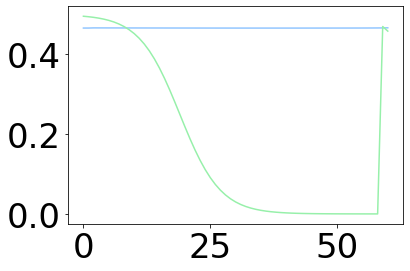

In [ ]:
rplt.plot(y1)
plt.plot(y5)

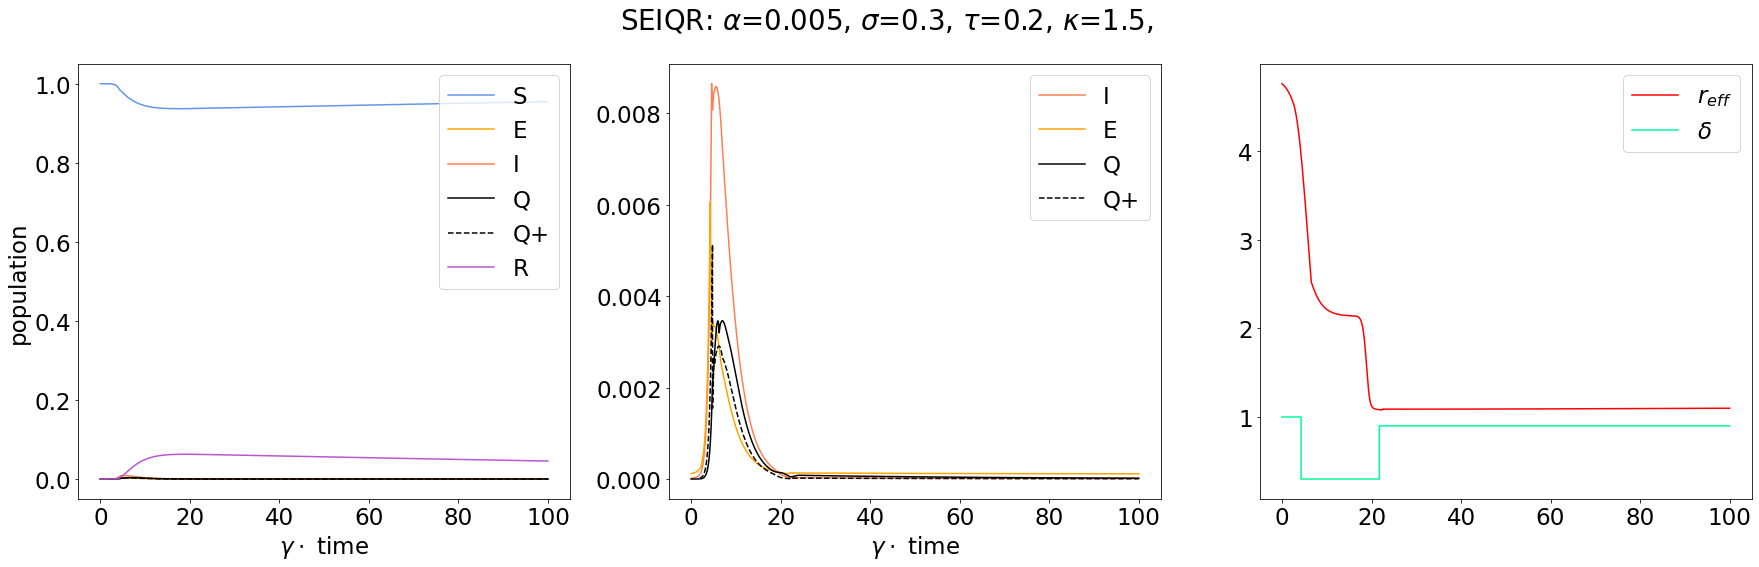

In [ ]:
test.full_plot()

In [ ]:
t3 = np.where(testis[10].delta[1:]>testis[10].delta[:-1])[0][0]
testis[10].t_vector[t3]

21.32

In [ ]:
x5[9], [pts[0][0]], [pts[0][1]], intersection_idx

(5e-05, [4.495414606100301e-05], [0.0], 12)

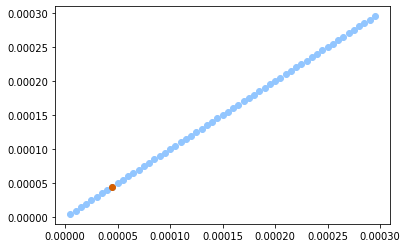

In [ ]:
plt.scatter(x5, x5)
plt.scatter([x5[8]], [x5[8]], c='r')

In [ ]:
# intersection_idx
# pts.shape
np.asarray([cm(1.*i/(pts.shape[1])) for i in range(pts.shape[1]-1)]).shape

(1139, 4)

In [ ]:
np.where(y5<y1)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29]),)

In [ ]:
y1[4], y5[4]
# y1[1], y5[1]

(0.46760709968177444, 0.4699566749129962)

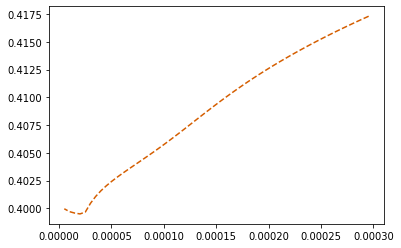

In [ ]:
plt.plot(x1, y1, 'r--')

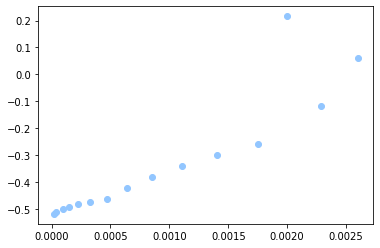

In [ ]:
plt.scatter(qeep, [SEIQR.test(test, i) for i in idx])

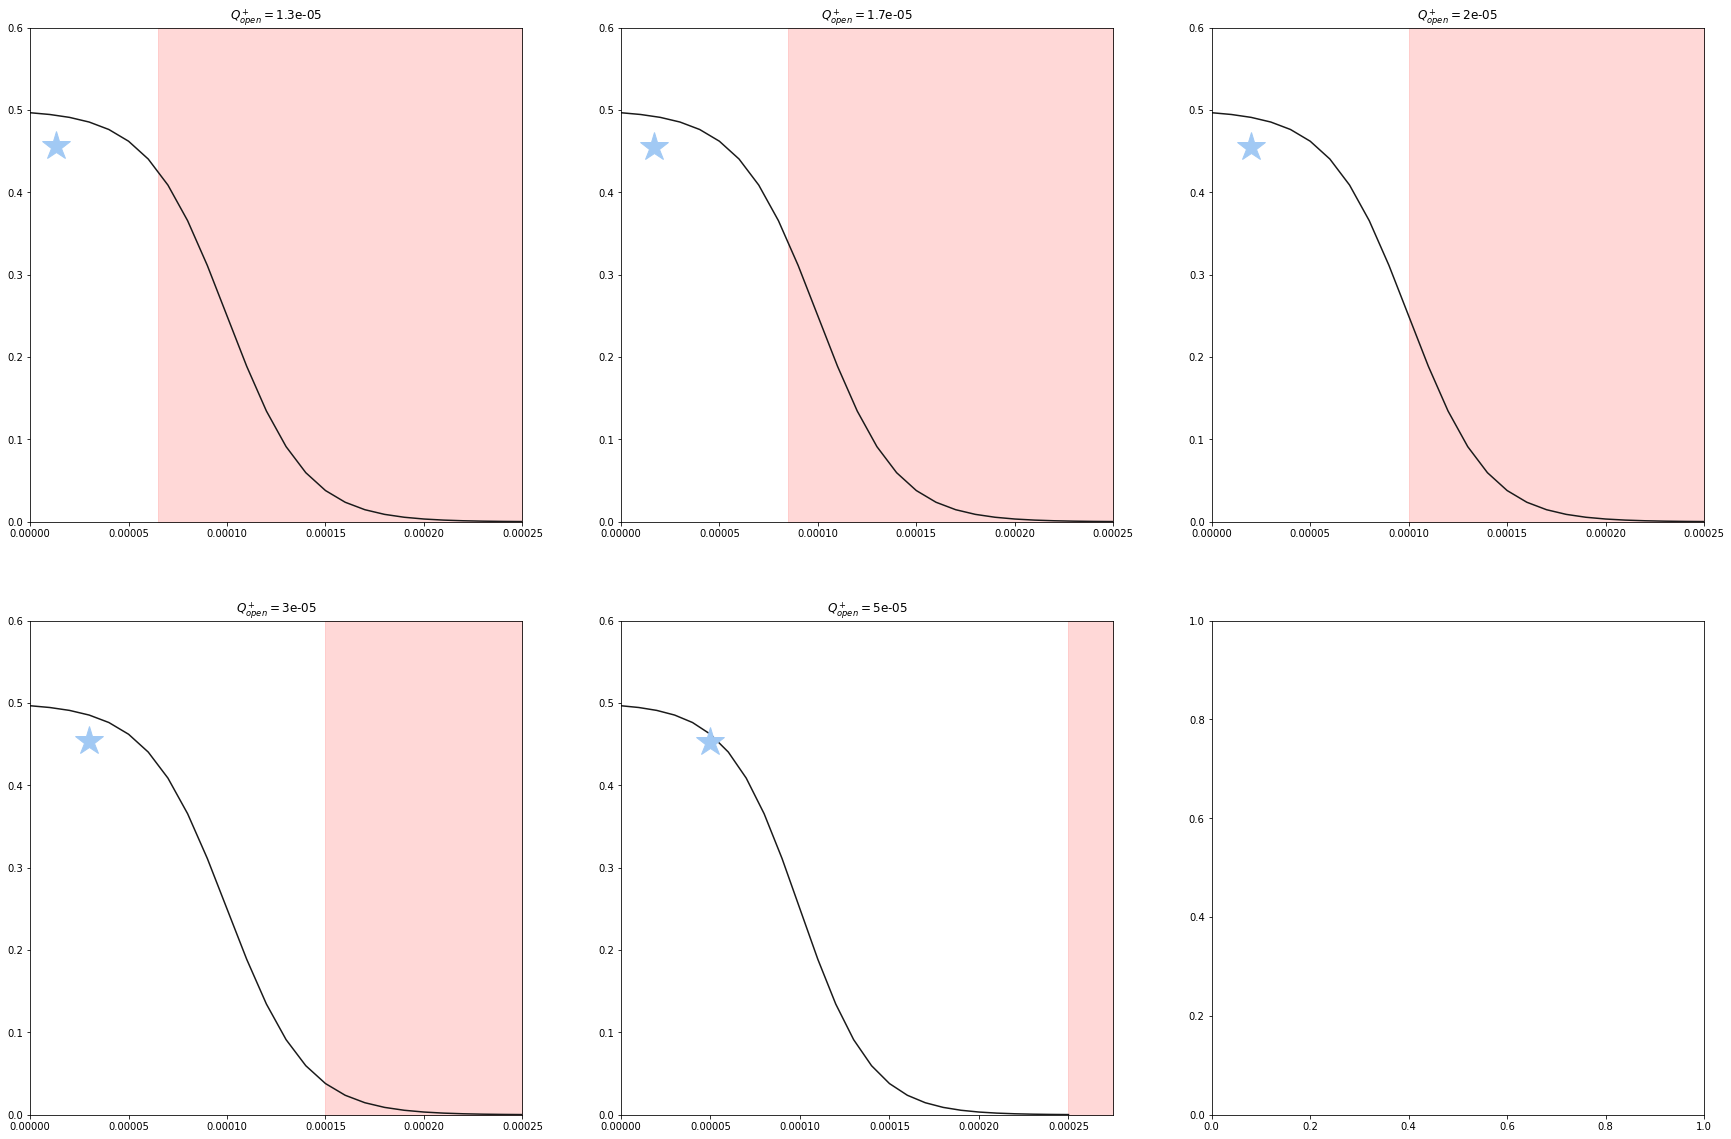

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 20))
sns.set_color_codes("pastel")
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for j in range(len(testis)):
  test = testis[j]
  t3 = np.where(test.delta[1:]>test.delta[:-1])[0][0]
  e_star = SEIQR.test(test, t3)
  # qeep = test.Qp[t3:int(80/test.dt):100]

  # print(t3, t4, qeep.shape)

  # eep = [0.5*SEIQR.contact_curve(i) for i in qeep]
  # eep[1:]=eep[:-1]
  # eep[0] = 0
  # qeep[1:]=qeep[:-1]
  # t3*test.dt

  # pts = []
  # for i in range(len(qeep)-1):
  #   pts.append((qeep[i], eep[i]))
  #   pts.append((qeep[i], eep[i+1]))
  # pts = np.asarray(pts).T

  side = np.max([0.00025, test.qpo*5*1.1])
  axs[j].fill_between([test.qpo*5, side], 0, 0.6, color='r', alpha=0.4)

  x = [i/100000 for i in range(0, 26)]
  axs[j].plot(x, [0.5*SEIQR.contact_curve(i) for i in x], 'k')
  # axs[j].plot(pts[0], pts[1], 'b')
  axs[j].plot([test.qpo], [e_star], color='b', marker = '*', markersize=30)
  axs[j].set_title('$Q^+_{open} = $' + str(test.qpo))
  axs[j].set_xlim(0, side)
  axs[j].set_ylim(0, 0.6)
  

In [ ]:
model2_plot(testis[2])

In [ ]:
test = testis[-1]
t3 = np.where(test.delta[1:]>test.delta[:-1])[0][0]
qeep = test.Qp[t3:int(t3+20/test.dt):100]
# eep = test.epsilon_history[t3:int(t3+20/test.dt):100]
eep = [1 - 0.5*SEIQR.contact_curve(i) for i in qeep]
eep[1:]=eep[:-1]
eep[0] = 0
qeep[1:]=qeep[:-1]
t3*test.dt

17.385

In [ ]:
pts = []
for i in range(len(qeep)-1):
  pts.append((qeep[i], eep[i]))
  pts.append((qeep[i], eep[i+1]))
pts = np.asarray(pts).T

In [ ]:
for i in range(len(testis)):
  test = testis[i]
  t3 = np.where(test.delta[1:]>test.delta[:-1])[0][0]
  # try:
  #   t4 = t3 + np.where(test.delta[t3 + 1:]<test.delta[t3:-1])[0][0]
  #   t4 = t4 + np.where(test.delta[t4 + 1:]<test.delta[t4:-1])[0][0]
  #   t4 = t4 + np.where(test.delta[t4 + 1:]<test.delta[t4:-1])[0][0]
  # except:
  qeep = test.Qp[t3:int(60/test.dt):100]
  # else:
  #   qeep = test.Qp[t3:t4:100]
  print(t3, t4, qeep.shape)
  # eep = test.epsilon_history[t3:int(t3+20/test.dt):100]
  eep = [0.5*SEIQR.contact_curve(i) for i in qeep]
  eep[1:]=eep[:-1]
  eep[0] = 0
  qeep[1:]=qeep[:-1]
  t3*test.dt

  pts = []
  for i in range(len(qeep)-1):
    pts.append((qeep[i], eep[i]))
    pts.append((qeep[i], eep[i+1]))
  pts = np.asarray(pts).T
  # pts[1] = -(pts[1] - 1)
  # pts[1][0] = 0

 
  plt.fill_between([test.qpo*5, 0.00025], 0, 0.6, color='r', alpha=0.4)

  x = [i/100000 for i in range(0, 26)]
  plt.plot(x, [0.5*SEIQR.contact_curve(i) for i in x], 'k')
  plt.plot(pts[0], pts[1], 'b')
  plt.xlim(0, 0.00025)
  plt.ylim(0, 0.6)
  plt.show()